# Modelling Carbon Capture and Energy Storage at Steady and Transient Operation

### Sunshine Tanphiphat
M Sc. Energy System,
Department of Engineering Science,
University of Oxford,

Supervisor: 
Prof. Budimir Rosic (Oxford Thermofluids Institute),
Prof. Aidong Yang (Oxford Agile Initiative)

2025

# Environment

## Clearing

In [1]:
%reset -f
from IPython.display import clear_output; clear_output(wait=True)
import matplotlib.pyplot as plt; plt.close('all')

## Simulation timer

In [2]:
import time              
_start_time = time.time() 

## Function Imports

In [3]:
from pathlib import Path
import time
from openpyxl import load_workbook

In [4]:
import os
import math
import pandas as pd
import numpy as np
import sympy as sp
import sys 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from evalwitherrfun import eval_with_err
from addfun import add_fun
from subtractfun import subtract_fun
from multiplyfun import multiply_fun
from dividefun import divide_fun
from powerfun import power_fun

In [6]:
from getvaluefun import get_value
from getremainingthermovarsfun import get_remaining_thermo_vars
from gethfrometafun import get_h_from_eta
from getsolvedstatefun import get_solved_state

In [7]:
from getdepthfromTfun import get_depth_from_T
from callgetvaluefun import call_get_value
from getTfromdepthfun import get_T_from_depth

In [8]:
from getDutyfun import get_Duty
from getToutfun import get_Tout
from getToutstr2fun import get_Tout_str2
from Wfun import W_fun
from Qfun import Q_fun

In [9]:
from selectvaluecolumnsfun import select_value_columns
from quantvisfun import quant_vis
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

In [10]:
from findPbottomsecantfun import find_P_bottom_secant
from findpipediameterfun import find_pipe_diameter
from batchoptpipediameterfun import batch_opt_pipe_diameter

In [11]:
from getvisfun import get_vis
from secantsolvecompressibilityfun import secant_solve_compressibility_implicit
from operategeobatteryfun import operate_geobattery

In [12]:
from pathlib import Path
project_root = Path.cwd().parent     
input_dir    = project_root / 'Input_Spreadsheets'    
model_dir = project_root / 'Model_Files' 

# Inputs

## Global Inputs

### Simulation Round

In [13]:
simulation_name = 'SCCESModelCalibration'

### CGES Type

In [14]:
Working_fluid = 'CO2'
Cycle = 'SCCES'

### Toggles

In [15]:
# Allowable frictional loss MPa/m
gradP = 0.0001*1

In [16]:
# Storage Depths 
z_HS = 3000; # HS C.O.M. depth
z_LS = 760; # LS C.O.M. depth

In [17]:
min_HS_reg = gradP * 2 * z_HS; min_LS_reg = gradP * 2 * z_LS;
print(f'Minimum HS pressure regulation = {min_HS_reg} MPa, LS pressure regulation = {min_LS_reg} MPa')

Minimum HS pressure regulation = 0.6 MPa, LS pressure regulation = 0.152 MPa


In [18]:
HS_thrtl_deliberate = 5-min_HS_reg # Deliberate turbine inlet pressure regulation
LS_thrtl_deliberate = 0.5-min_LS_reg # Deliberate compressor inlet pressure regulation

In [19]:
HS_reg = min_HS_reg + HS_thrtl_deliberate; LS_reg = min_LS_reg + LS_thrtl_deliberate; 
print(f'Pressure regulation: HS {HS_reg} ΔMPa, LS {LS_reg} ΔMPa')

Pressure regulation: HS 5.0 ΔMPa, LS 0.5 ΔMPa


In [20]:
# Compression Train
P_0, P_0err = 7.54, 0 #MPa Compressor train inlet P (subcritical, critical = 7.40 MPa)
T_0, T_0err = 307.83, 0 #K Compressor train inlet T (supercritical, critical = 307.83 K)
P_max_c = 25
num_C = 1 #num Compressors in train
P_lift1ratio = float("nan"); P_lift2ratio = float("nan"); P_lift3ratio = float("nan")

In [21]:
# Expansion Distribution
num_T = 1 #num Turbines in train
P_drop1ratio = float("nan");

In [22]:
# Reheating
T_max = 873

In [23]:
# Nameplate capacity of wind farm kW
Nameplate_capacity = 100 * 1000 

# Power spot prices
elexon_df = pd.read_excel(input_dir/'ELEXON_SystemPrices_Jul_7_2019.xlsx'); SystemPrices_arr = elexon_df['System_price'].to_numpy(); assert SystemPrices_arr.shape[0] == 48, "Expected 48 half‐hourly prices"

# Wind generation
rn_df = pd.read_excel(input_dir/'RenewablesNinja_WindGeneration_Jul_7_2019.xlsx'); hourly_cf = rn_df['Capacity_factor'].to_numpy(); assert hourly_cf.shape[0] == 24, "Expected 24 hourly capacity factors"
CF_avg = hourly_cf.mean()

## Internal Parameters

### Geography

In [24]:
Patm = 0.101325 #MPa
Vrock_LS, Vrock_HS = 1e5, 1e5 #aquifer rock volume
z_S, z_Serr = 0, 0 #m
G, G_err = 0.025, 0 #K/m Geologic T gradient
Ts, Ts_err = 283, 0 #K Surface temperature
beta_p, beta_perr = 4.5*1e-10, 0 #Pa-1 Pore compressibility 
beta_w, beta_werr = 3.5*1e-10, 0 #Pa-1 Brine compressibility
p_w, p_werr = 1025, 0 # Surface brine density kg/m3
g, gerr = 9.81, 0 # Gravitational acceleration
por = 0.275 # Porosity
tol_P_storage = 0.025 #qausi-steady-state pressure deviation allowance frac

### Compression train

In [25]:
T_w, T_werr = 313, 0; #compressor inlet T
eta_C = 0.85 #frac Compressor isentropic efficiency
eta_grid_avg = 0.50 #frac baseload power plant efficiency

### Expansion train

In [26]:
eta_T = 0.87 #frac Turbine isentropic efficiency
eta_gen_avg = 0.476 #frac standalone generator efficiency
eta_burner_Gulen = 0.6815 #gas burner efficiency

### Transport 

In [27]:
m_CO2info=[1, 0]; m_CO2 = m_CO2info[0]; m_CO2err = m_CO2info[1] #Mass basis
r= 0.000045 #Conduit roughness m

### Thermodynamic Data

In [28]:
Thermodata_filename = f'../Input_Spreadsheets/Thermodata_{Working_fluid}'; df0 = pd.read_excel(f'{Thermodata_filename}.xlsx')

# Simulation

## Derived P

In [29]:
HS_fric = z_HS * gradP; HS_thrtl = HS_reg - 2*HS_fric; 
if HS_thrtl < 0: 
    print('HS Regulation Spares Insufficiently for Frictional Losses'); raise KeyboardInterrupt("Stopping execution")
LS_fric = z_LS * gradP; LS_thrtl = LS_reg - 2*LS_fric;
if LS_thrtl < 0: 
    print('LS Regulation Spares Insufficiently for Frictional Losses'); raise KeyboardInterrupt("Stopping execution")

In [30]:
P_lift = P_max_c - P_0; 

In [31]:
P_inlet_t = P_max_c - HS_reg;
P_min_t = P_0 + LS_reg; 
P_drop = P_inlet_t - P_min_t;

In [32]:
P1_d = P_0
P2_d = P1_d + P_lift
P3_d = P2_d - HS_reg
P4_d = P3_d
P5_d = P4_d
P6_d = P5_d - P_drop
P7_d = P6_d

if P2_d == P_max_c:
    print('Compression pressure achieved')
else: 
    print('No')
if P6_d == P_0 + LS_reg:
    print('Cycle pressure calibrated')
else:
    print('No')

Compression pressure achieved
Cycle pressure calibrated


## Defining Stream State

In [33]:
df = pd.read_excel(input_dir/f'{Cycle}_Inputs.xlsx'); dfc = pd.read_excel(input_dir/f'Cycledata_{Cycle}.xlsx');

In [34]:
# Stream 1
stream_num = 1; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
df.loc[idx, ['P','Perr','T','Terr']] = [P1_d, 0, T_0, 0]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 7.500,8.000
interp T@7.540: -147.386±0.000
interp T@7.540: -181.540±0.000
→ -150.118±0.000
P interp bounds: 7.500,8.000
interp T@7.540: -122.282±0.000
interp T@7.540: -162.437±0.000
→ -125.494±0.000
P interp bounds: 7.500,8.000
interp T@7.540: -1.135±0.000
interp T@7.540: -1.271±0.000
→ -1.146±0.000
P interp bounds: 7.500,8.000
interp T@7.540: 188.977±0.000
interp T@7.540: 220.672±0.000
→ 191.513±0.000
P interp bounds: 7.500,8.000
interp T@7.540: 312.597±0.000
interp T@7.540: 470.522±0.000
→ 325.231±0.000
P interp bounds: 7.500,8.000
interp T@7.540: 1.246±0.000
interp T@7.540: 1.121±0.000
→ 1.236±0.000
P interp bounds: 7.500,8.000
interp T@7.540: 31.881±0.000
interp T@7.540: 8.600±0.000
→ 30.018±0.000


P exact: 25.000
interp s@25.000: -86.791±0.000
Compressor: h_in=-125.494±0.000, h_iso=-86.791±0.000, eta=0.850 → h_out=-79.961±0.000


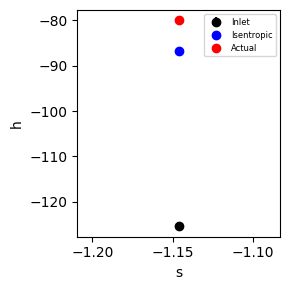

P exact: 25.000
interp h@25.000: 383.568±0.000
P exact: 25.000
interp h@25.000: -126.022±0.000
P exact: 25.000
interp h@25.000: -1.128±0.000
P exact: 25.000
interp h@25.000: 359.087±0.000
P exact: 25.000
interp h@25.000: 543.495±0.000
P exact: 25.000
interp h@25.000: 0.903±0.000
P exact: 25.000
interp h@25.000: 2.117±0.000


In [35]:
# Stream 2
stream_num = 2; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P1, P1err, h1, h1err, s1, s1err = df.loc[idx-1, ['P', 'Perr','h','herr','s', 'serr']]; 
P2, P2err = P2_d, 0; h2,h2err=get_h_from_eta([P2, P2err],[h1,h1err],[s1, s1err],eta_C,'Compressor',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P2, P2err, h2, h2err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [36]:
# Stream 3
stream_num = 3; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']
P3, P3err = P3_d, 0; h3, h3err = df.loc[idx-1, ['h','herr']]
df.loc[idx, ['P','Perr','h','herr']] = [P3, P3err, h3, h3err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P exact: 20.000
interp h@20.000: 373.507±0.000
P exact: 20.000
interp h@20.000: -121.735±0.000
P exact: 20.000
interp h@20.000: -1.103±0.000
P exact: 20.000
interp h@20.000: 314.913±0.000
P exact: 20.000
interp h@20.000: 479.845±0.000
P exact: 20.000
interp h@20.000: 0.907±0.000
P exact: 20.000
interp h@20.000: 2.333±0.000


In [37]:
# Stream 5
stream_num = 5; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']
P5, P5err, T5, T5err = P5_d, 0, T_max, 0 
df.loc[idx, ['P','Perr','T','Terr']] = [P5, P5err, T5, T5err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P exact: 20.000
interp T@20.000: 419.370±0.000
P exact: 20.000
interp T@20.000: 590.599±0.000
P exact: 20.000
interp T@20.000: 0.074±0.000
P exact: 20.000
interp T@20.000: 469.691±0.000
P exact: 20.000
interp T@20.000: 117.171±0.000
P exact: 20.000
interp T@20.000: 1.015±0.000
P exact: 20.000
interp T@20.000: 1.250±0.000


P interp bounds: 8.000,10.000
interp s@8.040: 448.676±0.000
interp s@8.040: 480.352±0.000
→ 449.310±0.000
Turbine: h_in=590.599±0.000, h_iso=449.310±0.000, eta=0.870 → h_out=467.678±0.000


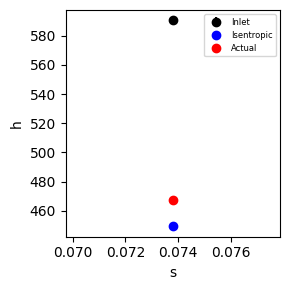

P interp bounds: 8.000,10.000
interp h@8.040: 764.134±0.000
interp h@8.040: 765.979±0.000
→ 764.171±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 322.370±0.000
interp h@8.040: 321.639±0.000
→ 322.356±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 0.099±0.000
interp h@8.040: 0.057±0.000
→ 0.098±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 423.189±0.000
interp h@8.040: 426.118±0.000
→ 423.247±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 55.312±0.000
interp h@8.040: 67.478±0.000
→ 55.556±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 0.970±0.000
interp h@8.040: 0.972±0.000
→ 0.970±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 1.187±0.000
interp h@8.040: 1.195±0.000
→ 1.187±0.000


In [38]:
# Stream 6
stream_num = 6; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P6,P6err= P6_d,0; h5, h5err = df.loc[idx-1, ['h','herr']]; s5, s5err = df.loc[idx-1, ['s','serr']]; h6,h6err=get_h_from_eta([P6, P6err],[h5,h5err],[s5, s5err],eta_T,'Turbine',Thermodata_filename);  
df.loc[idx, ['P','Perr','h','herr']] = [P6, P6err, h6, h6err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

In [39]:
# Stream 7
stream_num = 7; idx = stream_num - 1
df.loc[idx,['Definer_1','Definer_2']] = ['P','h']; 
P7, P7err = P7_d, 0; h7, h7err = df.loc[1-1, ['h','herr']];
df.loc[idx, ['P','Perr','h','herr']] = [P7, P7err, h7, h7err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

P interp bounds: 8.000,10.000
interp h@8.040: 309.962±0.000
interp h@8.040: 322.958±0.000
→ 310.222±0.000
P interp bounds: 8.000,10.000
interp h@8.040: -149.812±0.000
interp h@8.040: -151.129±0.000
→ -149.838±0.000
P interp bounds: 8.000,10.000
interp h@8.040: -1.151±0.000
interp h@8.040: -1.168±0.000
→ -1.151±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 194.739±0.000
interp h@8.040: 219.554±0.000
→ 195.236±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 330.196±0.000
interp h@8.040: 394.898±0.000
→ 331.490±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 1.149±0.000
interp h@8.040: 1.029±0.000
→ 1.147±0.000
P interp bounds: 8.000,10.000
interp h@8.040: 9.569±0.000
interp h@8.040: 6.036±0.000
→ 9.499±0.000


P interp bounds: 8.000,10.000
interp T@8.040: 1.187±0.000
interp T@8.040: 1.195±0.000
→ 1.187±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.186±0.000
interp T@8.040: 1.194±0.000
→ 1.187±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.186±0.000
interp T@8.040: 1.194±0.000
→ 1.186±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.185±0.000
interp T@8.040: 1.193±0.000
→ 1.185±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.185±0.000
interp T@8.040: 1.193±0.000
→ 1.185±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.184±0.000
interp T@8.040: 1.193±0.000
→ 1.184±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.184±0.000
interp T@8.040: 1.192±0.000
→ 1.184±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.183±0.000
interp T@8.040: 1.192±0.000
→ 1.183±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.183±0.000
interp T@8.040: 1.191±0.000
→ 1.183±0.000
P interp bounds: 8.000,10.000
interp T@8.040: 1.182±0.000
interp T@8.040: 1.191±0.000
→ 1.182±0.000


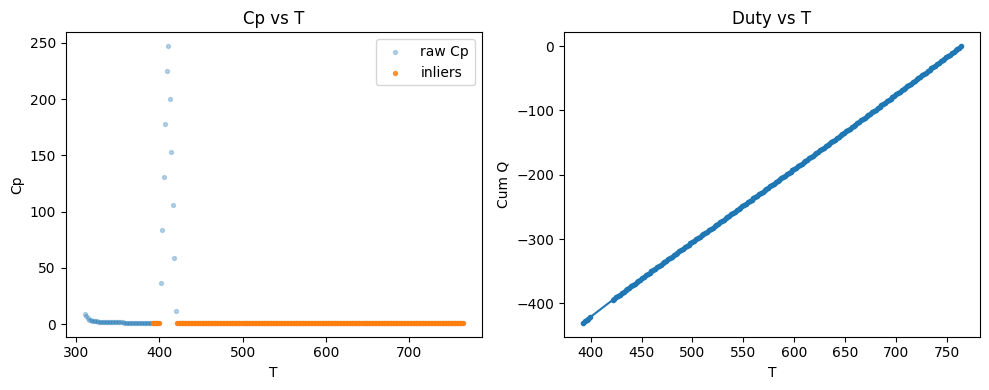

P exact: 20.000
interp T@20.000: 2.333±0.000
P exact: 20.000
interp T@20.000: 2.324±0.000
P exact: 20.000
interp T@20.000: 2.314±0.000
P exact: 20.000
interp T@20.000: 2.314±0.000
P exact: 20.000
interp T@20.000: 2.305±0.000
P exact: 20.000
interp T@20.000: 2.296±0.000
P exact: 20.000
interp T@20.000: 2.296±0.000
P exact: 20.000
interp T@20.000: 2.287±0.000
P exact: 20.000
interp T@20.000: 2.277±0.000
P exact: 20.000
interp T@20.000: 2.277±0.000
P exact: 20.000
interp T@20.000: 2.268±0.000
P exact: 20.000
interp T@20.000: 2.259±0.000
P exact: 20.000
interp T@20.000: 2.259±0.000
P exact: 20.000
interp T@20.000: 2.250±0.000
P exact: 20.000
interp T@20.000: 2.240±0.000
P exact: 20.000
interp T@20.000: 2.240±0.000
P exact: 20.000
interp T@20.000: 2.231±0.000
P exact: 20.000
interp T@20.000: 2.222±0.000
P exact: 20.000
interp T@20.000: 2.222±0.000
P exact: 20.000
interp T@20.000: 2.213±0.000
P exact: 20.000
interp T@20.000: 2.204±0.000
P exact: 20.000
interp T@20.000: 2.204±0.000
P exact: 2

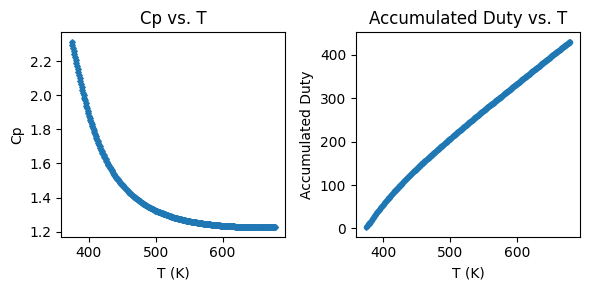

P exact: 20.000
interp T@20.000: 221.090±0.000
P exact: 20.000
interp T@20.000: 350.200±0.000
P exact: 20.000
interp T@20.000: -0.236±0.000
P exact: 20.000
interp T@20.000: 414.734±0.000
P exact: 20.000
interp T@20.000: 154.934±0.000
P exact: 20.000
interp T@20.000: 0.946±0.000
P exact: 20.000
interp T@20.000: 1.225±0.000


In [40]:
# Stream 4
from getDutynewfun import get_Duty_new
stream_num = 4; idx = stream_num - 1 
df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; 
P4, P4err = P4_d, 0;
P6, P6err, T6, T6err = df.loc[6-1,['P', 'Perr','T','Terr']];  T7, T7err = df.loc[7-1,['T','Terr']]; HEX_Duty, HEX_Dutyerr = get_Duty_new([P6, P6err], [T6, T6err], [T7, T7err], m_CO2info,Thermodata_filename); Q_recuped = HEX_Duty;
P3, P3err, T3, T3err = df.loc[3-1,['P','Perr','T','Terr']];T4, T4err = get_Tout([P3, P3err], [T3, T3err], [-1*HEX_Duty, HEX_Dutyerr],  m_CO2info,Thermodata_filename)
df.loc[idx, ['P','Perr','T','Terr']] = [P4, P4err, T4, T4err]
get_remaining_thermo_vars(idx, df, Thermodata_filename)

## Exergy Analysis

### Stream Exergy

In [41]:
df['ex'] = df['h'] - Ts * df['s']; df['exerr'] = np.sqrt(df['herr']**2 + (Ts * df['serr'])**2)
for idx, row in dfc.iterrows():
    start_val = row['Start_stream']; end_val   = row['End_stream']
    start_ex,     start_ex_err = get_solved_state(start_val, df, 'ex'); end_ex,       end_ex_err   = get_solved_state(end_val,   df, 'ex')
    change_ex, change_ex_err = subtract_fun(end_ex, end_ex_err, start_ex, start_ex_err)
    dfc.loc[idx, ['Start_ex', 'Start_ex_err','End_ex','End_ex_err','Change_ex','Change_ex_err']] = (start_ex, start_ex_err, end_ex, end_ex_err,change_ex, change_ex_err)

### Component Exergy Changes

Final T=873.000±0.000
Total Q=240.326131 ± 0.000000


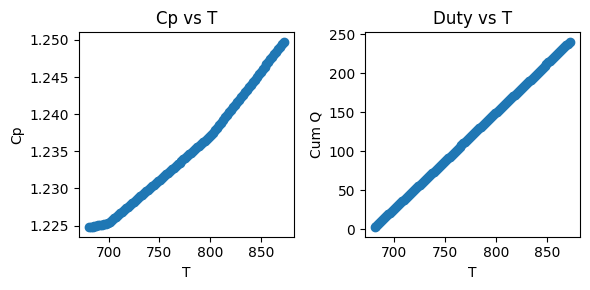

In [42]:
for idx, row in dfc.iterrows():
    start = row['Start_stream']; end = row['End_stream']
    for src_col, tgt_col, tgt_err_col in [('Fuel_exergy',    'EX_F',   'EX_F_err'),('Product_exergy', 'EX_P',   'EX_P_err')]:
        ex_type = str(row[src_col]).lower() 
        if ex_type == 'w':
            w, werr = W_fun(df, start, end); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = w, werr
        elif ex_type == 'q':
            q, qerr = Q_fun(df, start, end, m_CO2info, Thermodata_filename); dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = q, qerr
        elif ex_type == 'start_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Start_ex'], row['Start_ex_err']
        elif ex_type == 'end_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['End_ex'], row['End_ex_err']
        elif ex_type == 'change_ex':
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = row['Change_ex'], row['Change_ex_err']
        else:
            dfc.at[idx, tgt_col], dfc.at[idx, tgt_err_col] = np.nan, np.nan

In [43]:
cold_tube_num = dfc.index[dfc['Component'] == 'TUBE_T'][0]; hot_tube_num  = dfc.index[dfc['Component'] == 'TUBE_LS'][0]; hex_num = dfc.index[dfc['Component'] == 'HEX'][0]
hot_ex     = dfc.at[hot_tube_num, 'Change_ex']; hot_ex_err = dfc.at[hot_tube_num, 'Change_ex_err']; cold_ex    = dfc.at[cold_tube_num, 'Change_ex']; cold_ex_err= dfc.at[cold_tube_num, 'Change_ex_err']
dfc.loc[hex_num, ['EX_F','EX_F_err','EX_P','EX_P_err']] = [-hot_ex,-hot_ex_err, cold_ex, cold_ex_err]


In [44]:
for idx, row in dfc.iterrows():
    ex_d, ex_d_err = subtract_fun(abs(row['EX_F']), abs(row['EX_F_err']), abs(row['EX_P']), abs(row['EX_P_err']))
    if ex_d < 0:
        ex_d, ex_d_err = 0.0, ex_d_err
    dfc.loc[idx, ['EX_D', 'EX_D_err']] = (ex_d, ex_d_err)

mask_P = dfc['EX_P'].notna(); EX_P_T = abs(dfc.loc[mask_P, 'EX_P']).sum(); EX_P_T_err = np.sqrt((dfc.loc[mask_P, 'EX_P_err']**2).sum())

mask_F = dfc['EX_F'].notna(); EX_F_T = abs(dfc.loc[mask_F, 'EX_F']).sum(); EX_F_T_err = np.sqrt((dfc.loc[mask_F, 'EX_F_err']**2).sum())

mask_D = dfc['EX_D'].notna(); EX_D_T = abs(dfc.loc[mask_D, 'EX_D']).sum(); EX_D_T_err = np.sqrt((dfc.loc[mask_D, 'EX_D_err']**2).sum())

dfc.loc[mask_D, ['EX_D_ratio', 'EX_D_ratio_err']] = [divide_fun(d, de, EX_D_T, EX_D_T_err) for d, de in zip(dfc.loc[mask_D, 'EX_D'], dfc.loc[mask_D, 'EX_D_err'])]

In [45]:
W_C1   = abs(dfc.loc[dfc['Component']=='C1',  'EX_F'].iloc[0])
W_C    = W_C1 

In [46]:
W_T1   = abs(dfc.loc[dfc['Component']=='T1',  'EX_P'].iloc[0])
W_T    = W_T1

In [47]:
Q_HE   = abs(dfc.loc[dfc['Component']=='HE',  'EX_F'].iloc[0])
Q_F = Q_HE/eta_burner_Gulen

In [48]:
RTE_Liu = W_T/(W_C + eta_gen_avg*Q_HE)
RTE_Gulen = W_T/(W_C + eta_gen_avg*Q_F)
RTE_alt_F = (W_T-eta_gen_avg*Q_F)/W_C
RTE_alt_HE = (W_T-eta_gen_avg*Q_HE)/W_C

In [49]:
PEE = W_T/((W_C/eta_grid_avg) + Q_F)
ER = W_C/W_T
HR = W_T/Q_F

In [50]:
EXD_C    = dfc.loc[dfc['Component'].isin(['C1']), 'EX_D'].sum();   EXDR_C  = EXD_C/EX_D_T
EXD_T    = dfc.loc[dfc['Component'].isin(['T1']),   'EX_D'].sum();   EXDR_T  = EXD_T/EX_D_T
EXD_HS   = dfc.loc[dfc['Component'].isin(['HS']),  'EX_D'].sum();   EXDR_HS = EXD_HS/EX_D_T
EXD_LS   = dfc.loc[dfc['Component'].isin(['LS']),  'EX_D'].sum();   EXDR_LS = EXD_LS/EX_D_T
EXD_HE   = dfc.loc[dfc['Component'].isin(['HE']),       'EX_D'].sum();   EXDR_HE = EXD_HE/EX_D_T
EXD_HEX  = dfc.loc[dfc['Component'].isin(['HEX']),      'EX_D'].sum();   EXDR_HEX= EXD_HEX/EX_D_T

In [51]:
EX_EFF = EX_P_T/EX_F_T

## Storage Analysis

### HS Storage

In [52]:
# HS wells indexing
HS_num = dfc.index[dfc['Component'] == 'HS'][0]; HS_start = dfc['Start_stream'][HS_num]; HS_end = dfc['End_stream'][HS_num];
HS_inj_well = df.loc[df['Stream_#'] == HS_start]; HS_prod_well = df.loc[df['Stream_#'] == HS_end];

Interpolated in T at exact P=25.0 (Sheet: Sheet1)
  T bounds and viscosities: 380.0→43.9, 400.0→38.5
Temperature = 358.000 +/- 0.000 K at depth 3000.0 +/- 0.0 m
P interp bounds: 30.000,40.000
interp T@38.000: 725.036±0.000
interp T@38.000: 806.928±0.000
→ 790.550±0.000
P exact: 40.000
interp T@40.000: 806.928±0.000
P interp bounds: 40.000,50.000
interp T@45.539: 806.928±0.000
interp T@45.539: 861.776±0.000
→ 837.307±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 806.928±0.000
interp T@45.299: 861.776±0.000
→ 835.992±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 806.928±0.000
interp T@45.299: 861.776±0.000
→ 835.992±0.000
Final iteration results:
  P_guess     = 45.299052 MPa
  P_calc      = 45.299052 MPa
  Error       = -7.11e-15 MPa
  rho_bottom  = 835.992239 kg/m³
  rho_avg     = 689.743515 kg/m³


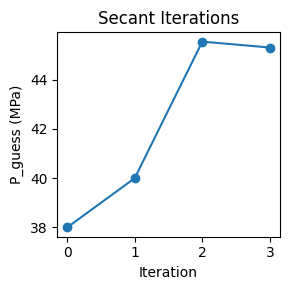

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=45.0: T=340.0→90.06, T=360.0→77.85
    P=50.0: T=340.0→95.21, T=360.0→82.77
  Final interpolation at P=45.29905165421793, T=358.0: 79.36664246535985
P interp bounds: 40.000,50.000
interp T@45.299: -205.522±0.000
interp T@45.299: -217.848±0.000
→ -212.054±0.000
P interp bounds: 40.000,50.000
interp T@45.299: -155.936±0.000
interp T@45.299: -159.818±0.000
→ -157.993±0.000
P interp bounds: 40.000,50.000
interp T@45.299: -1.392±0.000
interp T@45.299: -1.436±0.000
→ -1.415±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 563.246±0.000
interp T@45.299: 641.746±0.000
→ 604.844±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 806.928±0.000
interp T@45.299: 861.776±0.000
→ 835.992±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 0.903±0.000
interp T@45.299: 0.905±0.000
→ 0.904±0.000
P interp bounds: 40.000,50.000
interp T@45.299: 1.852±0.000
interp T@45.299: 1.748±0.000
→ 1.797±0.000
Interpolate

In [53]:
# HS injection well
P_HS_inj = HS_inj_well['P'].iloc[0]; T_HS_inj = HS_inj_well['T'].iloc[0];
p_HS_inj = HS_inj_well['p'].iloc[0]; vis_HS_inj = get_vis(P = P_HS_inj, T = T_HS_inj, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_inj = vis_HS_inj*(1e-6)

# HS 
T_HS, T_HSerr = get_T_from_depth(z_HS, 0, Ts, G)
P_HS, pavg_HS_inj, p_HS = find_P_bottom_secant(T_aquifer=T_HS,z_aquifer=z_HS,Ptop=P_HS_inj,g=g,fric_rate=gradP, rho_top=p_HS_inj, thermo_file=Thermodata_filename, P0=38.0, P1=40.0, tol=1e-6,max_iter=500)
vis_HS = get_vis(P = P_HS, T = T_HS, near_critical_point = 'N',filename= f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS = vis_HS*(1e-6); visavg_HS_inj = 0.5*(vis_HS_inj + vis_HS)
n_rows = df.shape[0];idx = n_rows; df.loc[idx,['Definer_1','Definer_2']] = ['P','T']; df.loc[idx, ['P','Perr','T','Terr']] = [P_HS, 0, T_HS, 0]; get_remaining_thermo_vars(idx, df, Thermodata_filename); 
df.loc[idx,['Stream_#','From_component', 'To_component']] = [HS_start+0.5, 'HS_inj_well', 'HS_prod_well'];

# HS production well
P_HS_prod = HS_prod_well['P'].iloc[0]; T_HS_prod = HS_prod_well['T'].iloc[0]; p_HS_prod = HS_prod_well['p'].iloc[0]; vis_HS_prod = get_vis(P = P_HS_prod, T = T_HS_prod, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_HS_prod = vis_HS_prod*(1e-6)
pavg_HS_prod = 0.5*(p_HS_prod + p_HS); visavg_HS_prod = 0.5*(vis_HS_prod + vis_HS)

### LS Storage

In [54]:
# LS wells indexing
LS_num = dfc.index[dfc['Component'] == 'LS'][0]; LS_start = dfc['Start_stream'][LS_num]; LS_end = dfc['End_stream'][LS_num];
LS_inj_well = df.loc[df['Stream_#'] == LS_start]; LS_prod_well = df.loc[df['Stream_#'] == LS_end];

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=7.5: T=300.0→60.47, T=320.0→19.78
    P=10.0: T=300.0→71.13, T=320.0→32.58
  Final interpolation at P=8.04, T=310.22214038931975: 42.21186948660693
Temperature = 302.000 +/- 0.000 K at depth 760.0 +/- 0.0 m
P exact: 3.000
interp T@3.000: 62.648±0.000
P exact: 1.000
interp T@1.000: 18.436±0.000
P interp bounds: 10.000,15.000
interp T@10.094: 781.640±0.000
interp T@10.094: 853.684±0.000
→ 782.991±0.000
P interp bounds: 10.000,15.000
interp T@13.153: 781.640±0.000
interp T@13.153: 853.684±0.000
→ 827.077±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 781.640±0.000
interp T@12.314: 853.684±0.000
→ 814.978±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 781.640±0.000
interp T@12.314: 853.684±0.000
→ 814.978±0.000
Final iteration results:
  P_guess     = 12.313701 MPa
  P_calc      = 12.313701 MPa
  Error       = 1.78e-15 MPa
  rho_bottom  = 814.977661 kg/m³
  rho_avg     = 573.233735 kg/m³


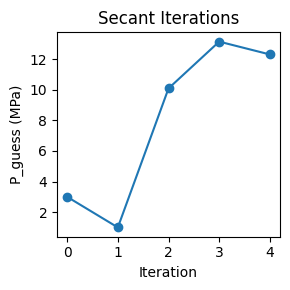

Interpolated in P and T (Sheet: Sheet1)
  P bounds and viscosities at T bounds:
    P=10.0: T=300.0→71.13, T=320.0→32.58
    P=12.5: T=300.0→78.09, T=320.0→51.13
  Final interpolation at P=12.313701433664695, T=302.0: 74.78897677596947
P interp bounds: 10.000,15.000
interp T@12.314: -251.376±0.000
interp T@12.314: -266.960±0.000
→ -258.587±0.000
P interp bounds: 10.000,15.000
interp T@12.314: -238.564±0.000
interp T@12.314: -249.388±0.000
→ -243.573±0.000
P interp bounds: 10.000,15.000
interp T@12.314: -1.528±0.000
interp T@12.314: -1.584±0.000
→ -1.554±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 393.772±0.000
interp T@12.314: 503.668±0.000
→ 444.625±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 781.640±0.000
interp T@12.314: 853.684±0.000
→ 814.978±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 0.957±0.000
interp T@12.314: 0.925±0.000
→ 0.942±0.000
P interp bounds: 10.000,15.000
interp T@12.314: 3.183±0.000
interp T@12.314: 2.397±0.000
→ 2.819±0.000
Interpolat

In [55]:
# LS injection well
P_LS_inj = LS_inj_well['P'].iloc[0]; T_LS_inj = LS_inj_well['T'].iloc[0];
p_LS_inj = LS_inj_well['p'].iloc[0]; vis_LS_inj = get_vis(P = P_LS_inj, T = T_LS_inj, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS_inj = vis_LS_inj*(1e-6)

# LS
T_LS, T_LSerr = get_T_from_depth(z_LS, 0, Ts, G)
P_LS, pavg_LS_inj, p_LS = find_P_bottom_secant(T_aquifer=T_LS,z_aquifer=z_LS,Ptop=P_LS_inj,g=g,fric_rate=gradP, rho_top=p_LS_inj, thermo_file=Thermodata_filename, P0=3, P1=1, tol=1e-6,max_iter=500)
vis_LS = get_vis(P = P_LS, T = T_LS, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS = vis_LS*(1e-6); visavg_LS_inj = 0.5*(vis_LS_inj + vis_LS)
n_rows = df.shape[0];idx = n_rows; df.loc[idx,['Definer_1','Definer_2']] = ['P','T'];  df.loc[idx, ['P','Perr','T','Terr']] = [P_LS, 0, T_LS, 0]; get_remaining_thermo_vars(idx, df, Thermodata_filename); 
df.loc[idx,['Stream_#','From_component', 'To_component']] = [LS_start+0.5, 'LS_inj_well', 'LS_prod_well'];

# LS production well
P_LS_prod = LS_prod_well['P'].iloc[0]; T_LS_prod = HS_prod_well['T'].iloc[0]; p_LS_prod = LS_prod_well['p'].iloc[0]; vis_LS_prod = get_vis(P = P_LS_prod, T = T_LS_prod, near_critical_point = 'N', filename=f'../Input_Spreadsheets/Viscositydata_{Working_fluid}'); vis_LS_prod = vis_LS_prod*(1e-6)
pavg_LS_prod = 0.5*(p_LS_prod + p_LS); visavg_LS_prod = 0.5*(vis_LS_prod + vis_LS)

## Frictional Analysis

### HS Injection Well

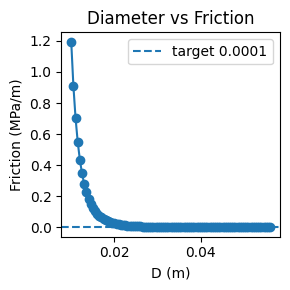

Final diameter: 0.056000 m
Final friction: 0.000100 MPa/m


In [56]:
D0_HS_inj_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mass_rate=m_CO2,mu_avg=visavg_HS_inj,D_guess=0.01,roughness=0.001, D_step=0.0005)
dfDm_HS_inj_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_inj,mu_avg=visavg_HS_inj,D_start=0.01,roughness=r, D_step=0.0005)

### HS Production Well

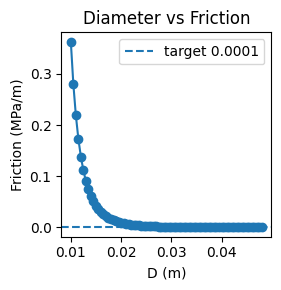

Final diameter: 0.048000 m
Final friction: 0.000097 MPa/m


In [57]:
D0_HS_prod_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mass_rate=m_CO2,mu_avg=visavg_HS_prod,D_guess=0.01,roughness=r, D_step=0.0005)
dfDm_HS_prod_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_HS_prod,mu_avg=visavg_HS_prod,D_start=0.01,roughness=r, D_step=0.0005)

### LS Injection Well

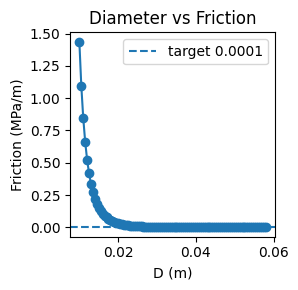

Final diameter: 0.058000 m
Final friction: 0.000099 MPa/m


In [58]:
D0_LS_inj_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_inj,mass_rate=m_CO2,mu_avg=visavg_LS_inj,D_guess=0.01,roughness=0.001, D_step=0.0005)
dfDm_LS_inj_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_inj,mu_avg=visavg_LS_inj,D_start=0.01,roughness=r, D_step=0.0005)

### LS Production Well

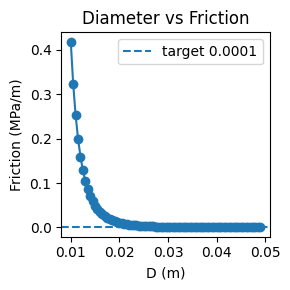

Final diameter: 0.049000 m
Final friction: 0.000100 MPa/m


In [59]:
D0_LS_prod_well = find_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_prod,mass_rate=m_CO2,mu_avg=visavg_LS_prod,D_guess=0.01,roughness=r, D_step=0.0005)
dfDm_LS_prod_well = batch_opt_pipe_diameter(friction_rate=gradP,rho_avg=pavg_LS_prod,mu_avg=visavg_LS_prod,D_start=0.01,roughness=r, D_step=0.0005)

## Quasi-Steady-State Analysis

In [60]:
# Steady state parameters
P_HS_ss = P_HS; p_HS_ss = p_HS; P_LS_ss = P_LS; p_LS_ss = p_LS; 

In [61]:
#Dispatch parameters
PPA = Nameplate_capacity*CF_avg; #PPA derated by mean capacity factor of wind farm
beta_w_MPa = beta_w*(1e6); beta_p_MPa = beta_p*(1e6) #Pa-1 to MPa-1
SystemPrices_arr = SystemPrices_arr*0.001; #£/MWh to £/kWh
CapacityFactors_arr = np.repeat(hourly_cf, 2); assert CapacityFactors_arr.shape[0] == 48, "Expected 48 half‐hourly capacity factors"; #Capacity factor per settlement period
Generation_arr = Nameplate_capacity*CapacityFactors_arr #Generation per settlement period kW

In [62]:
# Full-cycle pressure swing 
M = PPA/min(W_T,W_C)
deltaP_HS_full_cycle = tol_P_storage*P_HS_ss*(1e6); V_HS = M/(deltaP_HS_full_cycle * p_HS_ss * (beta_p + beta_w)); V_HS_ss = V_HS;
deltaP_LS_full_cycle = tol_P_storage*P_LS_ss*(1e6); V_LS = M/(deltaP_LS_full_cycle * p_LS_ss * (beta_p + beta_w)); V_LS_ss = V_LS;
E_V =0.5*W_T*(beta_p + beta_w)*(p_LS_ss*deltaP_LS_full_cycle + p_HS_ss*deltaP_HS_full_cycle)

In [63]:
initialconditions, timeseries = operate_geobattery(
    Vrock_LS                = Vrock_LS,                  # m³ rock in LS
    Vrock_HS                = Vrock_HS,                  # m³ rock in HS
    phi                     = por,                   # porosity (−)
    b_pore                  = beta_p_MPa,                   # rock compressibility (1/MPa)
    b_brine                 = beta_w_MPa,                  # brine compressibility (1/MPa)
    z_LS                    = z_LS,                  # m depth of LS
    z_HS                    = z_HS,                 # m depth of HS
    P_LS_ss                 = P_LS_ss,                    # MPa steady LS pressure
    P_HS_ss                 = P_HS_ss,                   # MPa steady HS pressure
    rho_co2_LS_ss           = p_LS_ss,                  # kg/m³ CO₂ @ 2 MPa
    rho_co2_HS_ss           = p_HS_ss,                  # kg/m³ CO₂ @ 40 MPa
    rho_brine_0             = p_w,                 # kg/m³ surface brine density
    T_LS                    = T_LS,                 # K reservoir temperature LS
    T_HS                    = T_HS,                 # K reservoir temperature HS
    thermo_file             = Thermodata_filename,         # path to EOS file
    stable_power_requirement= PPA,                  # kW constant load
    W_turbine_T             = W_T,                    # kWh per kg CO₂ through turbine
    W_compressor_T          = W_C,                    # kWh per kg CO₂ through compressor
    power_rating            = PPA,                 # kW max charge/discharge
    dt                      = 1.0,                    # hr per timestep
    price                   = SystemPrices_arr,    # $/kWh
    generation              = Generation_arr,# kW available
    pressure_tolerance      = tol_P_storage,                  # ±1.5% allowable swing
    pressure_buffer_fraction= 0.25                    # buffer fraction
)

dfQSS = pd.DataFrame(timeseries)
dfQSS0 = pd.DataFrame(initialconditions)

In [64]:
dfQSS.columns

Index(['mode', 'residual', 'charge', 'charge_mass_co2',
       'pressure_constraint_mass_co2', 'power_constraint', 'deltaM_co2_LS',
       'deltaM_co2_HS', 'M_co2_LS', 'M_co2_HS', 'M_br_LS', 'M_br_HS',
       'pore_gain_LS', 'pore_gain_HS', 'extra_cap_LS', 'extra_cap_HS',
       'brine_shrink_LS', 'brine_shrink_HS', 'Vp_LS', 'Vp_HS', 'V_LS_co2',
       'V_HS_co2', 'Vbr_LS', 'Vbr_HS', 'volfrac_LS_co2', 'volfrac_HS_co2',
       'volfrac_LS_br', 'volfrac_HS_br', 'massfrac_LS_co2', 'massfrac_HS_co2',
       'massfrac_LS_br', 'massfrac_HS_br', 'deltaV_LS_br', 'deltaV_HS_br',
       'P_LS', 'P_HS', 'diffP_LS', 'diffP_HS', 'QSS_P_drift_LS',
       'QSS_P_drift_HS', 'errorP_LS', 'errorP_HS', 'purchase', 'sale',
       'revenue', 'expense', 'cashflow', 'balance', 'generation', 'demand',
       'price', 'rho_co2_LS', 'rho_co2_HS', 'rho_br_LS', 'rho_br_HS', 'b_eff',
       'residual_mass', 'constraint',
       'reservoir_responsible_pressure_constraint'],
      dtype='object')

# Outputs

In [65]:
from pathlib import Path
project_root = Path.cwd().parent  
base_dir  = project_root / simulation_name
data_dir  = base_dir / f"{simulation_name}_data"
fig_dir   = base_dir / f"{simulation_name}_figures"
for d in (base_dir, data_dir, fig_dir):
    d.mkdir(parents=True, exist_ok=True)
print(f"Results folders for simulation created: {base_dir}")

Results folders for simulation created: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\OXF-Dissertation-Simulation-SCCES - Copy\SCCESModelCalibration


## Spreadsheet Writing

In [66]:
data_dir.mkdir(parents=True, exist_ok=True)

### KPIs

In [67]:
metrics = {'W_C1':    W_C1,  'W_C':    W_C,
           'W_T1':    W_T1, 'W_T':     W_T,
           'Q_HE':    Q_HE, 'Q_F': Q_F,
           'RTE_Liu':     RTE_Liu,    'RTE_Gulen': RTE_Gulen, 'RTE_alt_F': RTE_alt_F, 'RTE_alt_HE': RTE_alt_HE,
           'PEE': PEE, 
           'ER': ER, 'HR': HR,
           'EXDR_C':  EXDR_C, 'EXDR_T':  EXDR_T, 'EXDR_HS': EXDR_HS,  'EXDR_LS': EXDR_LS, 'EXDR_HE': EXDR_HE,'EXDR_HEX': EXDR_HEX,
           'EX_F_T': EX_F_T, 'EX_P_T': EX_P_T, 'EX_D_T': EX_D_T, 'EX_EFF': EX_EFF,
           
           'P_HS_ss': P_HS_ss, 'T_HS' : T_HS, 'p_HS_ss': p_HS_ss,'V_HS_ss': V_HS,
           'P_LS_ss': P_HS_ss, 'T_LS' : T_LS,'p_LS_ss' : p_LS_ss,'V_LS_ss' : V_LS,
           'deltaP_HS_fullcycle': deltaP_HS_full_cycle, 'deltaP_LS_fullcycle': deltaP_HS_full_cycle, 'E_V': E_V,
           
           'p_HS_inj_avg': pavg_HS_inj, 'vis_HS_inj_avg': visavg_HS_inj, 'HS_inj_drop': gradP*z_HS, 'HS_inj_D0': D0_HS_inj_well,
           'p_LS_inj_avg': pavg_LS_inj, 'vis_LS_inj_avg': visavg_LS_inj, 'LS_inj_drop': gradP*z_LS, 'LS_inj_D0': D0_LS_inj_well,

           'max_purchase': dfQSS['purchase'].max(), 'max_purchase_hr': dfQSS['purchase'].idxmax(),
           'min_purchase': dfQSS['purchase'].min(), 'min_purchase_hr': dfQSS['purchase'].idxmin(),
           'max_cashflow': dfQSS['cashflow'].max(), 'max_cashflow_hr': dfQSS['cashflow'].idxmax(),
           'min_cashflow': dfQSS['cashflow'].min(), 'min_cashflow_hr': dfQSS['cashflow'].idxmin(),
           'max_balance': dfQSS['balance'].max(), 'max_balance_hr': dfQSS['balance'].idxmax(),
           'min_balance': dfQSS['balance'].min(), 'min_balance_hr': dfQSS['balance'].idxmin(),
           'max_charge': dfQSS['charge'].max(), 'max_charge_hr': dfQSS['charge'].idxmax(),
           'max_discharge': abs(dfQSS['charge'].min()), 'max_discharge_hr': dfQSS['charge'].idxmin(),
           'max_charge_mass_co2': dfQSS['charge_mass_co2'].max(), 'max_charge_hr': dfQSS['charge_mass_co2'].idxmax(),
           'max_discharge_mass_co2': abs(dfQSS['charge_mass_co2'].min()), 'max_discharge_hr': dfQSS['charge_mass_co2'].idxmin(),
           'max_P_HS_deviation': dfQSS['diffP_HS'].max(), 'max_P_HS_deviation_hr': dfQSS['diffP_HS'].idxmax(),
           'max_P_LS_deviation': dfQSS['diffP_LS'].max(), 'max_P_LS_deviation_hr': dfQSS['diffP_LS'].idxmax(),
           'most_frequent_constraint':dfQSS['constraint'].value_counts().idxmax(),
           'max_HS_brine_content': dfQSS['Vbr_HS'].max(), 'max_HS_brine_content_hr': dfQSS['Vbr_HS'].idxmax(),
           'max_LS_brine_content': dfQSS['Vbr_LS'].max(), 'max_LS_brine_content_hr': dfQSS['Vbr_LS'].idxmax()
}
dfKPI = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']); dfKPI.index.name = 'Metric'
dfKPI.to_excel(data_dir / f"{simulation_name}_dfKPI.xlsx", index=True )

### Streams

In [68]:
df = select_value_columns(df)
df.to_excel(   data_dir / f"{simulation_name}_df.xlsx",     index=False )

### Components

In [69]:
dfc = select_value_columns(dfc)
dfc.to_excel(  data_dir / f"{simulation_name}_dfc.xlsx",    index=False )

### Wells

In [70]:
dfDm_HS_inj_well = select_value_columns(dfDm_HS_inj_well); dfDm_HS_inj_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_inj")
dfDm_HS_prod_well = select_value_columns(dfDm_HS_prod_well); dfDm_HS_prod_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "HS_prod")
dfDm_LS_inj_well = select_value_columns(dfDm_LS_inj_well); dfDm_LS_inj_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "LS_inj")
dfDm_LS_prod_well = select_value_columns(dfDm_LS_prod_well); dfDm_LS_prod_well.to_excel(data_dir/f"{simulation_name}_wells.xlsx",index=False, sheet_name = "LS_prod")

### Dispatch

In [71]:
dftransient = select_value_columns(dfQSS)
dftransient.to_excel(  data_dir / f"{simulation_name}_dfQSS.xlsx", index=False )

## Data Display

In [72]:
print(f"df, dfc, and dfKPI, data saved to: {data_dir}")

df, dfc, and dfKPI, data saved to: C:\Users\Sunshine Tanphiphat\OneDrive\Desktop\OXF-Dissertation-Simulation-SCCES - Copy\SCCESModelCalibration\SCCESModelCalibration_data


In [73]:
display(select_value_columns(dfKPI))

Value
Metric                                
W_C1                          45.53345
W_C                           45.53345
W_T1                        122.921271
W_T                         122.921271
Q_HE                        240.326131
...                                ...
most_frequent_constraint      residual
max_HS_brine_content      27218.527573
max_HS_brine_content_hr             39
max_LS_brine_content      27413.650198
max_LS_brine_content_hr             47

[69 rows x 1 columns]

In [74]:
display(select_value_columns(df))

Stream_# Orientation From_component  To_component Definer_1 Definer_2  \
0       1.0  Horizontal             LS            C1         P         T   
1       2.0    Vertical             C1            HS         P         h   
2       3.0    Vertical             HS           HEX         P         h   
3       4.0  Horizontal            HEX            HE         P         T   
4       5.0  Horizontal             HE            T1         P         T   
5       6.0  Horizontal             T1           HEX         P         h   
6       7.0    Vertical            HEX            LS         P         h   
7       2.5         NaN    HS_inj_well  HS_prod_well         P         T   
8       7.5         NaN    LS_inj_well  LS_prod_well         P         T   

           P           T           e           h         s           v  \
0   7.540000  307.830000 -150.118049 -125.494415 -1.146226  191.512508   
1  25.000000  383.567612 -126.022408  -79.960966 -1.128485  359.086551   
2  20.000000  373.507257 -121.734791  -79.960966 -1.102730  314.912805   
3  20.000000  678.413146  221.090416  350.200422 -0.236019  414.733536   
4  20.000000  873.000000  419.370400  590.598800  0.073794  469.690900   
5   8.040000  764.170761  322.355791  467.677529  0.098256  423.247368   
6   8.040000  310.222140 -149.838367 -125.494415 -1.150980  195.235662   
7  45.299052  358.000000 -212.053611 -157.993092 -1.415315  604.843555   
8  12.313701  302.000000 -258.587345 -243.572701 -1.554236  444.625307   

            p        Cv         Cp          ex  
0  325.230690  1.235529  30.018362  198.887511  
1  543.494792  0.902667   2.117499  239.400335  
2  479.845282  0.906592   2.332821  232.111728  
3  154.934390  0.946205   1.224696  416.993838  
4  117.171000  1.015076   1.249775  569.715183  
5   55.555501  0.970421   1.187075  439.871214  
6  331.489809  1.146985   9.498555  200.232976  
7  835.992239  0.903843   1.796841         NaN  
8  814.977661  0.942226   2.819058         NaN

In [75]:
display(select_value_columns(dfc))

Component       Equipment_Type Start_stream End_stream  \
0        C1           Compressor            1          2   
1        HS           HS_Storage            2          3   
2    TUBE_T  Heat_exchanger_tube            3          4   
3        HE               Heater            4          5   
4        T1              Turbine            5          6   
5   TUBE_LS  Heat_exchanger_tube            6          7   
6        LS           LS_Storage            7          1   
7       HEX       Heat_exchanger          3,6        4,7   

            Fuel_exergy   Product_exergy        EX_F        EX_P       EX_D  \
0                     W        Change_ex   45.533450   40.512824   5.020626   
1              Start_ex           End_ex  239.400335  232.111728   7.288607   
2                   NaN              NaN         NaN         NaN        NaN   
3                     Q        Change_ex  240.326131  152.721345  87.604786   
4             Change_ex                W -129.843969 -122.921271   6.922698   
5                   NaN              NaN         NaN         NaN        NaN   
6              Start_ex           End_ex  200.232976  198.887511   1.345465   
7  neg_Change_e_TUBE_LS  Change_e_TUBE_T  239.638238  184.882110  54.756129   

     Start_ex      End_ex   Change_ex  EX_D_ratio  
0  198.887511  239.400335   40.512824    0.030813  
1  239.400335  232.111728   -7.288607    0.044732  
2  232.111728  416.993838  184.882110         NaN  
3  416.993838  569.715183  152.721345    0.537656  
4  569.715183  439.871214 -129.843969    0.042487  
5  439.871214  200.232976 -239.638238         NaN  
6  200.232976  198.887511   -1.345465    0.008258  
7         NaN         NaN         NaN    0.336054

In [76]:
display(select_value_columns(dfQSS))

mode  residual   charge  charge_mass_co2  \
0   discharge   -5075.0  -5075.0        41.286589   
1   discharge   -5075.0  -5075.0        41.286589   
2   discharge    -875.0   -875.0         7.118377   
3   discharge    -875.0   -875.0         7.118377   
4      charge    3125.0   3125.0        68.630864   
5      charge    3125.0   3125.0        68.630864   
6      charge    6625.0   6625.0       145.497433   
7      charge    6625.0   6625.0       145.497433   
8      charge    8125.0   8125.0       178.440247   
9      charge    8125.0   8125.0       178.440247   
10     charge    2625.0   2625.0        57.649926   
11     charge    2625.0   2625.0        57.649926   
12     charge     525.0    525.0        11.529985   
13     charge     525.0    525.0        11.529985   
14  discharge   -2175.0  -2175.0        17.694252   
15  discharge   -2175.0  -2175.0        17.694252   
16  discharge   -6275.0  -6275.0        51.048935   
17  discharge   -6275.0  -6275.0        51.048935   
18  discharge   -8375.0  -8375.0        68.133041   
19  discharge   -8375.0  -8375.0        68.133041   
20  discharge   -9575.0  -9575.0        77.895387   
21  discharge   -9575.0  -9575.0        77.895387   
22  discharge  -10175.0 -10175.0        82.776560   
23  discharge  -10175.0 -10175.0        82.776560   
24  discharge  -10375.0 -10375.0        84.403618   
25  discharge  -10375.0 -10375.0        84.403618   
26  discharge  -10575.0 -10575.0        86.030676   
27  discharge  -10575.0 -10575.0        86.030676   
28  discharge  -10775.0 -10775.0        87.657733   
29  discharge  -10775.0 -10775.0        87.657733   
30  discharge  -11375.0 -11375.0        92.538906   
31  discharge  -11375.0 -11375.0        92.538906   
32  discharge  -12575.0 -12575.0       102.301253   
33  discharge  -12575.0 -12575.0       102.301253   
34  discharge  -13475.0 -13475.0       109.623012   
35  discharge  -13475.0 -13475.0       109.623012   
36  discharge  -11375.0 -11375.0        92.538906   
37  discharge  -11375.0 -11375.0        92.538906   
38  discharge   -2075.0  -2075.0        16.880724   
39  discharge   -2075.0  -2075.0        16.880724   
40     charge   12925.0  12925.0       283.857255   
41     charge   12925.0  12925.0       283.857255   
42     charge   25325.0  20175.0       443.080860   
43     charge   25325.0  20175.0       443.080860   
44     charge   31425.0  20175.0       443.080860   
45     charge   31425.0  20175.0       443.080860   
46     charge   34425.0  20175.0       443.080860   
47     charge   34425.0  20175.0       443.080860   

    pressure_constraint_mass_co2  power_constraint  deltaM_co2_LS  \
0                    1382.691536           20175.0      41.286589   
1                    1393.071952           20175.0      41.286589   
2                    1403.452803           20175.0       7.118377   
3                    1405.242681           20175.0       7.118377   
4                    1358.625857           20175.0     -68.630864   
5                    1375.687760           20175.0     -68.630864   
6                    1392.748445           20175.0    -145.497433   
7                    1428.914499           20175.0    -145.497433   
8                    1465.075078           20175.0    -178.440247   
9                    1509.416230           20175.0    -178.440247   
10                   1553.749139           20175.0     -57.649926   
11                   1568.069426           20175.0     -57.649926   
12                   1582.388852           20175.0     -11.529985   
13                   1585.252566           20175.0     -11.529985   
14                   1174.914234           20175.0      17.694252   
15                   1179.359237           20175.0      17.694252   
16                   1183.804321           20175.0      51.048935   
17                   1196.628872           20175.0      51.048935   
18                   1209.454091           20175.0      68.133041   
19                   1226.57230

## Visualizations

In [77]:
fig_dir.mkdir(parents=True, exist_ok=True);
figsize_std = (5, 5);
plt.rcParams['font.family']      = 'serif'; plt.rcParams['font.serif']       = ['Times New Roman']; 
plt.rcParams['mathtext.fontset'] = 'stix'; plt.rcParams['mathtext.rm']      = 'Times New Roman'; plt.rcParams['mathtext.bf']      = 'Times New Roman:bold'; plt.rcParams['mathtext.it']      = 'Times New Roman:italic'
plt.rcParams['axes.titlesize']   = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize']   = 11; plt.rcParams['xtick.labelsize']  = 10; plt.rcParams['ytick.labelsize']  = 10; plt.rcParams['legend.fontsize']  = 8

### KPI Visualizations

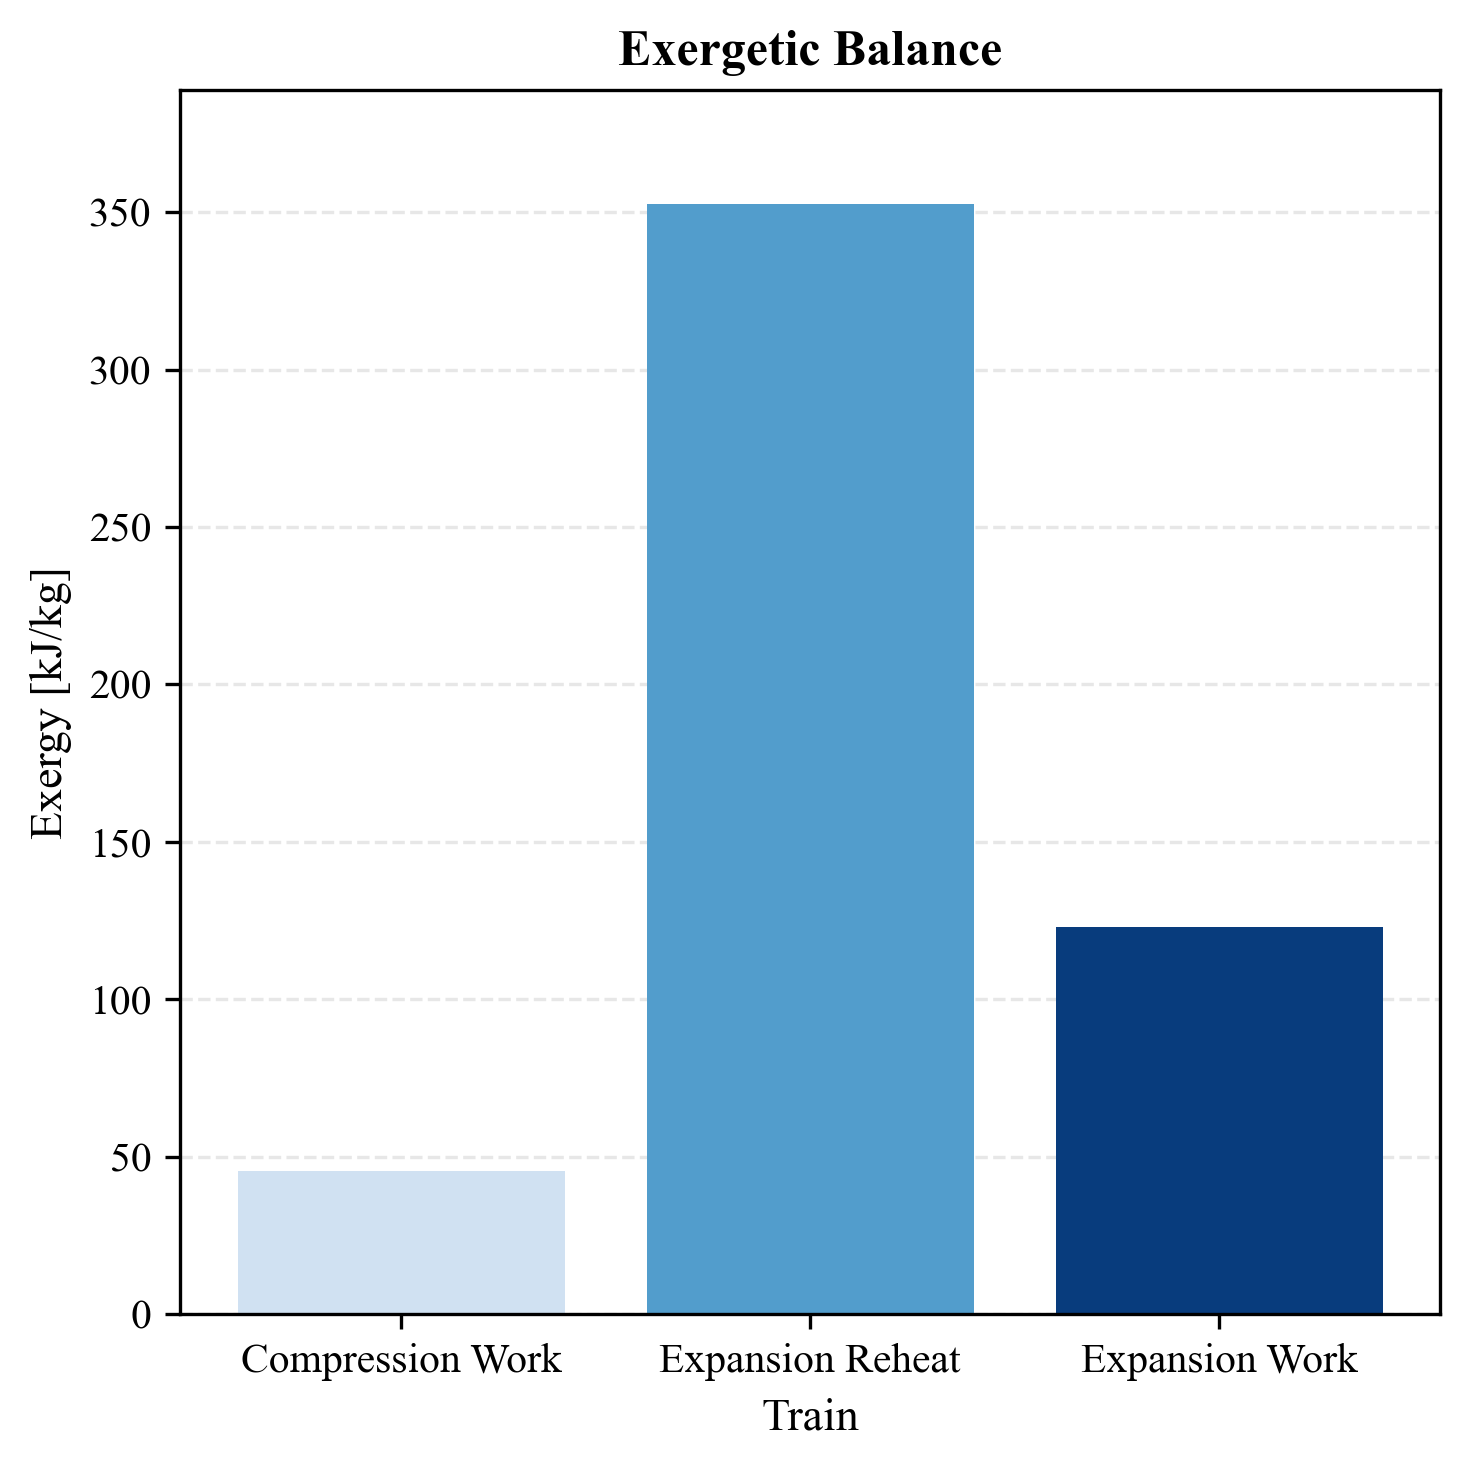

In [78]:
Figure_title = 'Exergetic Balance'

kpis = ['Compression Work', 'Expansion Reheat', 'Expansion Work']
y_data = [W_C, Q_F, W_T]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Train'); ax.set_ylabel('Exergy [kJ/kg]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

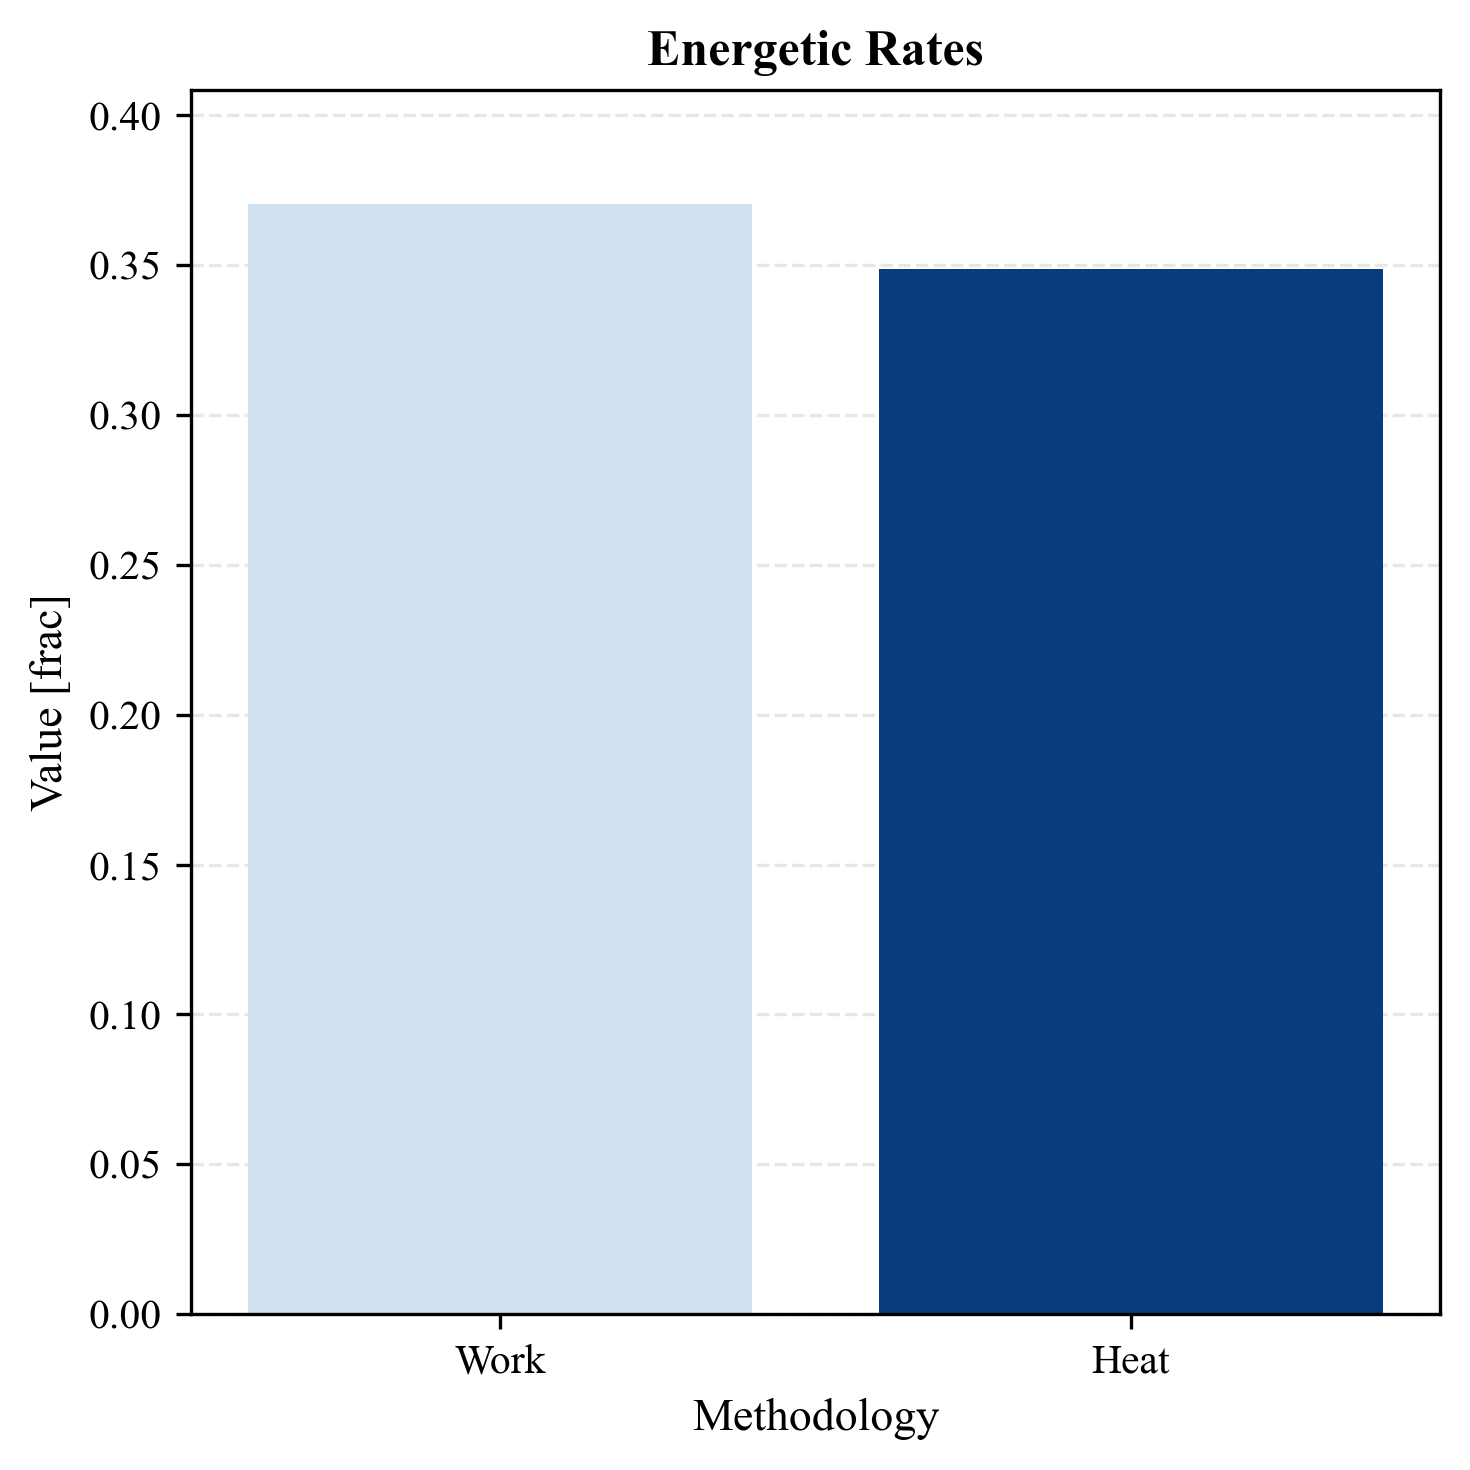

In [79]:
Figure_title = 'Energetic Rates'

kpis = ['Work', 'Heat']
y_data = [ER, HR]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Value [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

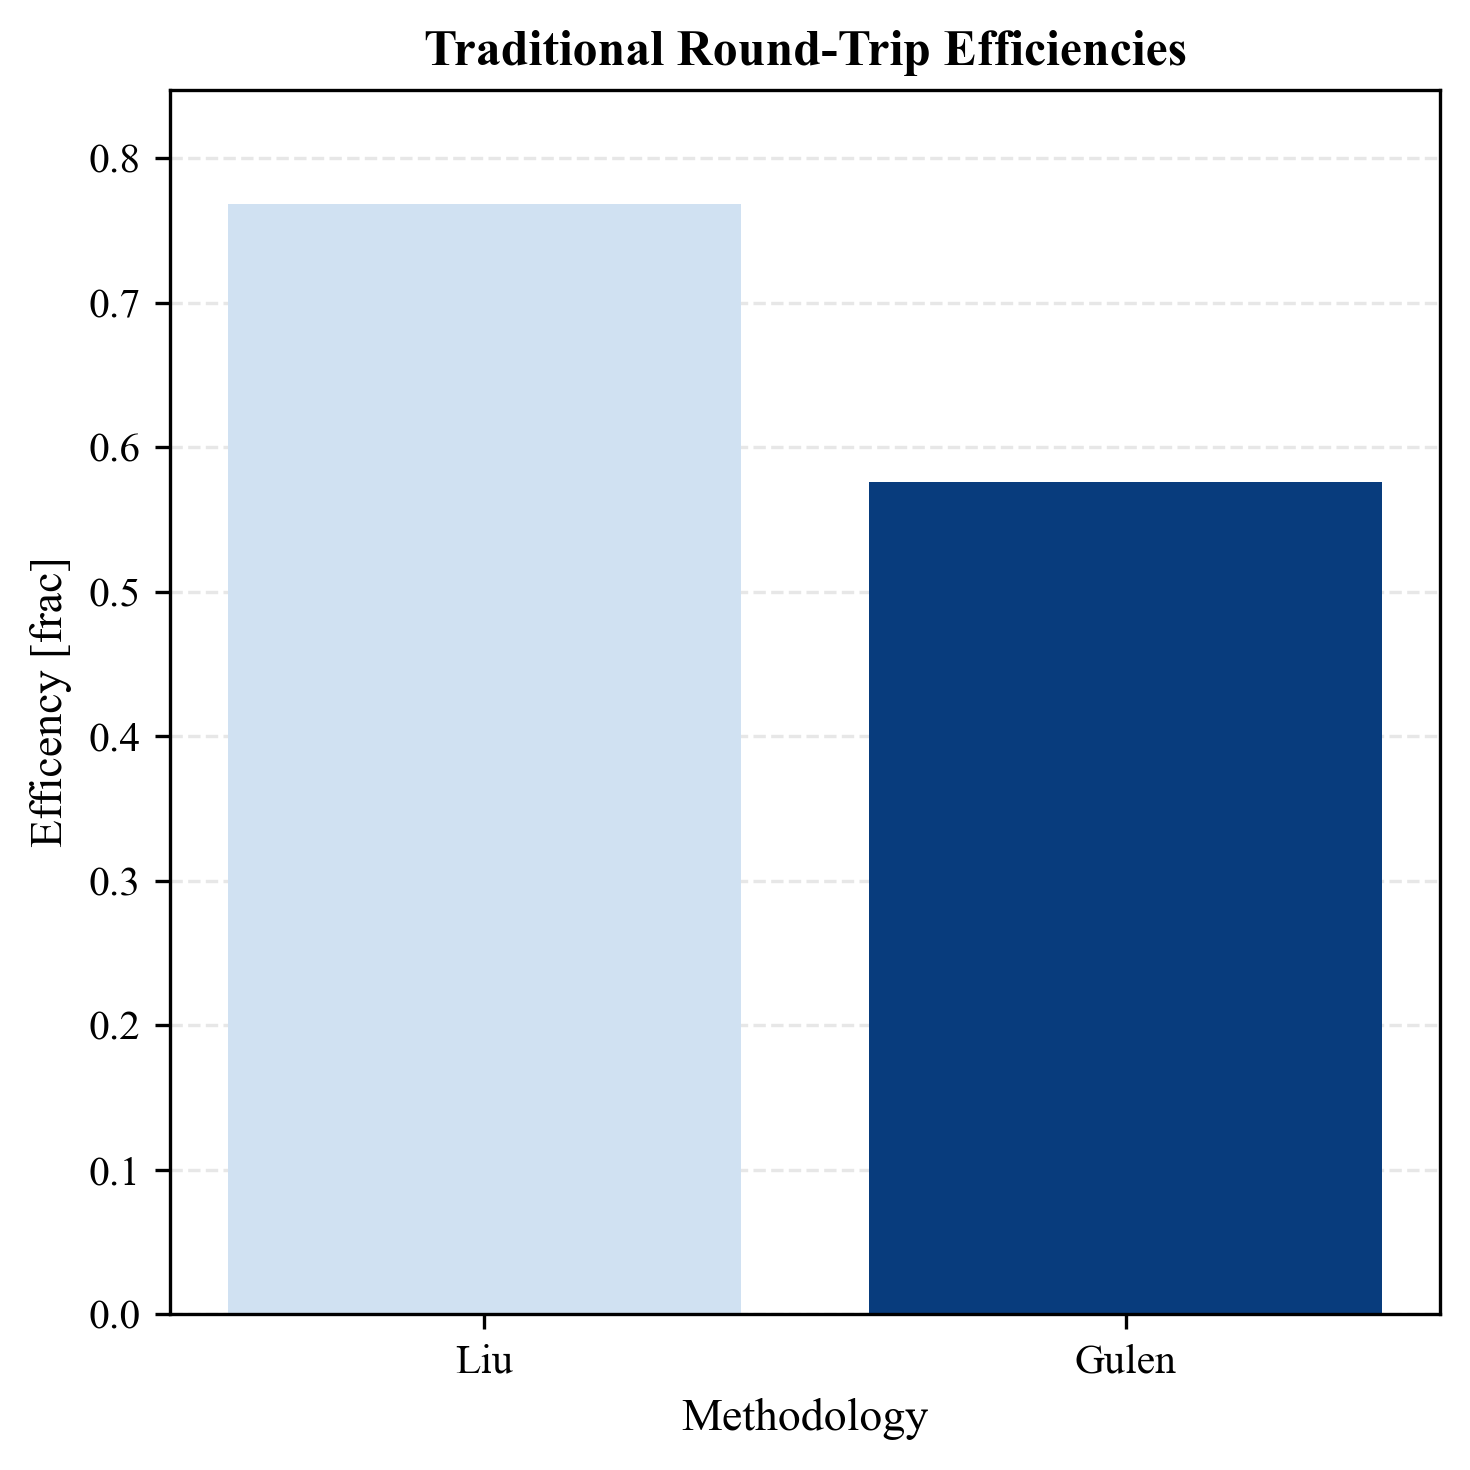

In [80]:
Figure_title = 'Traditional Round-Trip Efficiencies'

kpis = ['Liu', 'Gulen']
y_data = [RTE_Liu, RTE_Gulen]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

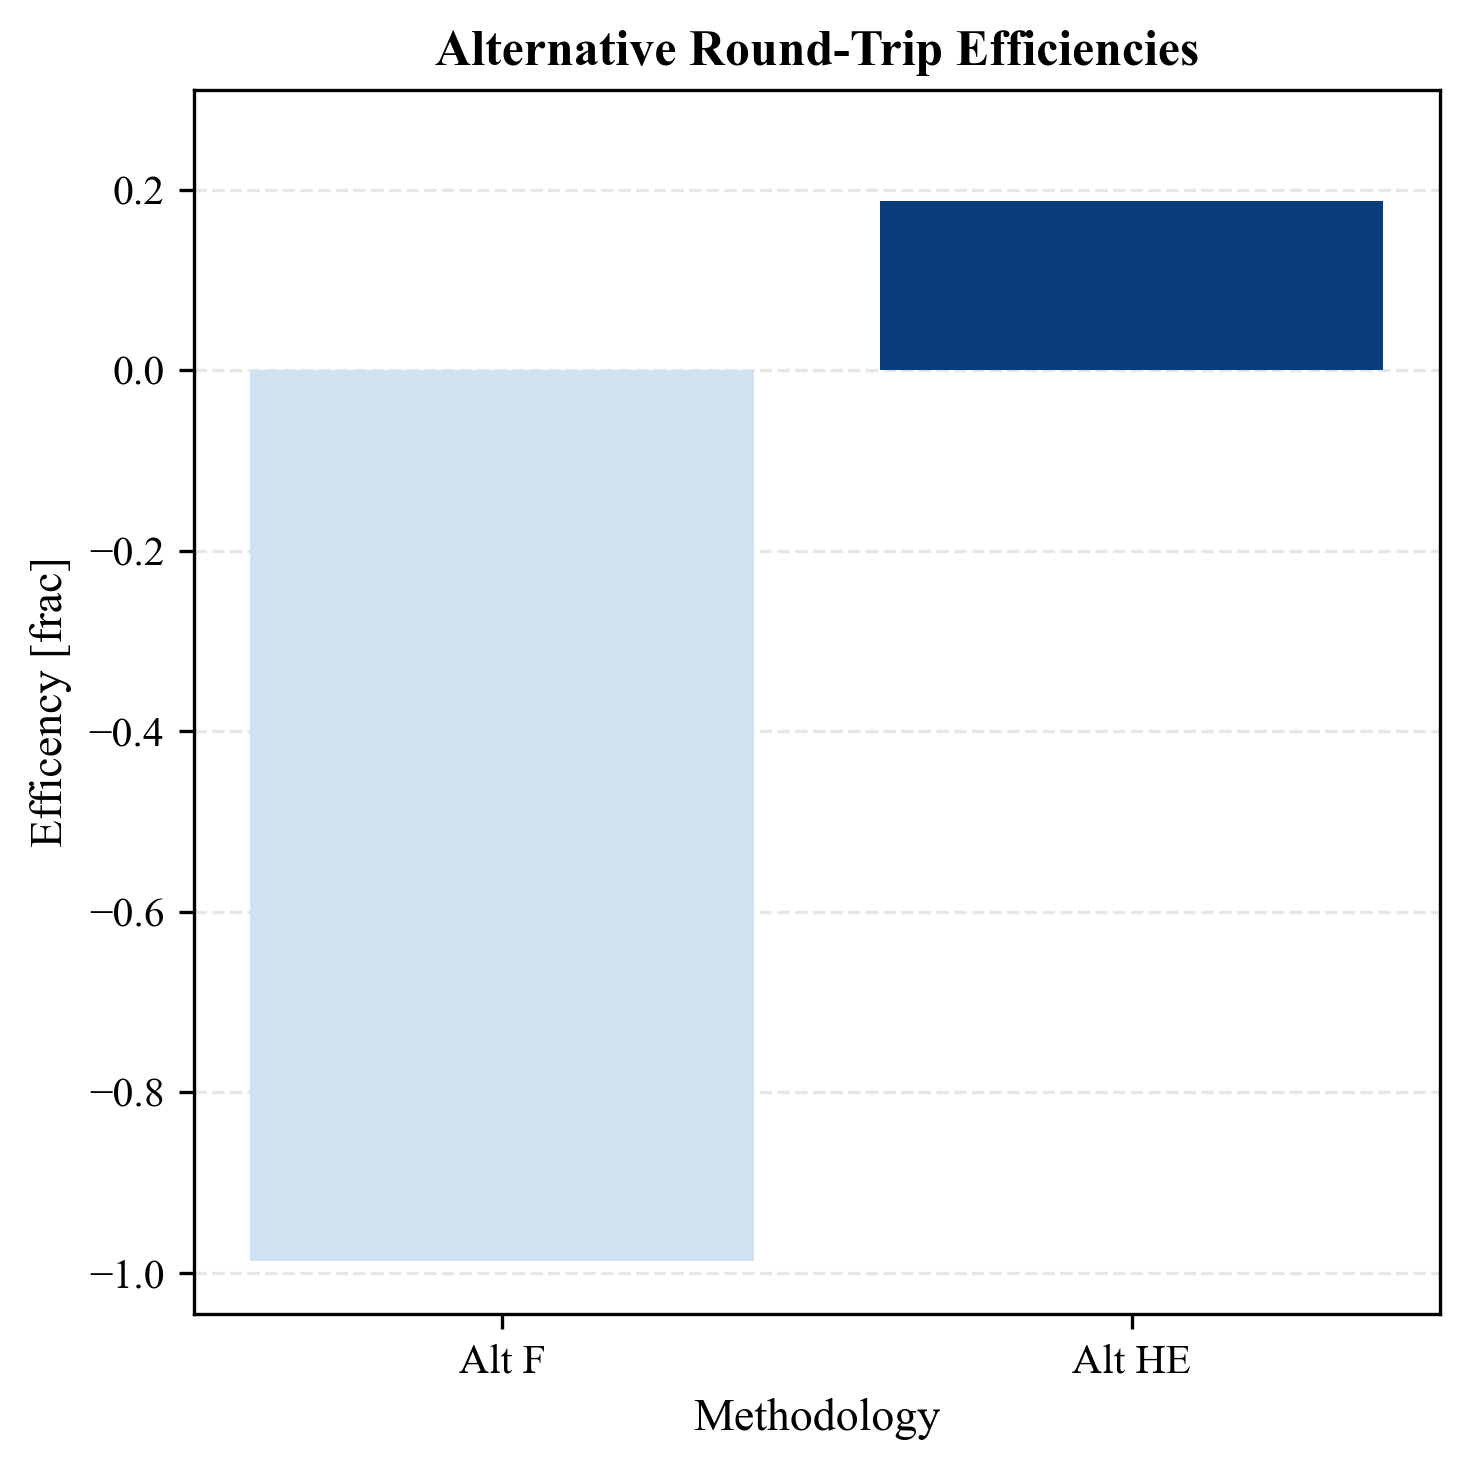

In [81]:
Figure_title = 'Alternative Round-Trip Efficiencies'

kpis = ['Alt F', 'Alt HE']
y_data = [RTE_alt_F, RTE_alt_HE]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Methodology'); ax.set_ylabel('Efficency [frac]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'serif'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

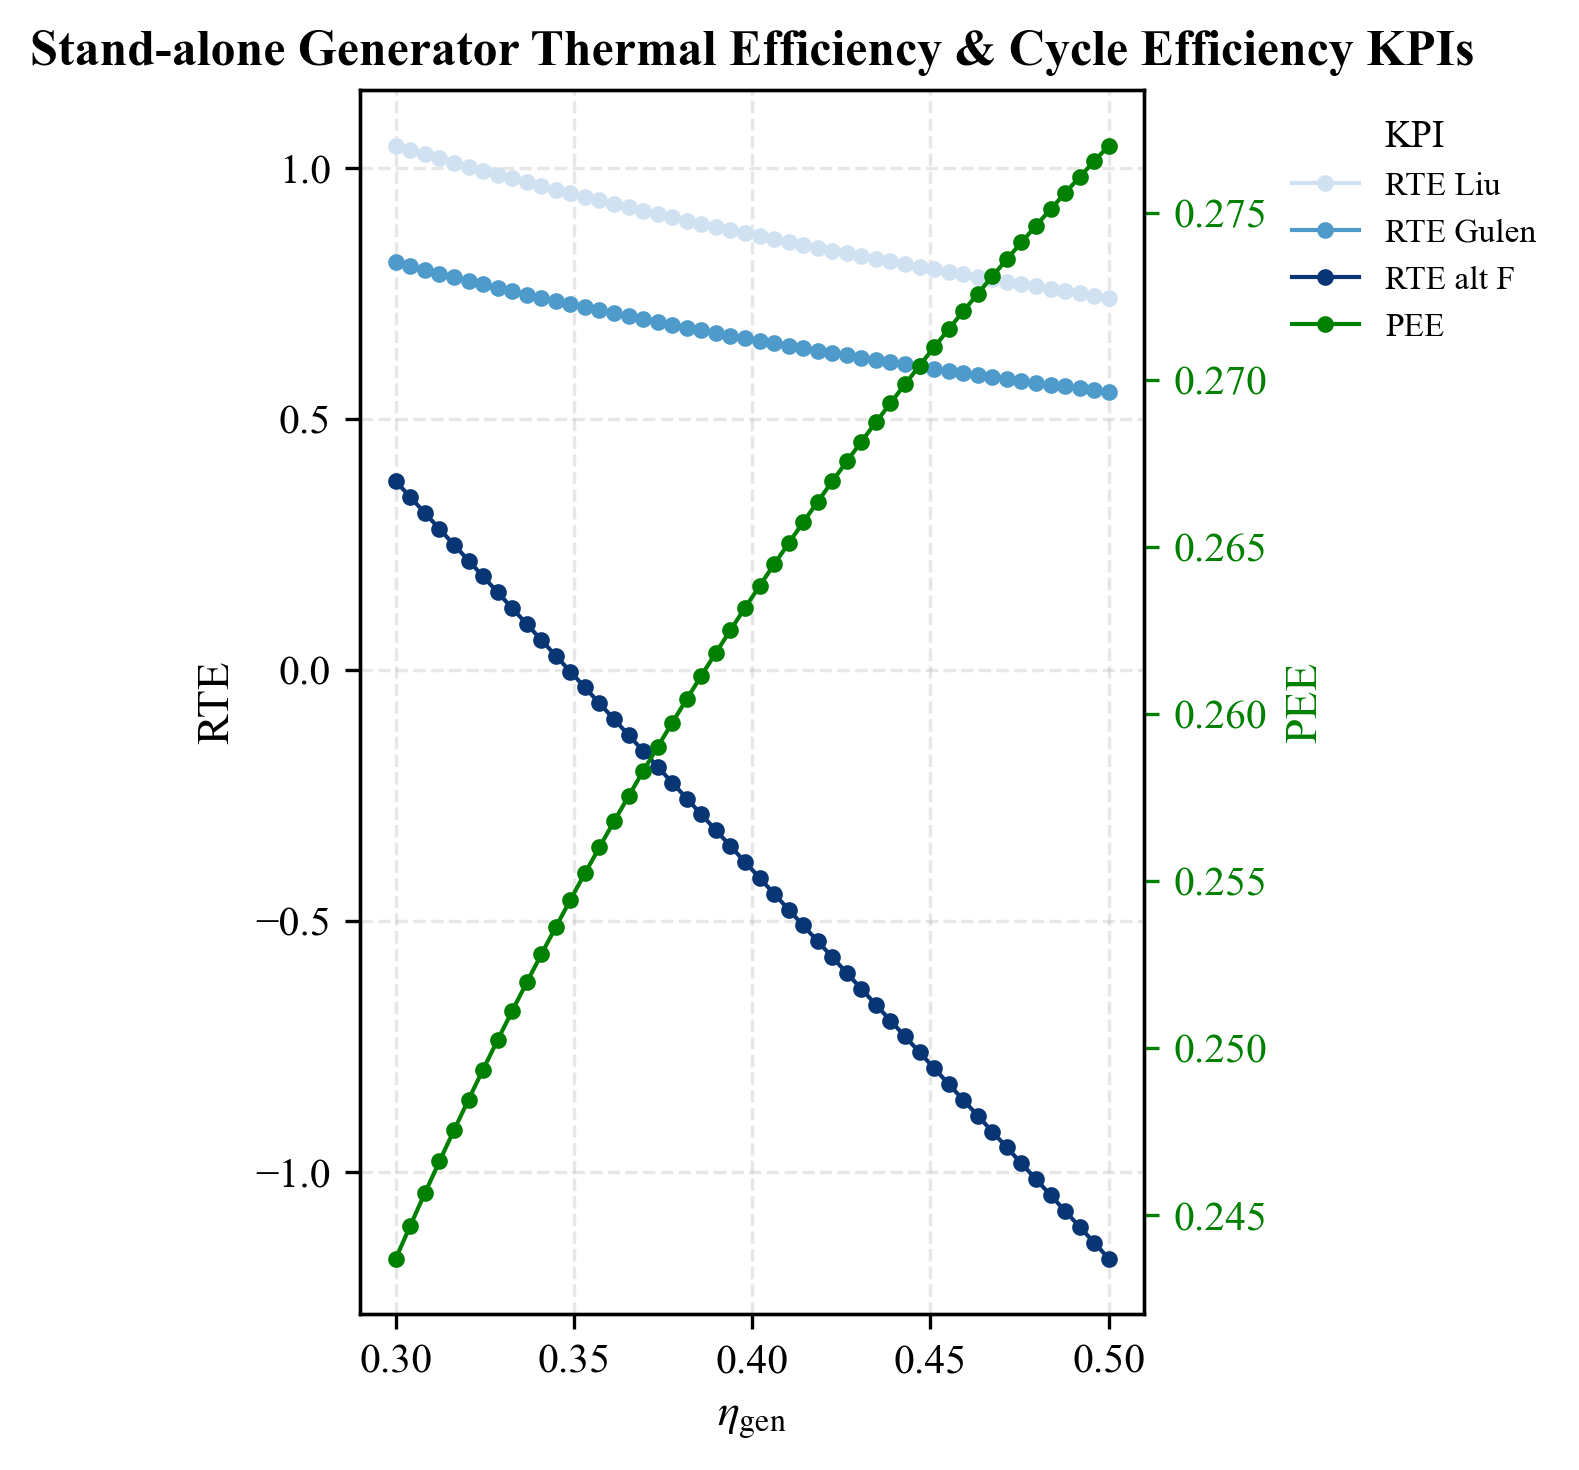

In [82]:
Figure_title = r'Stand-alone Generator Thermal Efficiency & Cycle Efficiency KPIs'

eta_gen_sample = np.linspace(0.3,0.5,50)
RTE_Liu_array   = W_T / (W_C + eta_gen_sample * Q_HE)
RTE_Gulen_array = W_T / (W_C + eta_gen_sample * Q_F)
RTE_alt_F_array   = (W_T - eta_gen_sample * Q_F) / W_C; 
RTE_alt_HE_array   = (W_T - eta_gen_sample * Q_HE) / W_C;
PEE_array       = W_T / ((W_C / eta_gen_sample) + Q_F)

fig, ax1 = plt.subplots(figsize=figsize_std, dpi=300)
cmap   = plt.get_cmap('Blues'); colors = cmap(np.linspace(0.2, 0.975, 3))
labels = ['RTE Liu', 'RTE Gulen', 'RTE alt F', 'RTE alt HE']
for arr, col, label in zip([RTE_Liu_array, RTE_Gulen_array, RTE_alt_F_array, RTE_alt_HE_array],colors,labels):
    ax1.plot(eta_gen_sample, arr,marker='o', markersize=3, linewidth=1,color=col, label=label)
ax1.set_xlabel(r'$\eta_{\mathrm{gen}}$', fontsize=11); ax1.set_ylabel('RTE', fontsize=11); ax1.set_title(Figure_title, fontsize=12, fontweight='bold', fontfamily='Times New Roman'); ax1.grid(True, which='both', linestyle='--', alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(eta_gen_sample, PEE_array,marker='o', markersize=3, linewidth=1,color='green', label='PEE'); ax2.set_ylabel('PEE', fontsize=11, color='green'); ax2.tick_params(axis='y', colors='green')
lines1, labels1 = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2,labels1 + labels2,title='KPI',loc='upper left',bbox_to_anchor=(1.15, 1),fontsize=8,title_fontsize=9,frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

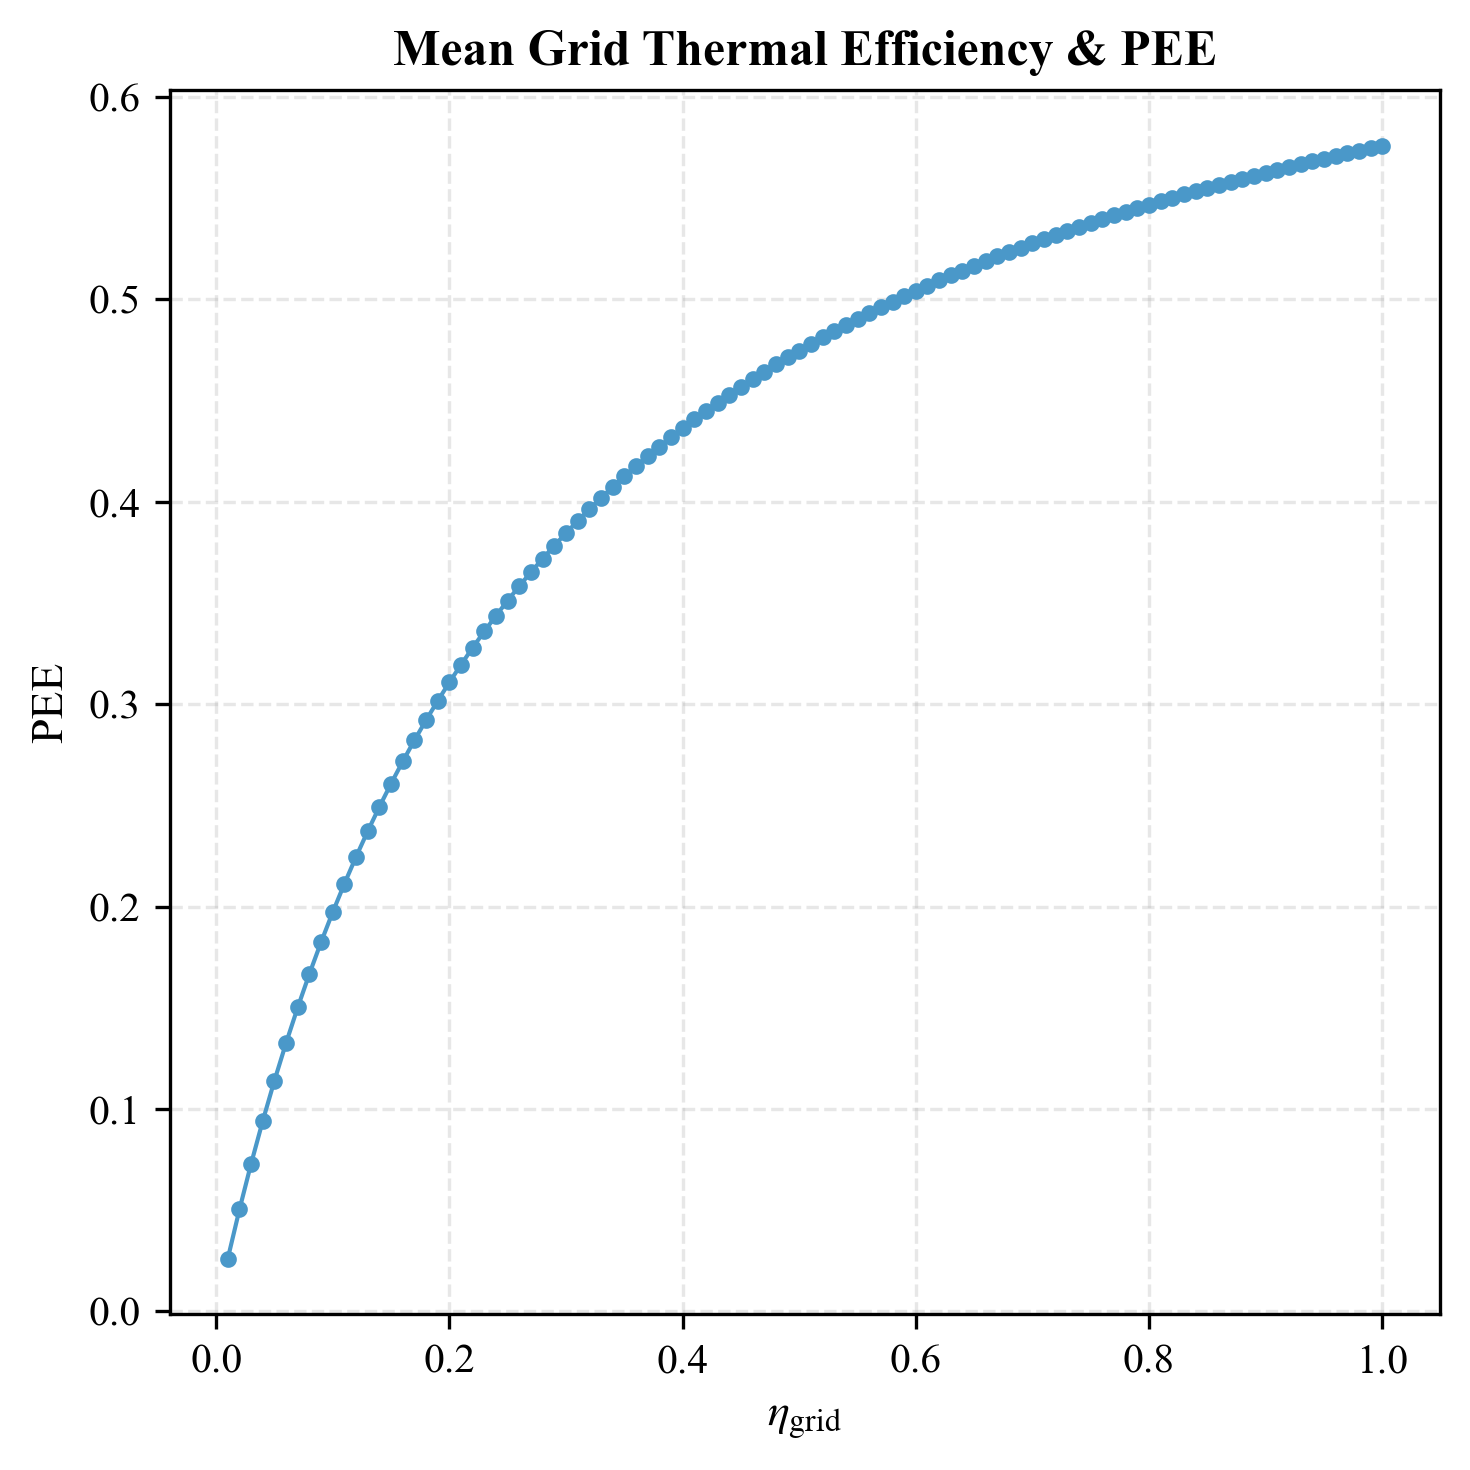

In [83]:
Figure_title = 'Mean Grid Thermal Efficiency & PEE'

eta_grid_sample = np.linspace(0.01, 1, 100); PEE_array_2     = W_T / ((W_C / eta_grid_sample) + eta_gen_avg*Q_F)

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
plt.rcParams['font.family']      = 'Times New Roman'; plt.rcParams['mathtext.fontset'] = 'stix'; plt.rcParams['mathtext.rm']      = 'Times New Roman';plt.rcParams['mathtext.bf']      = 'Times New Roman:bold';plt.rcParams['mathtext.it']      = 'Times New Roman:italic'
color = plt.get_cmap('Blues')(0.6)
ax.plot(eta_grid_sample,PEE_array_2,marker='o',markersize=3,linewidth=1,color=color)
ax.set_xlabel(r'$\eta_{\mathrm{grid}}$', fontsize=11); ax.set_ylabel('PEE', fontsize=11); ax.set_title(Figure_title,fontsize=12,fontweight='bold',fontfamily='Times New Roman'); ax.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Component Visualizations

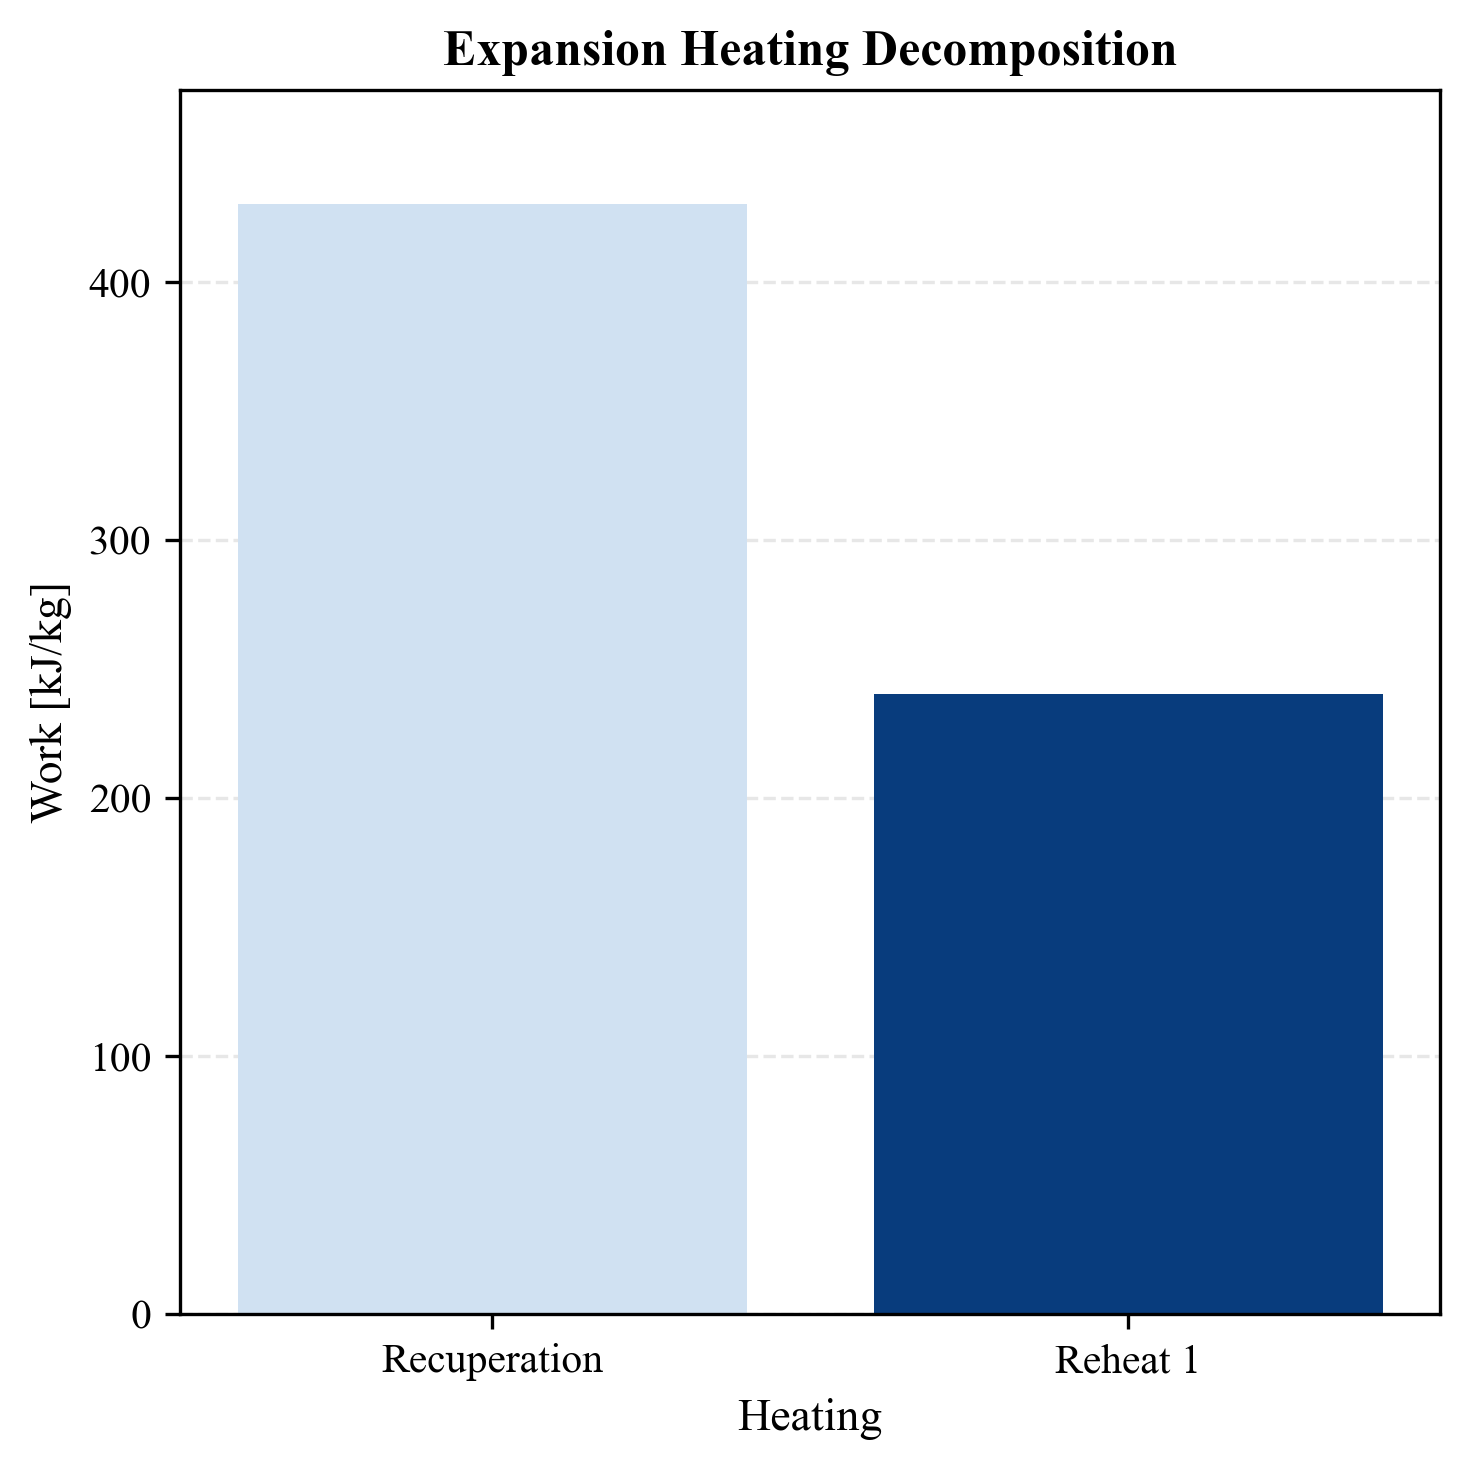

In [84]:
Figure_title = 'Expansion Heating Decomposition'

kpis = ['Recuperation', 'Reheat 1']
y_data = [-1*Q_recuped, Q_HE]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); 
ax.set_xlabel('Heating'); ax.set_ylabel('Work [kJ/kg]'); ax.set_title(Figure_title)
plt.rcParams['font.family']   = 'Times New Roman'; plt.rcParams['font.serif']    = ['Times New Roman']; 
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

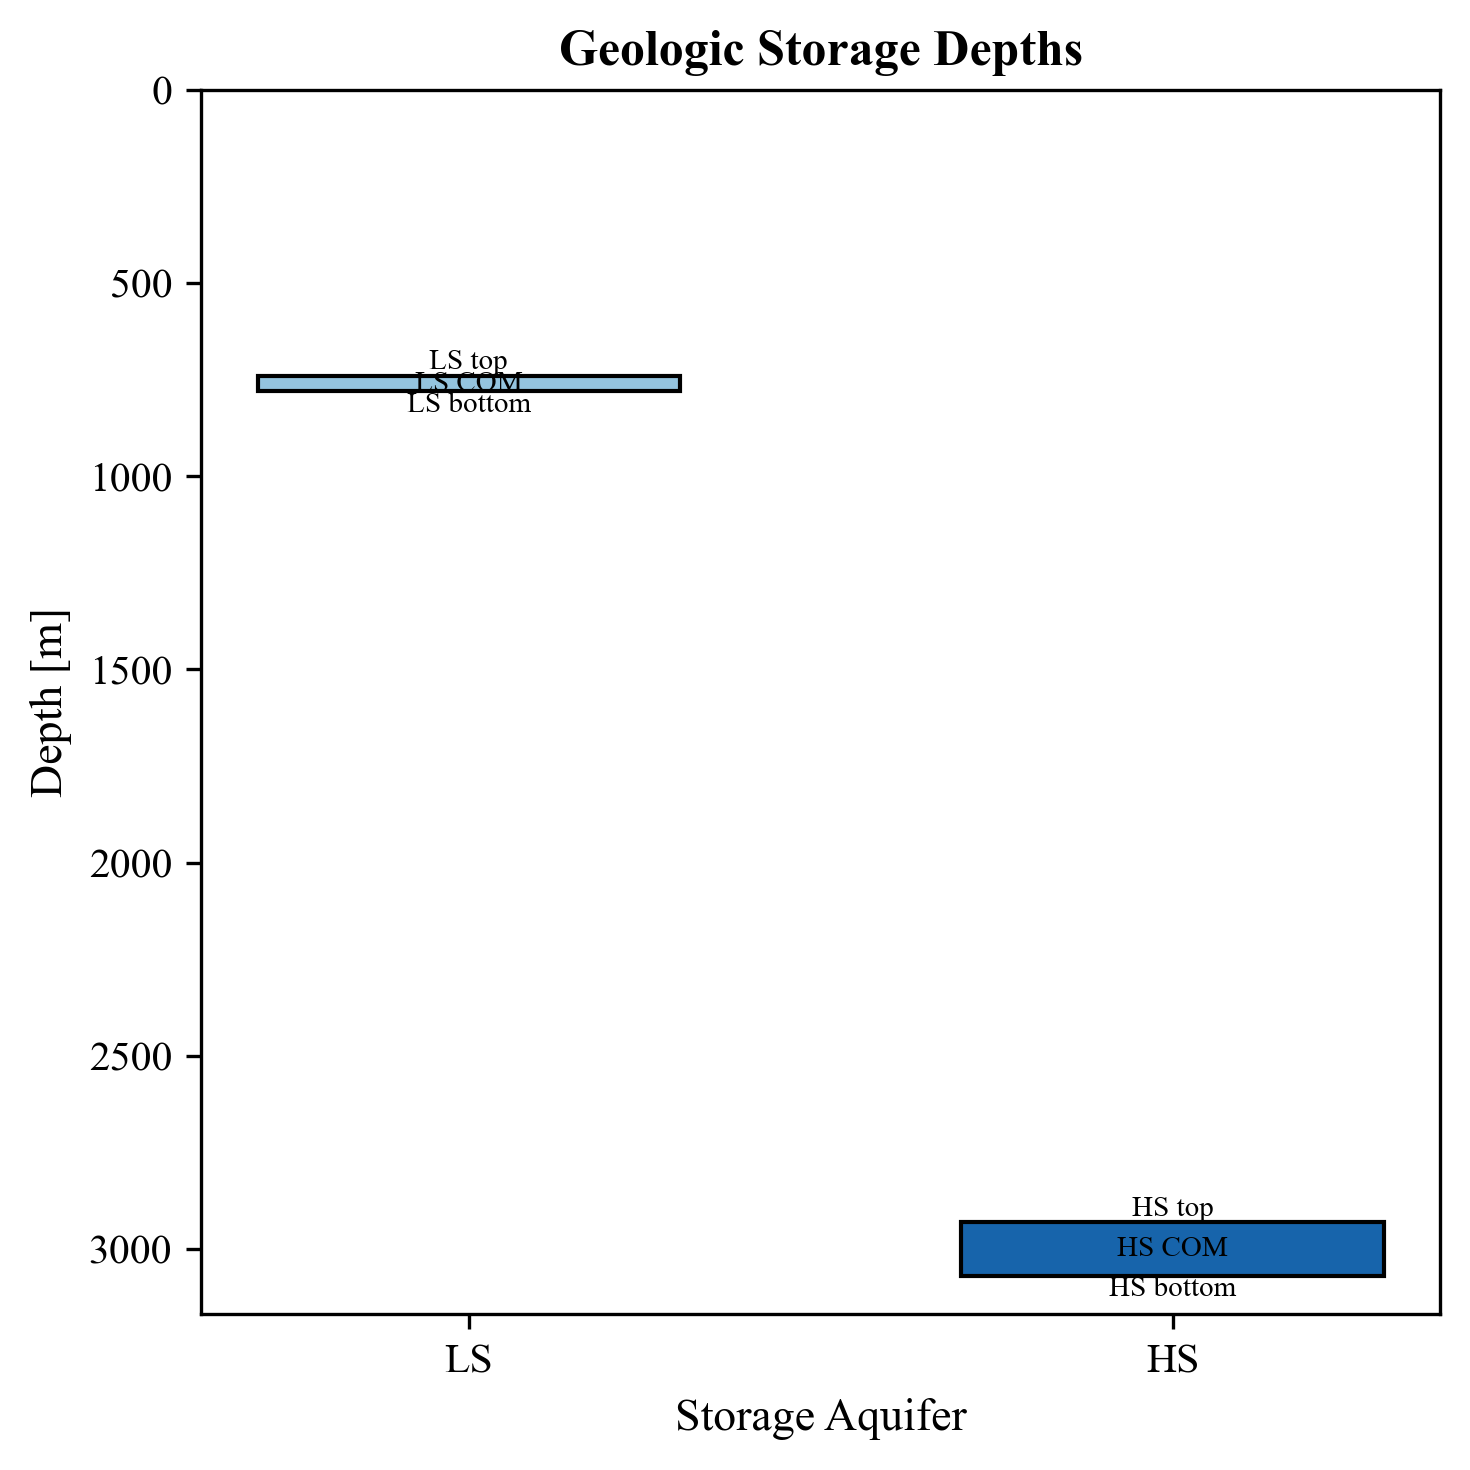

In [85]:
Figure_title = 'Geologic Storage Depths'
deltaz_LS = deltaP_LS_full_cycle/(p_LS_ss*g); deltaz_HS = deltaP_HS_full_cycle/(p_HS_ss*g); 
z_LS_top = z_LS - (deltaz_LS/2); z_LS_bottom = z_LS + (deltaz_LS/2); z_LS_com = z_LS;
z_HS_top = z_HS - (deltaz_HS/2); z_HS_bottom = z_HS + (deltaz_HS/2); z_HS_com = z_HS;
labels = ['LS', 'HS']; top    = [z_LS_top,     z_HS_top]; bot    = [z_LS_bottom,  z_HS_bottom]; com    = [z_LS_com,     z_HS_com]
heights     = [t - b for t, b in zip(top, bot)]; max_height  = max(heights); offset      = max_height * 0.045


fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap   = plt.get_cmap('Blues'); colors = cmap(np.linspace(0.4, 0.8, len(labels)))
x = np.arange(len(labels))
ax.bar(x,heights,bottom=bot,width=0.6,color=colors,edgecolor='black')
for xi, t, m, b, lbl in zip(x, top, com, bot, labels):
    ax.text(xi,t + offset,f"{lbl} top",ha='center',va='bottom',fontsize=7)
    ax.text(xi,m,f"{lbl} COM",ha='center',va='center',fontsize=7,color='black')
    ax.text(xi,b - offset,f"{lbl} bottom",ha='center',va='top',fontsize=7)
ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=10); ax.set_ylim(max(bot) + 100, 0);ax.set_xlabel('Storage Aquifer'); ax.set_ylabel('Depth [m]', fontsize=11);ax.set_title(Figure_title,fontsize=12,fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

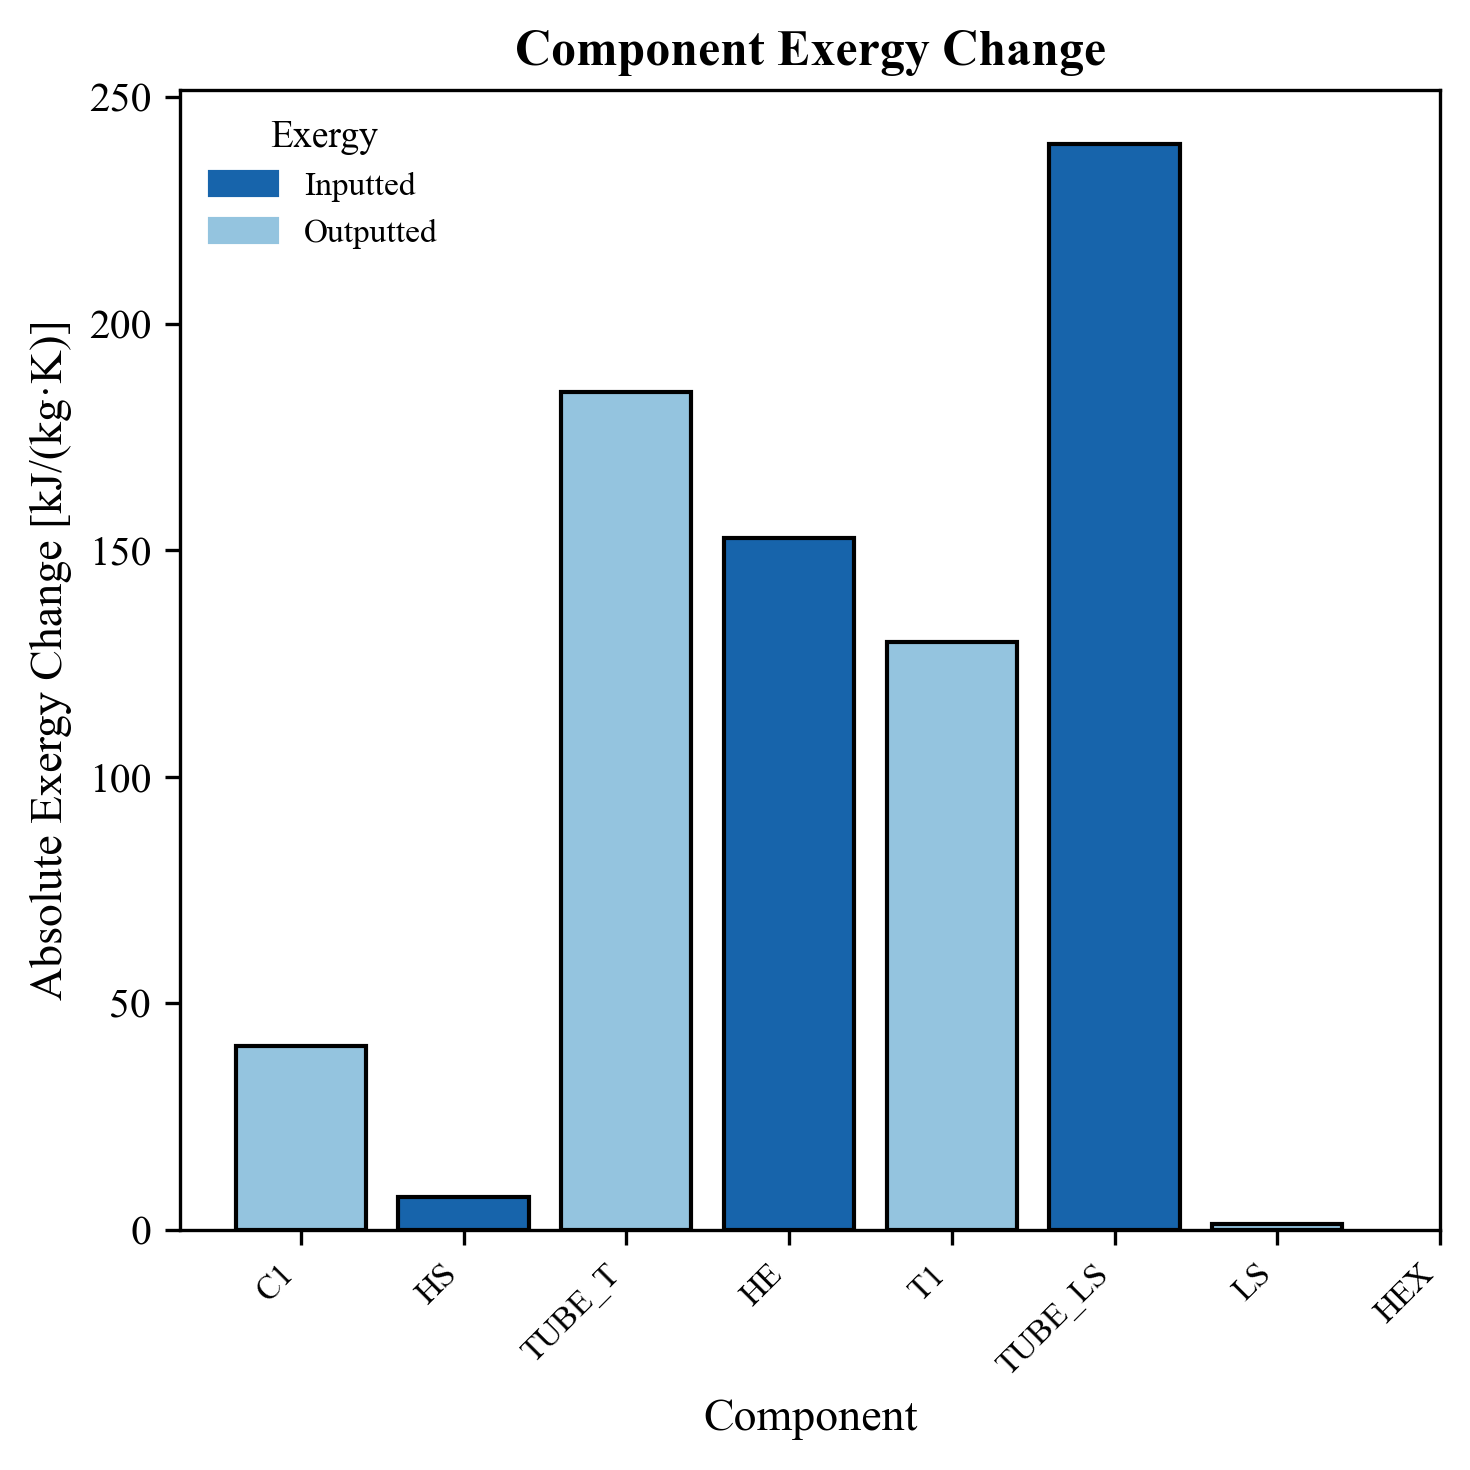

In [86]:
Figure_title = 'Component Exergy Change'

components = dfc['Component'].tolist(); start_ex   = dfc['Start_ex'].values; end_ex     = dfc['End_ex'].values; delta_ex   = end_ex - start_ex
heights = np.abs(delta_ex); x       = np.arange(len(components))

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap      = plt.get_cmap('Blues'); in_color  = cmap(0.8); out_color = cmap(0.4); outputcolors    = [in_color if d > 0 else out_color for d in delta_ex]
ax.bar(x, heights, color=colors, edgecolor='black'); in_patch  = mpatches.Patch(color=in_color,  label='Energy Input'); out_patch = mpatches.Patch(color=out_color, label='Energy Output')
ax.legend([in_patch, out_patch],['Inputted', 'Outputted'],title='Exergy',title_fontsize=9,fontsize=8,loc='upper left',frameon=False)
ax.set_title(Figure_title, fontsize=12, fontweight='bold'); ax.set_xlabel('Component', fontsize=11); ax.set_ylabel('Absolute Exergy Change [kJ/(kg·K)]', fontsize=11); ax.set_xticks(x)
ax.set_xticklabels(components, rotation=45, ha='right', fontsize=8); 

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

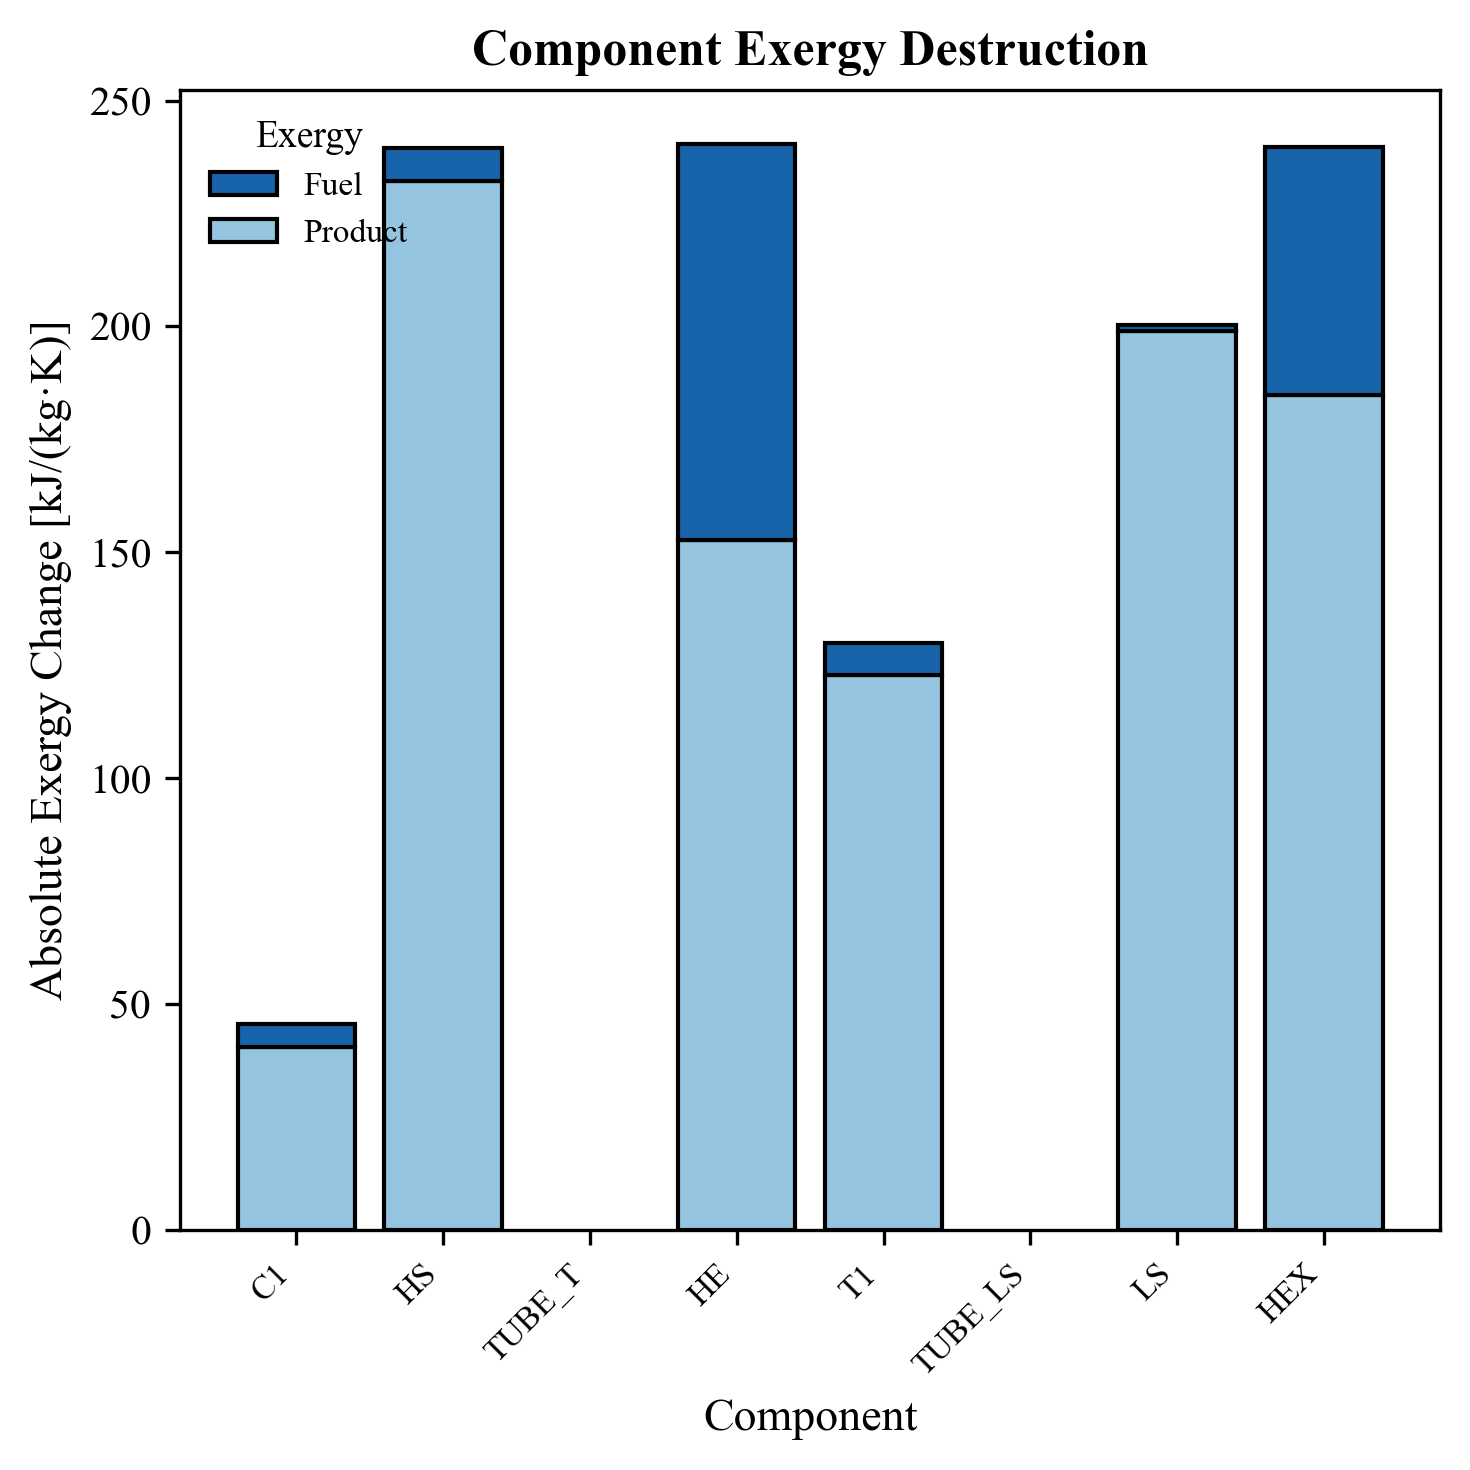

In [87]:
Figure_title = 'Component Exergy Destruction'

components = dfc['Component'].tolist(); EX_F       = np.abs(dfc['EX_F'].values); EX_P       = np.abs(dfc['EX_P'].values); inc_F      = EX_F - EX_P

fig, ax = plt.subplots(figsize=figsize_std, dpi=300); cmap  = plt.get_cmap('Blues'); col_P = cmap(0.4); col_F = cmap(0.8) 
x = np.arange(len(components));ax.bar(x, EX_P,    color=col_P, label='Product', edgecolor='black'); ax.bar(x, inc_F,   bottom=EX_P, color=col_F, label='Fuel',    edgecolor='black')
ax.set_title(Figure_title, fontsize=12, fontweight='bold'); ax.set_xlabel('Component', fontsize=11); ax.set_ylabel('Absolute Exergy Change [kJ/(kg·K)]', fontsize=11); ax.set_xticks(x); ax.set_xticklabels(components, rotation=45, ha='right', fontsize=8)
handles, labels = ax.get_legend_handles_labels(); ax.legend(handles[::-1], labels[::-1], title='Exergy', title_fontsize=9,fontsize=8,loc='upper left',frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

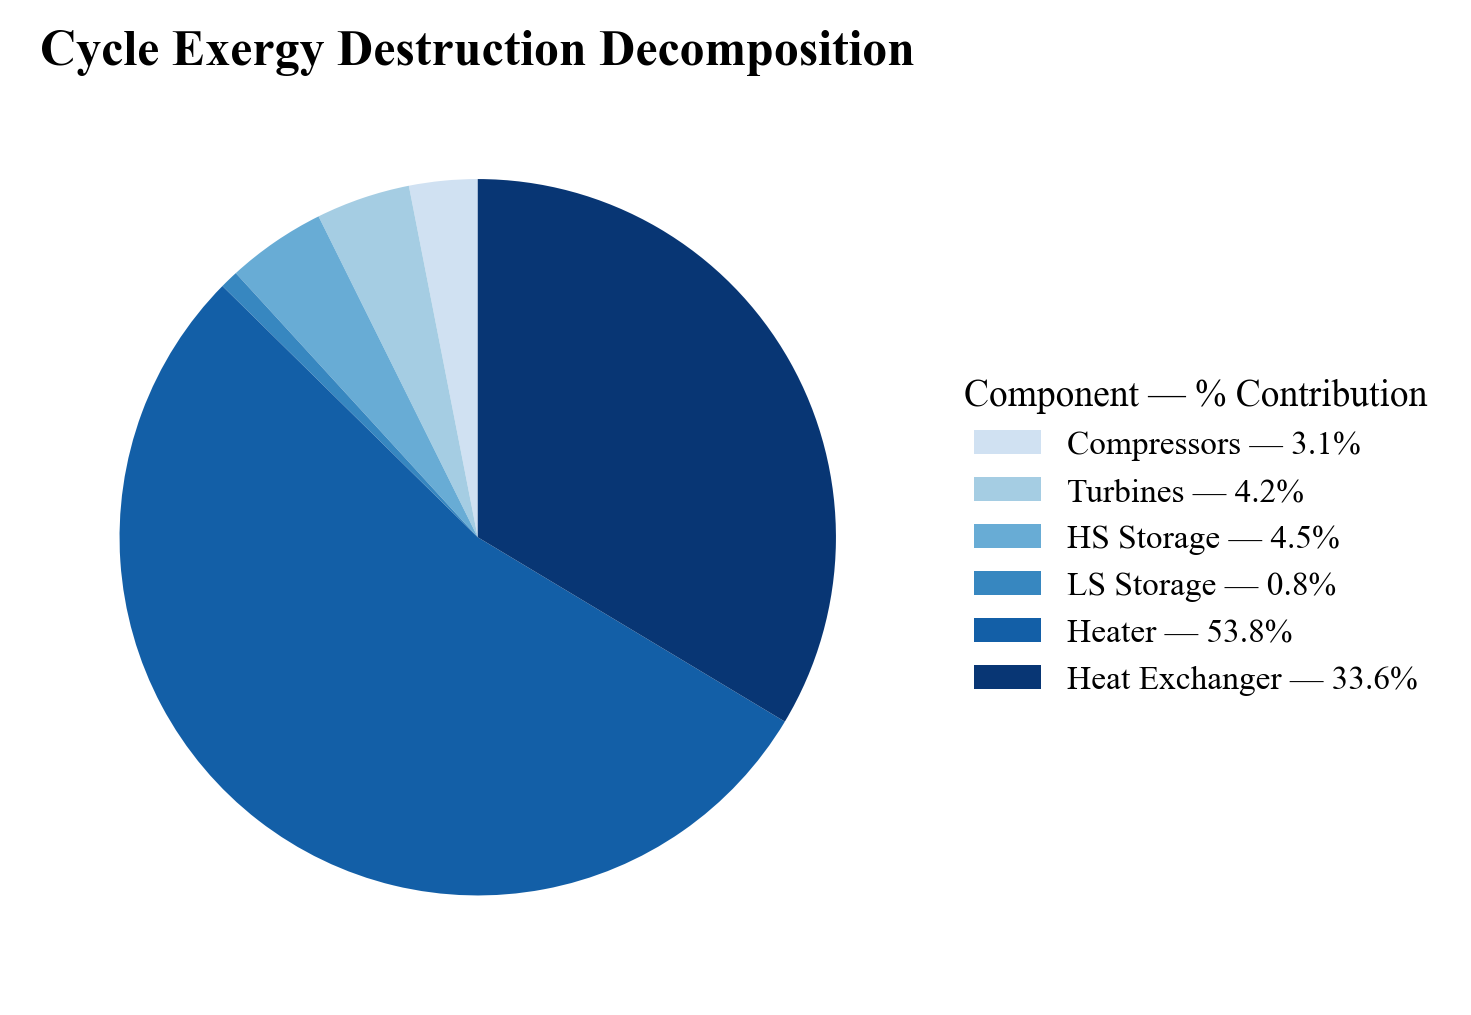

In [88]:
Figure_title = 'Cycle Exergy Destruction Decomposition'

components = ['Compressors', 'Turbines','HS Storage', 'LS Storage','Heater', 'Heat Exchanger']
ratios = np.array([EXDR_C,EXDR_T,EXDR_HS,EXDR_LS,EXDR_HE,EXDR_HEX]); percentages = 100 * ratios / ratios.sum(); legend_labels = [f"{comp} — {pct:.1f}%" for comp, pct in zip(components, percentages)]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.975, len(components)); colors = cmap(hues)
wedges, _ = ax.pie(ratios,labels=None,colors=colors,startangle=90,wedgeprops=dict(edgecolor=None))
ax.legend(wedges,legend_labels,title='Component — % Contribution',loc='center left',bbox_to_anchor=(1.01, 0.5),fontsize=8,title_fontsize=9,frameon=False); ax.set_title(Figure_title, fontsize=12, fontweight='bold')

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Stream Visualizations

In [89]:
dffull = df; df_storage = df.iloc[-2:]; df = df.iloc[:-2]; 
HS_num = 0.5*(HS_start+HS_end); LS_num = 0.5*(LS_start + (LS_start+1)); n_rows = dffull.shape[0];HS_idx = n_rows-1;LS_idx = n_rows;

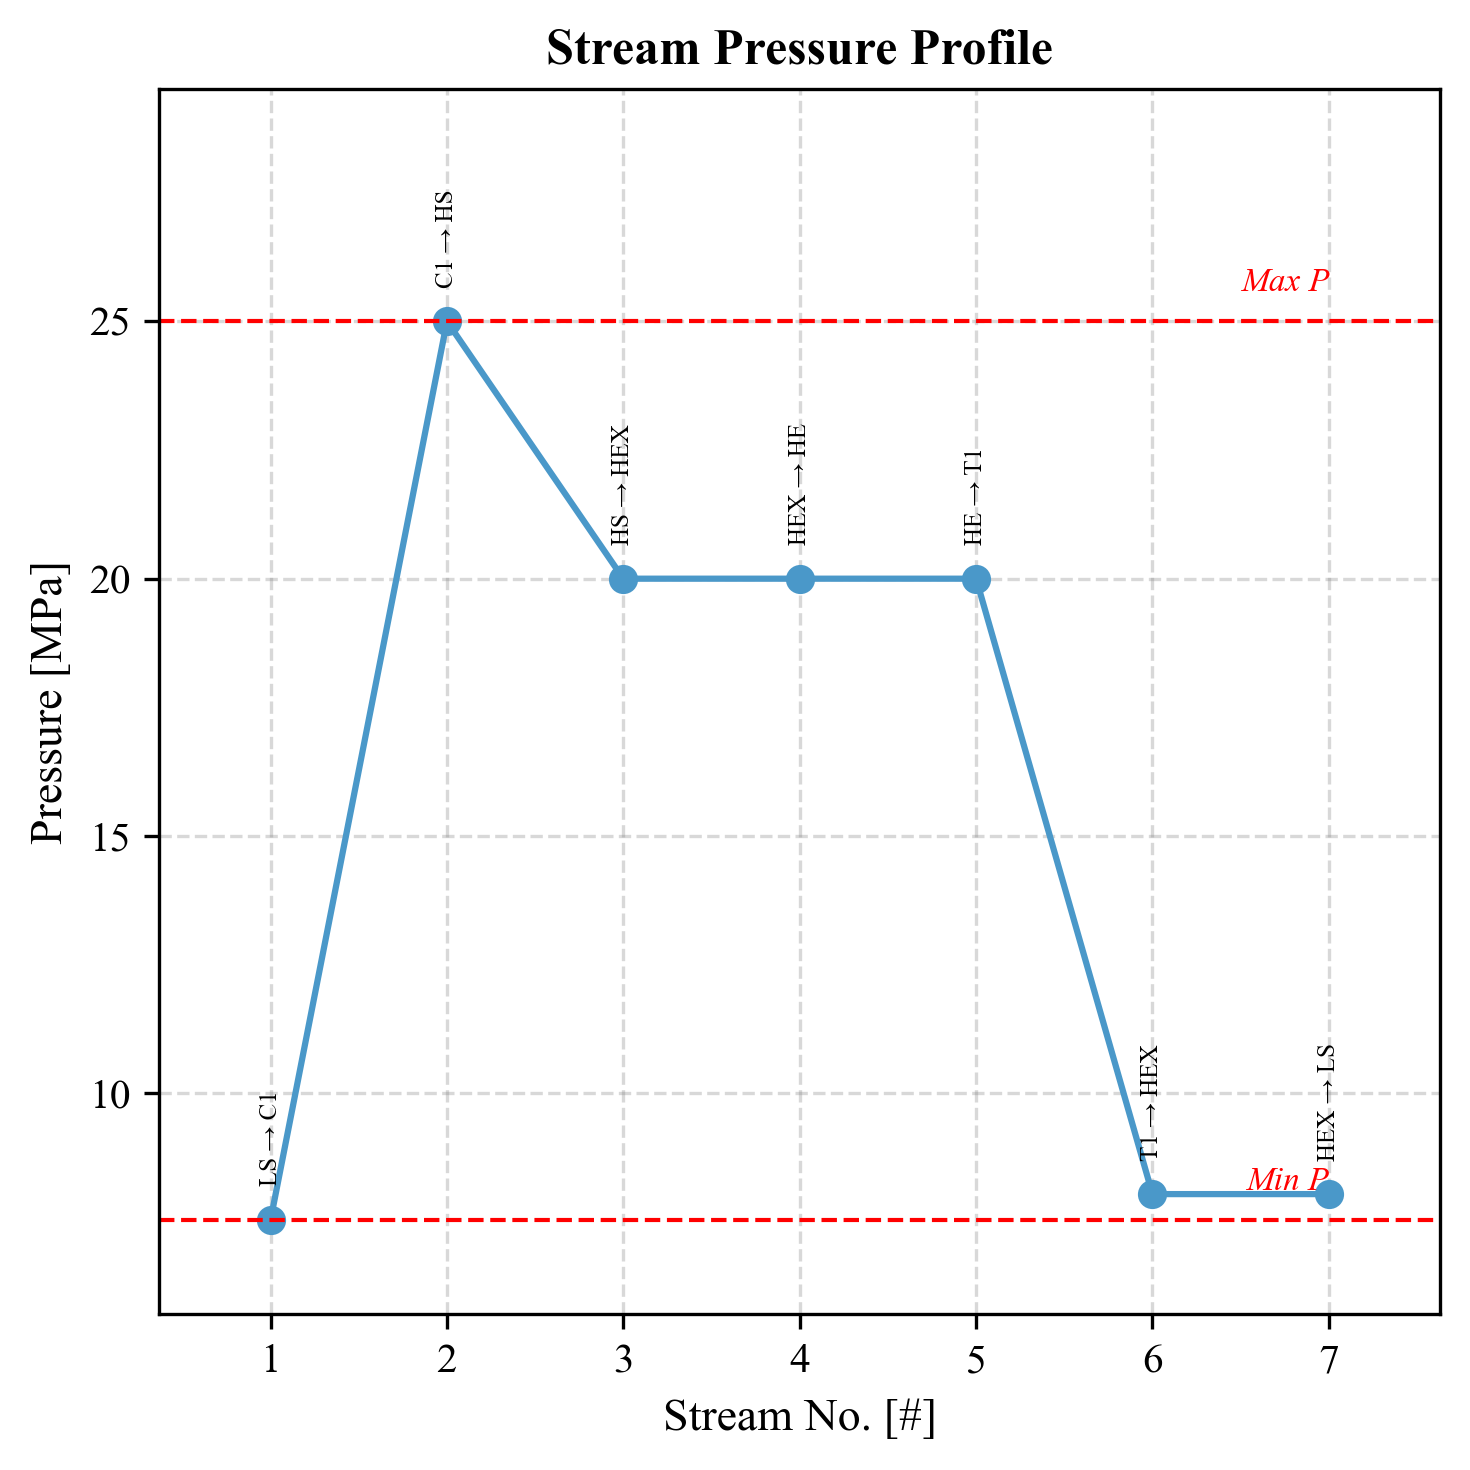

In [90]:
Thermodynamic_variable        = 'Pressure'
Thermodynamic_variable_symbol = 'P'
Units                         = 'MPa'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'

x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.75,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.75,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

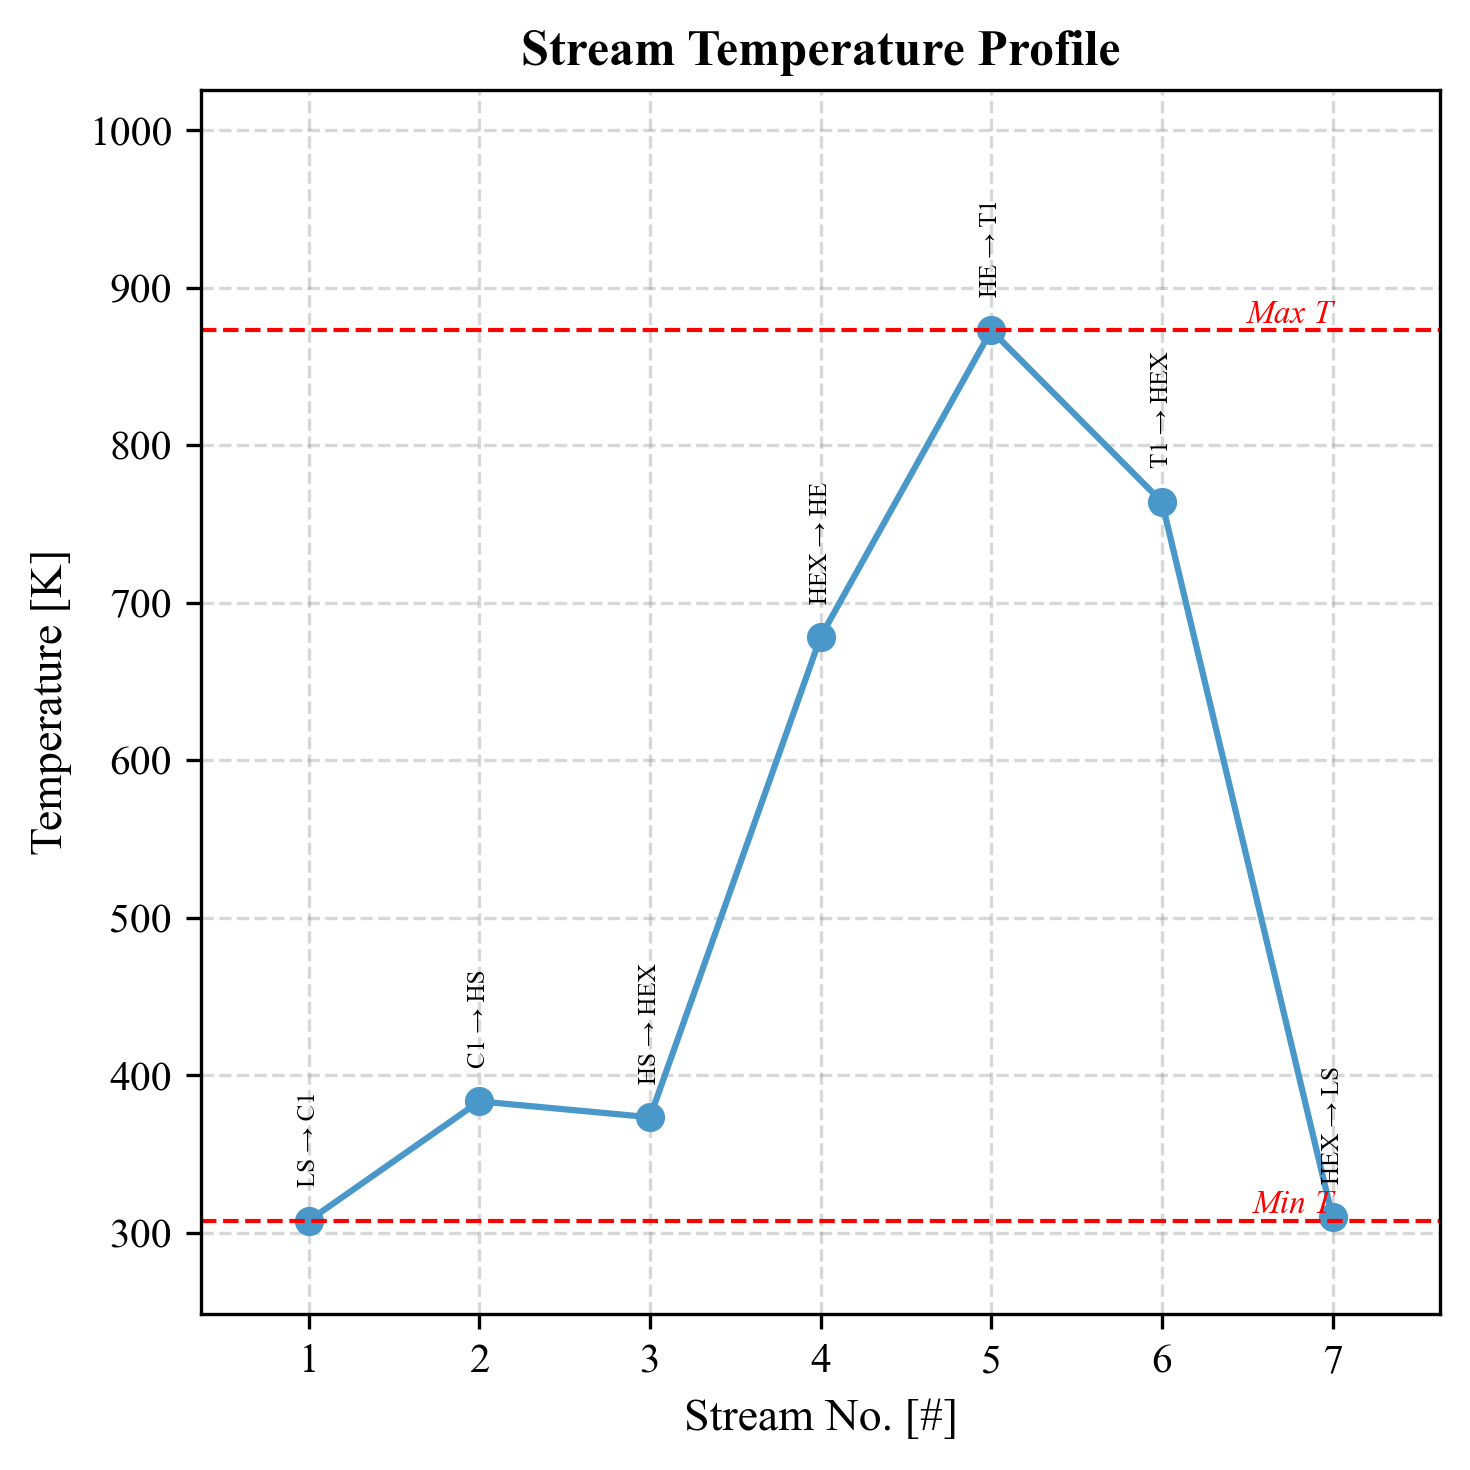

In [91]:
Thermodynamic_variable        = 'Temperature'
Thermodynamic_variable_symbol = 'T'
Units                         = 'K'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

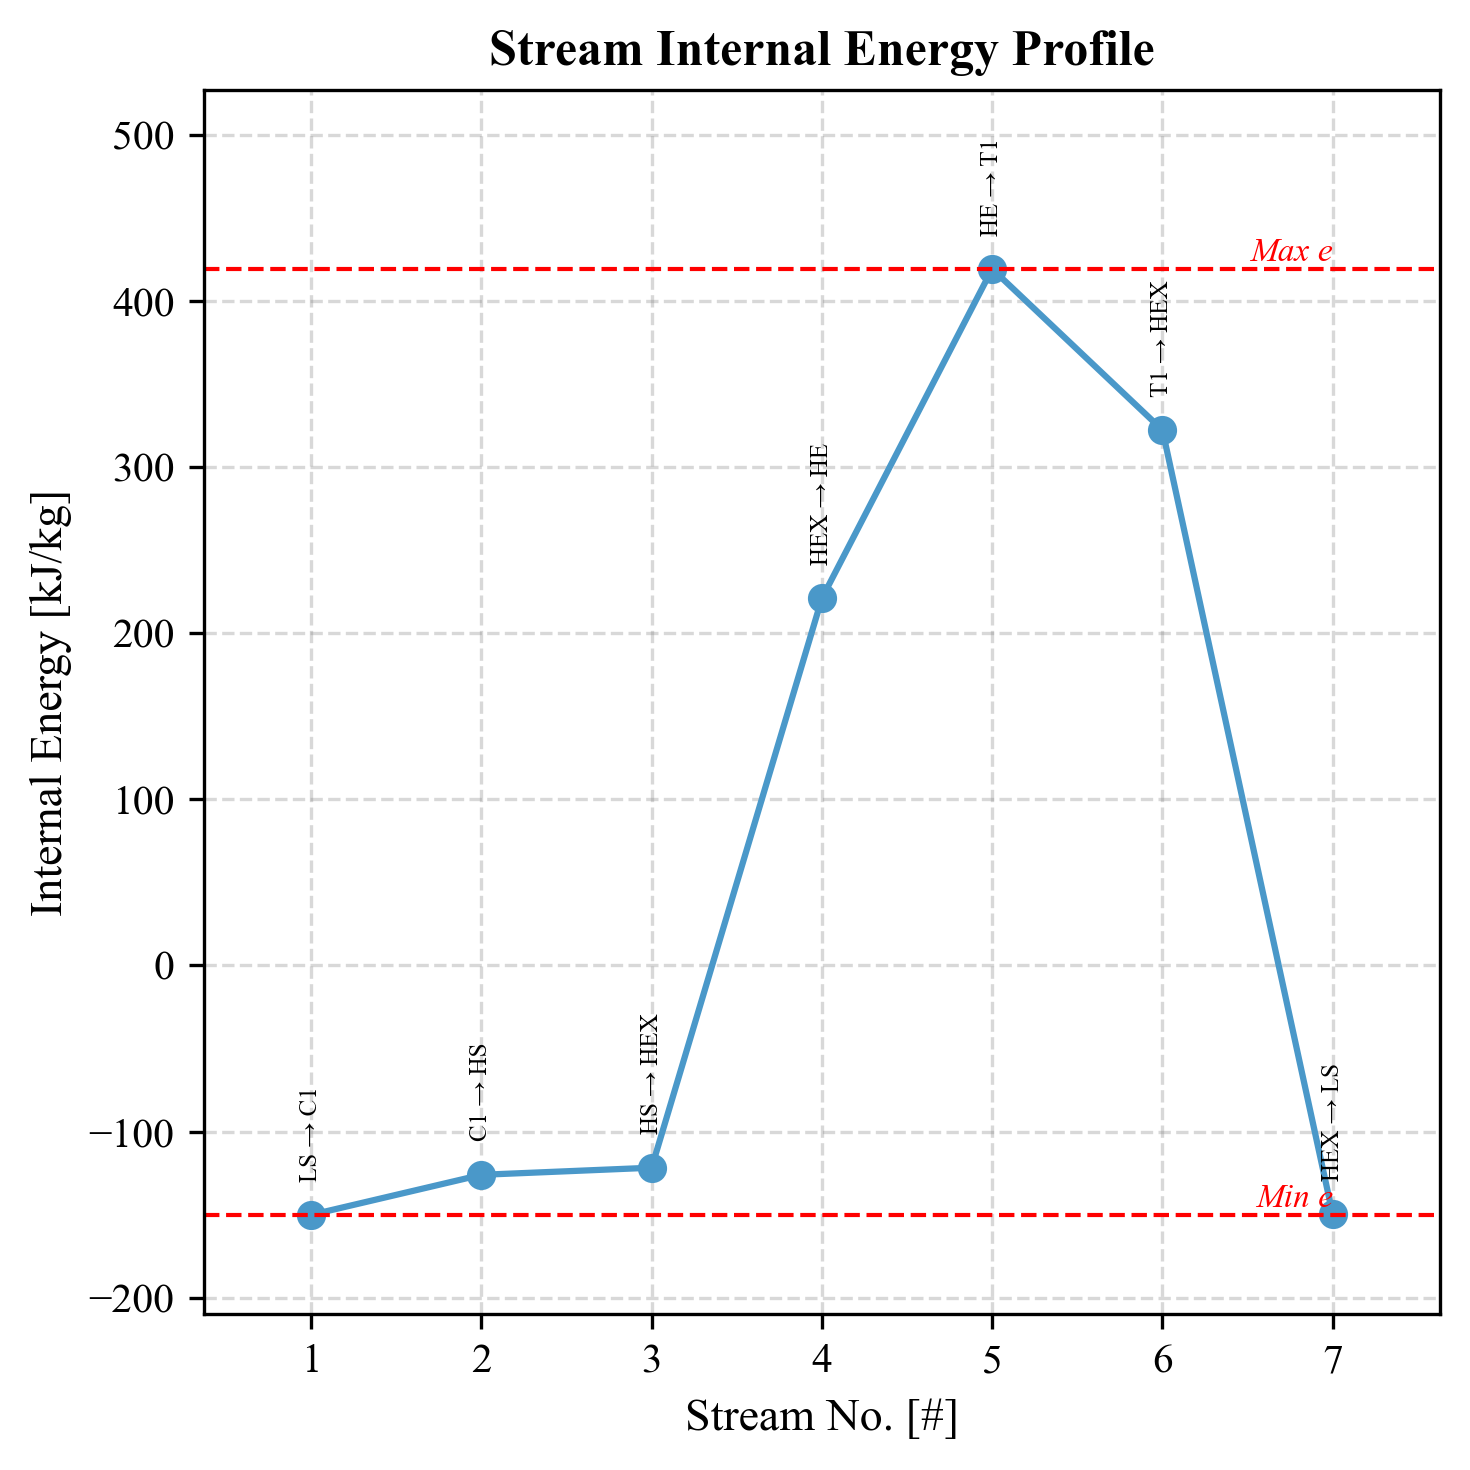

In [92]:
Thermodynamic_variable        = 'Internal Energy'
Thermodynamic_variable_symbol = 'e'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 10,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 10,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

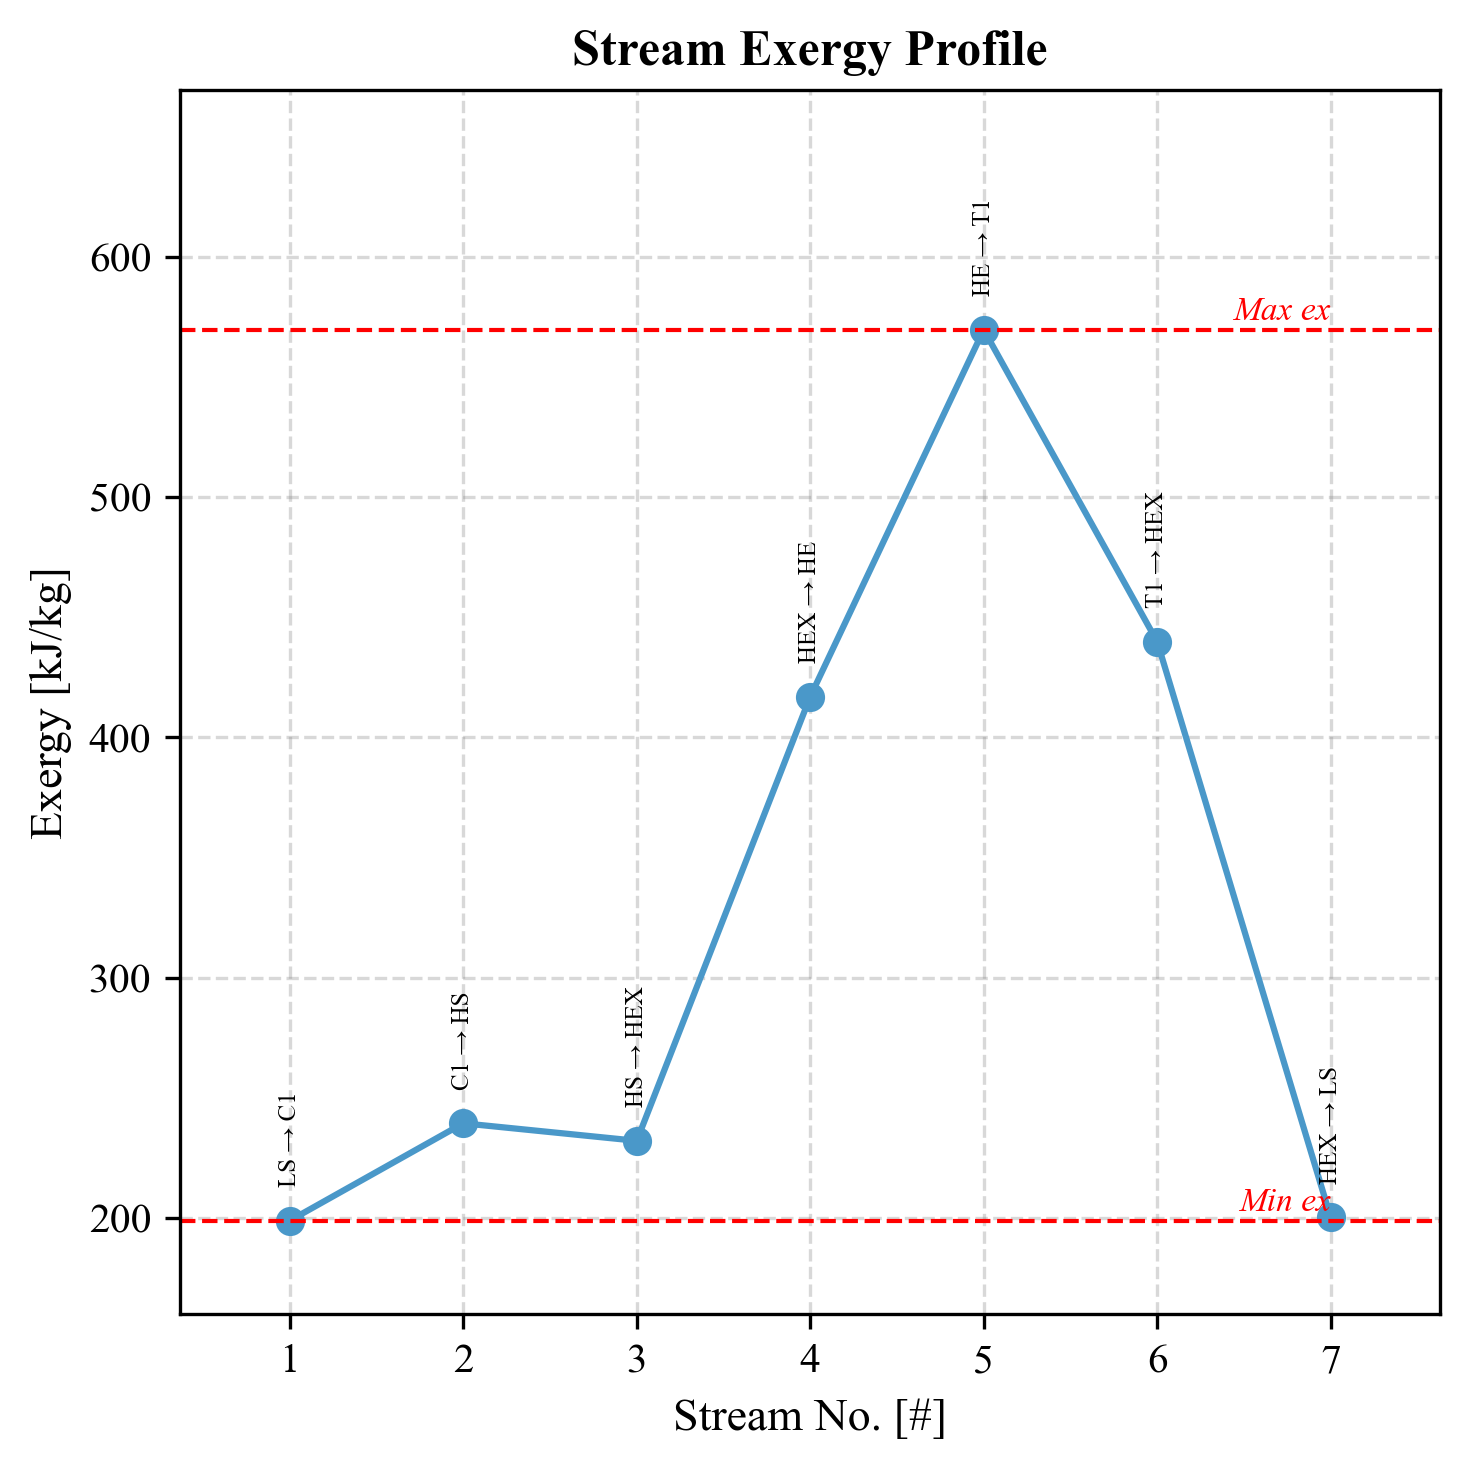

In [93]:
Thermodynamic_variable        = 'Exergy'
Thermodynamic_variable_symbol = 'ex'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 7.5,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 7.5,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

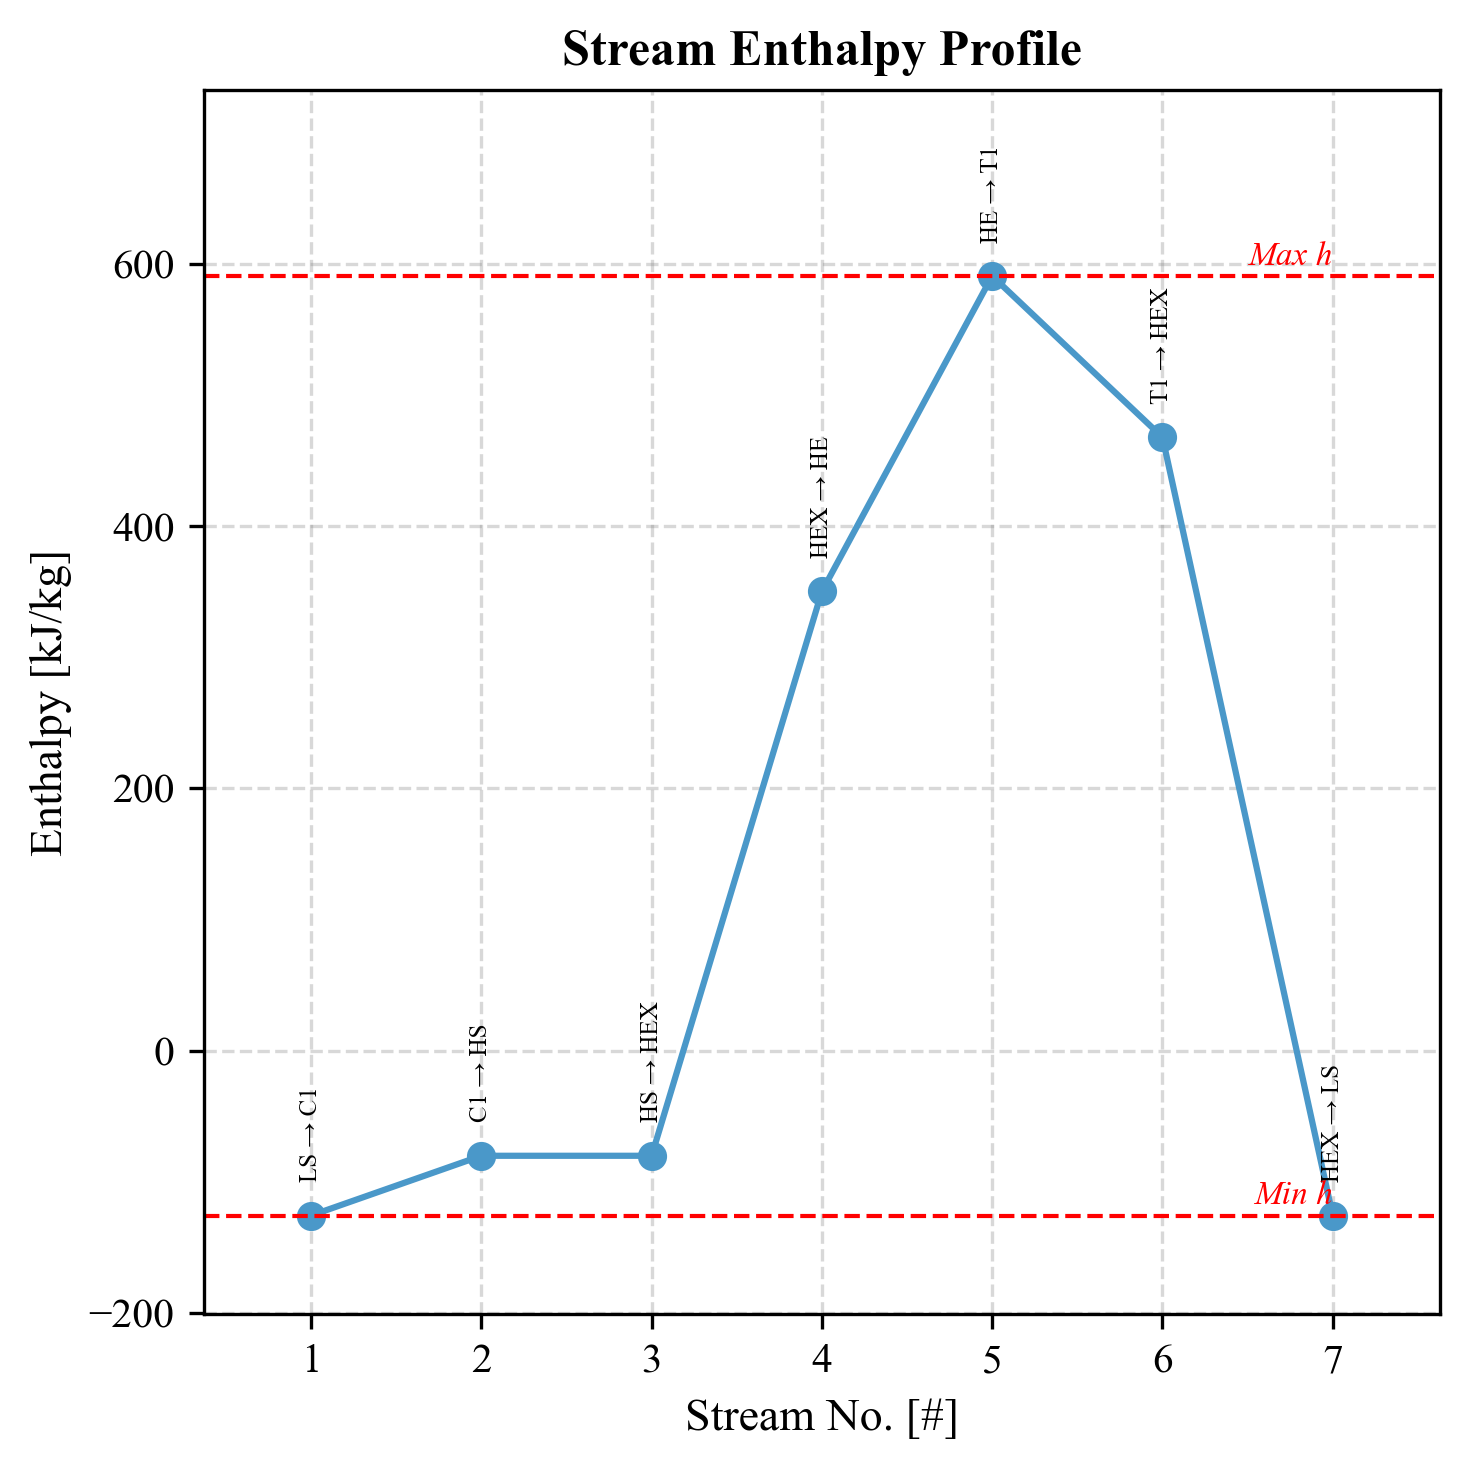

In [94]:
Thermodynamic_variable        = 'Enthalpy'
Thermodynamic_variable_symbol = 'h'
Units                         = 'kJ/kg'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

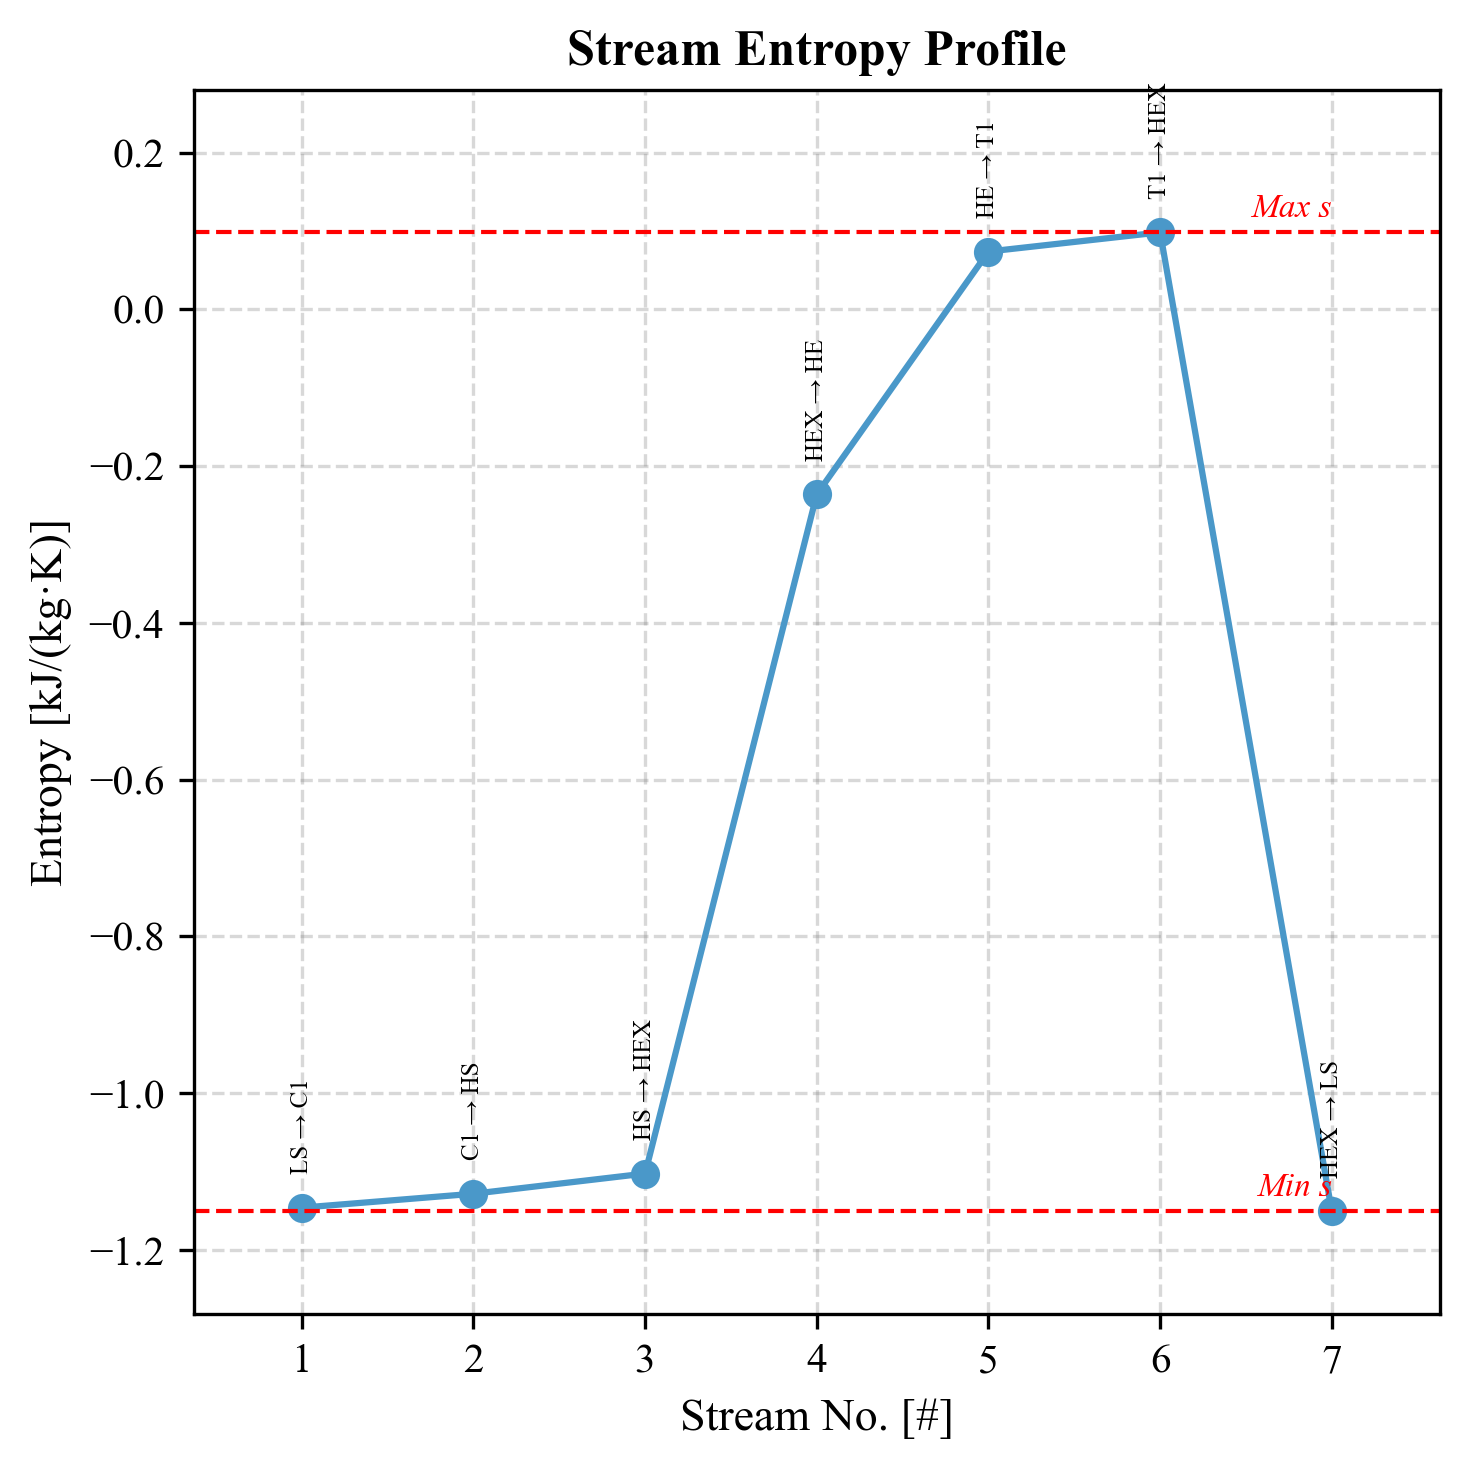

In [95]:
Thermodynamic_variable        = 'Entropy'
Thermodynamic_variable_symbol = 's'
Units                         = 'kJ/(kg·K)'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 0.03,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 0.03,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.22)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

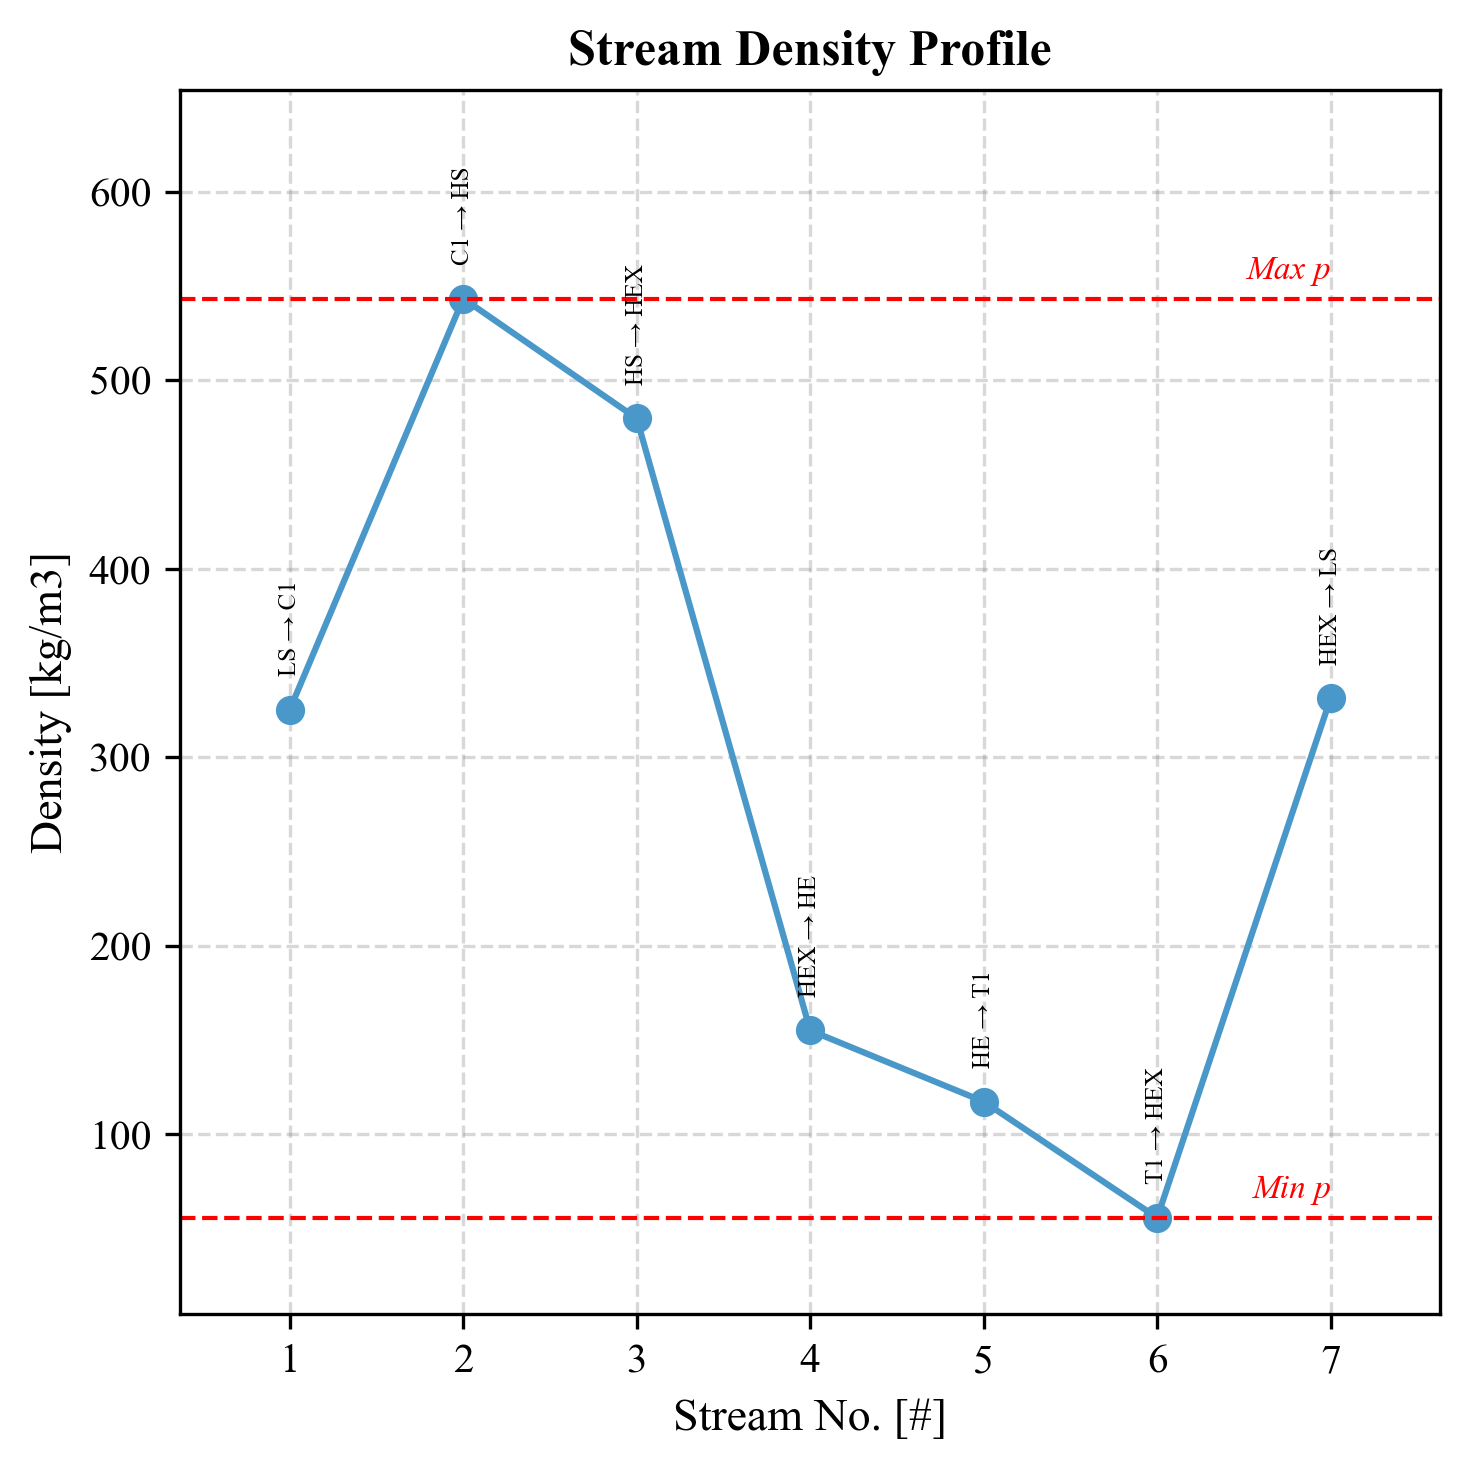

In [96]:
Thermodynamic_variable        = 'Density'
Thermodynamic_variable_symbol = 'p'
Units                         = 'kg/m3'
Figure_title                  = f'Stream {Thermodynamic_variable} Profile'


x_data = df['Stream_#'].astype(int); x_label = x_data.max(); y_data = df[Thermodynamic_variable_symbol]; Max_y  = y_data.max(); Min_y  = y_data.min()
cmap       = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel='Stream No. [#]',ylabel=f'{Thermodynamic_variable} [{Units}]',title=Figure_title,figsize=figsize_std,dpi=300)
point_labels = df['From_component'] + ' → ' + df['To_component']
for xi, yi, lbl in zip(x_data, y_data, point_labels):
    ax.annotate(lbl,xy=(xi, yi),xytext=(0, 8),textcoords='offset points',rotation=90,va='bottom',ha='center',fontsize=6,color='black')
ax.axhline(Max_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Max_y + 15,f'Max {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.axhline(Min_y, color='red', linestyle='--', linewidth=1); ax.text(x_label, Min_y + 15,f'Min {Thermodynamic_variable_symbol}',ha='right', va='center',fontsize=8,color='red',fontstyle='italic')
ax.set_xticks(x_data); ax.set_xticklabels(x_data, fontsize=10); ymin, ymax = ax.get_ylim(); ax.set_ylim(ymin, ymax * 1.1)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Cycle Visualizations

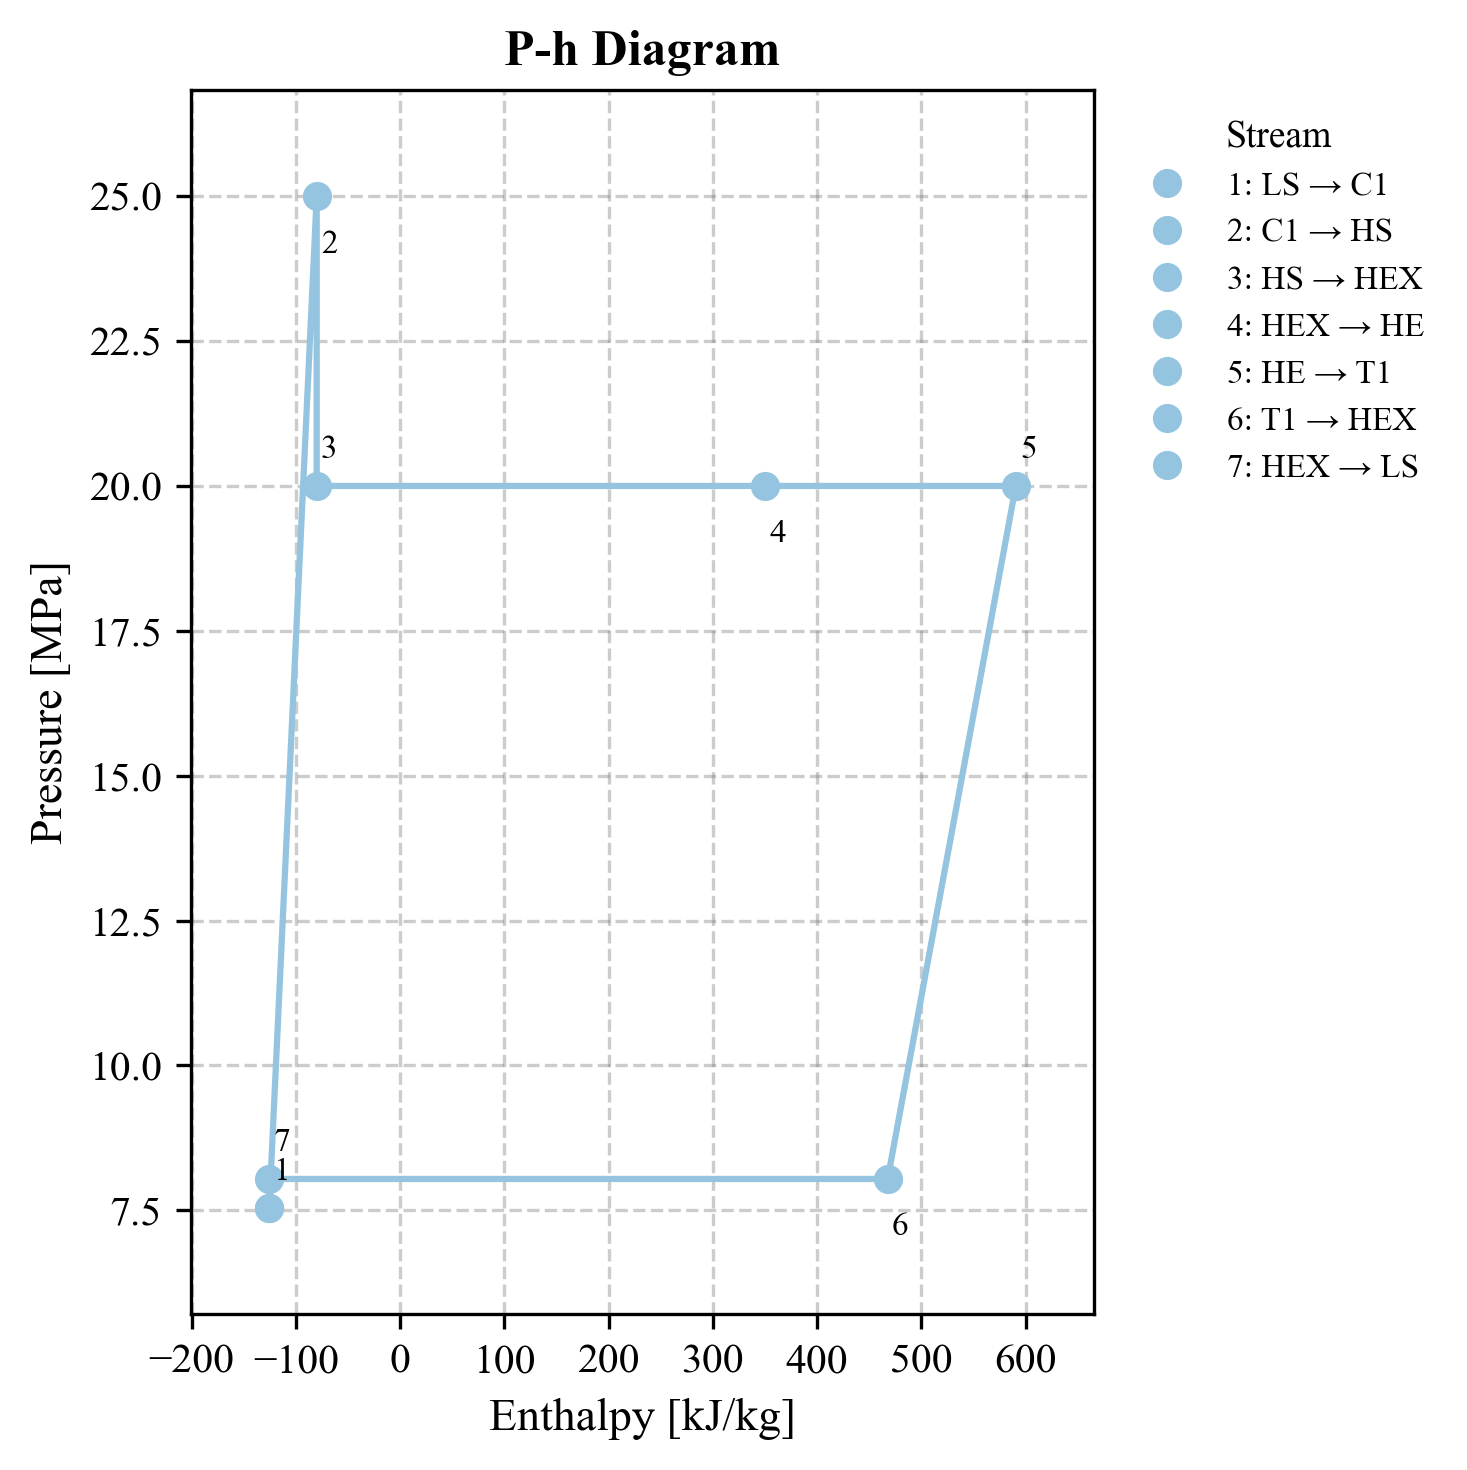

In [97]:
x_var         = 'Enthalpy'
x_var_sym     = 'h'
x_var_units   = 'kJ/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.4)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)
plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

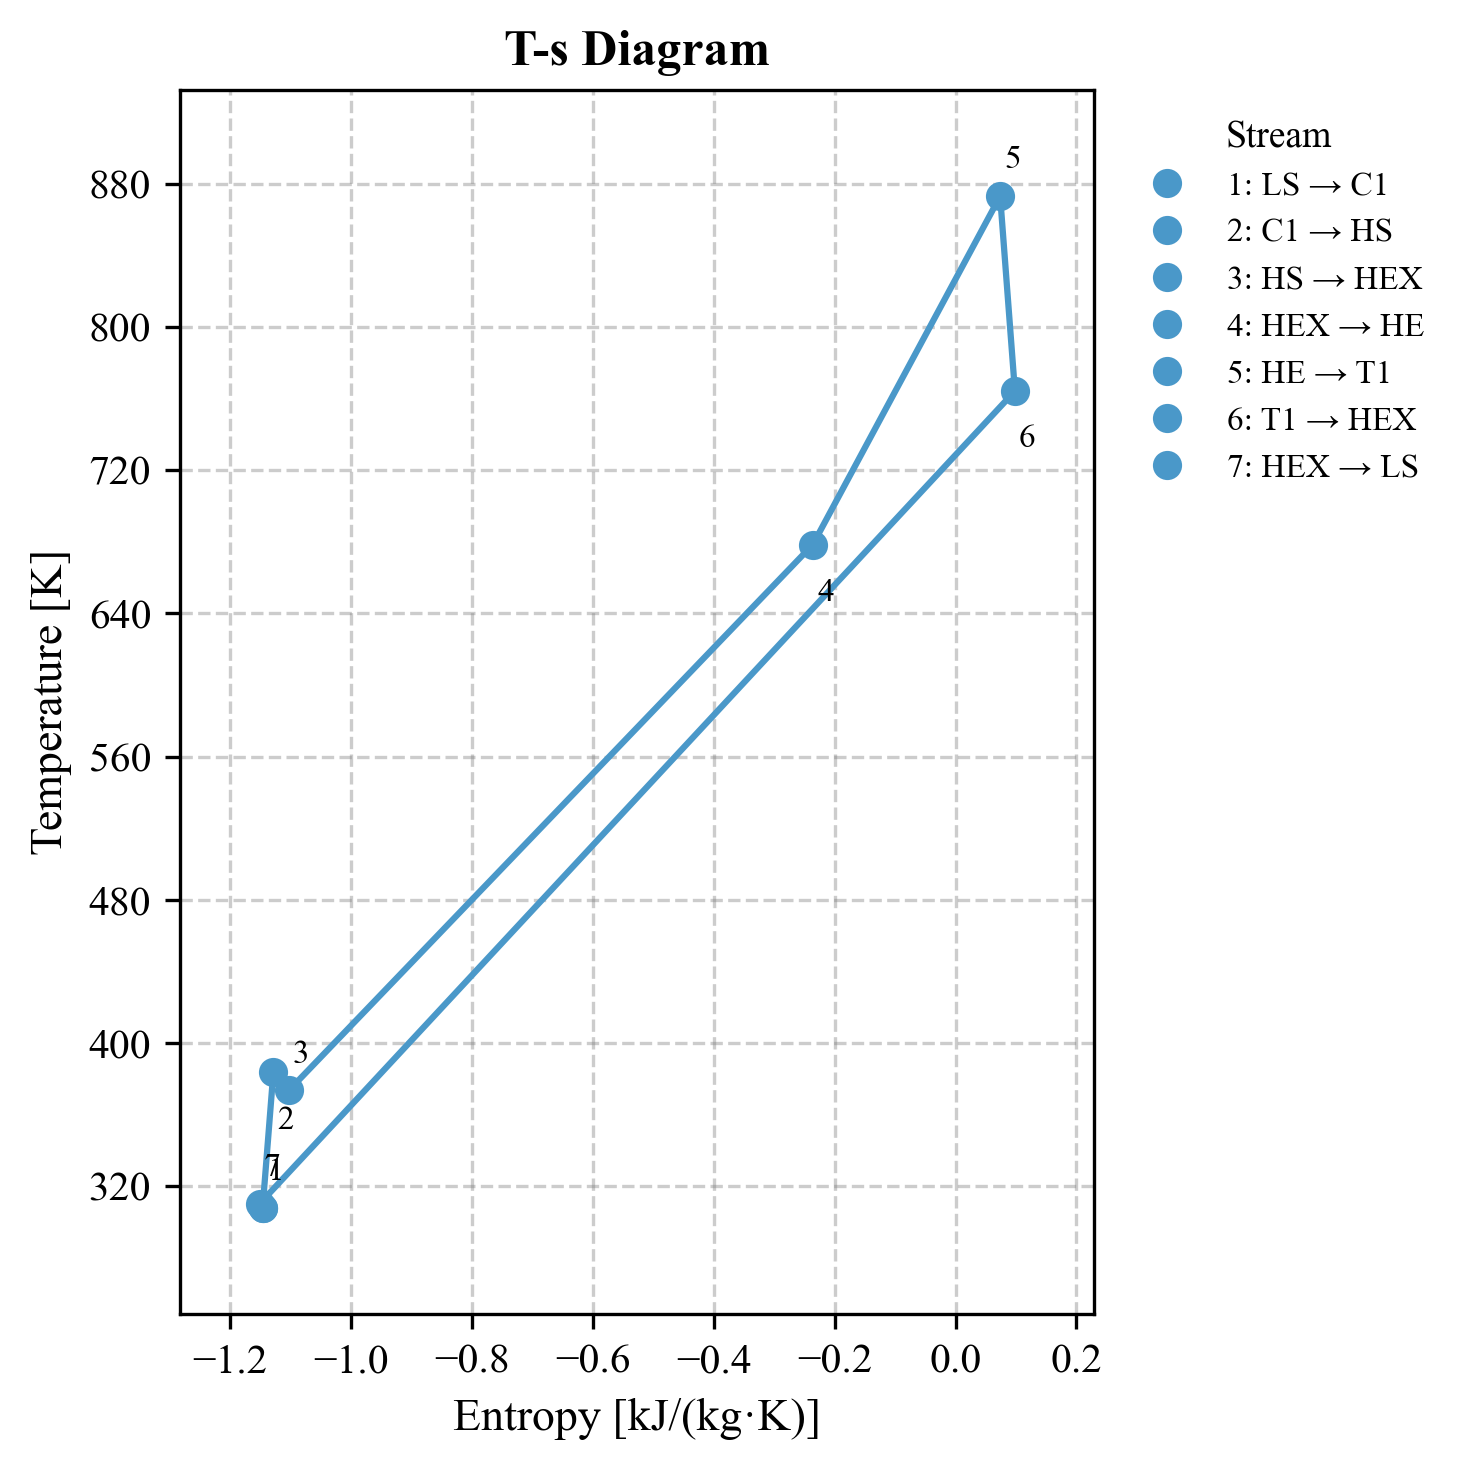

In [98]:
x_var         = 'Entropy'
x_var_sym     = 's'
x_var_units   = 'kJ/(kg·K)'
y_var         = 'Temperature'
y_var_sym     = 'T'
y_var_units   = 'K'
Figure_title  = f'{y_var_sym}-{x_var_sym} Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.6)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

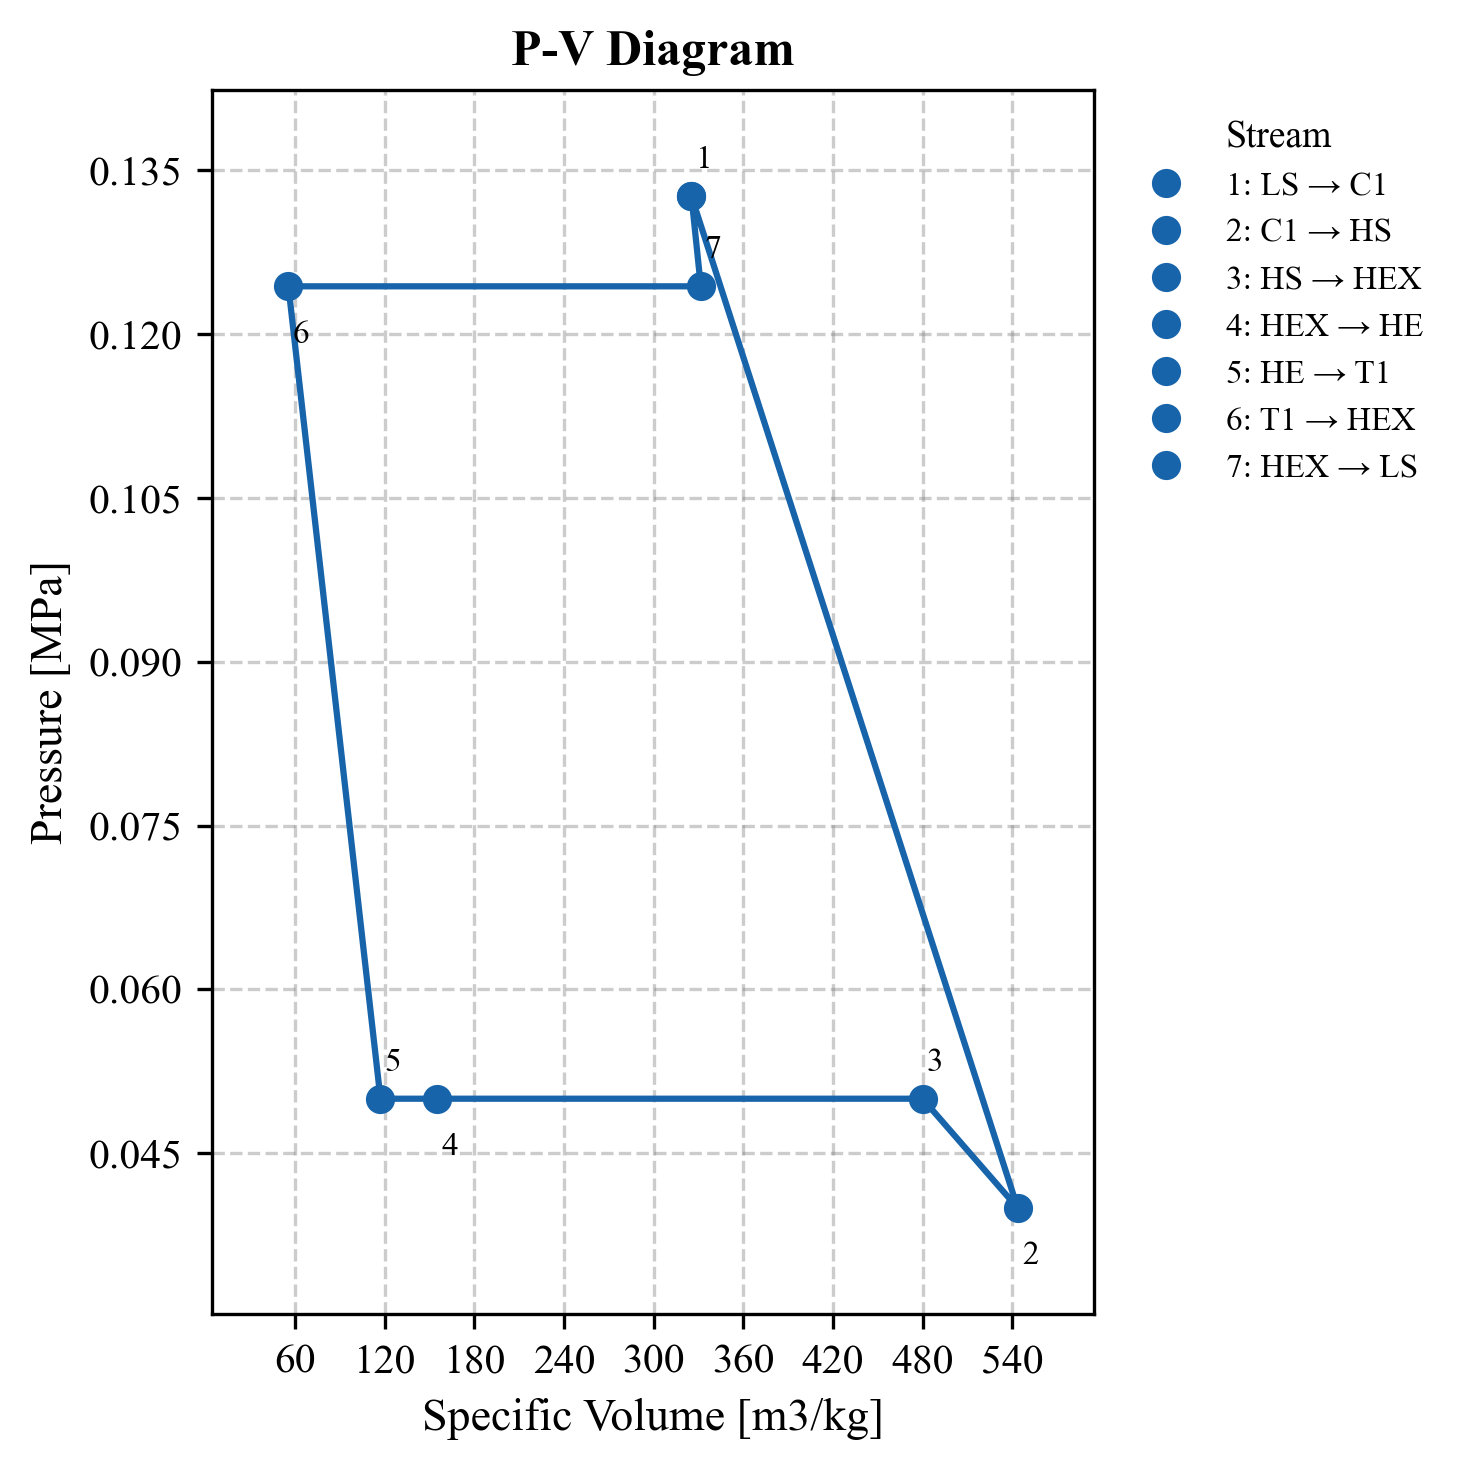

In [99]:
x_var         = 'Specific Volume'
x_var_sym     = 'p'
x_var_units   = 'm3/kg'
y_var         = 'Pressure'
y_var_sym     = 'P'
y_var_units   = 'MPa'
Figure_title  = f'{y_var_sym}-V Diagram'


x_orig      = df[x_var_sym].values; y_orig      = df[y_var_sym].values; y_orig = 1/y_orig; x_data      = np.append(x_orig, x_orig[0]); y_data      = np.append(y_orig, y_orig[0])
stream_nums   = df['Stream_#'].astype(int).values; stream_labels = df['From_component'] + ' → ' + df['To_component']

cmap      = plt.get_cmap('Blues'); line_color = cmap(0.8)
ax = quant_vis(x=x_data,y=y_data,kind='line',marker='o',color=line_color,xlabel=f'{x_var} [{x_var_units}]',ylabel=f'{y_var} [{y_var_units}]',title=Figure_title,figsize=figsize_std,dpi=300)
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax.yaxis.set_major_locator(MaxNLocator(nbins=10)); ax.grid(True, which='major', linestyle='--', alpha=0.4); offsets = [(3, 5), (3, -8)]
for i, (xi, yi, sn) in enumerate(zip(x_orig, y_orig, stream_nums)):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(str(sn),xy=(xi, yi),xytext=(dx, dy),textcoords='offset points',fontsize=8,color='black',ha='center',va='bottom' if dy > 0 else 'top')
handles = [Line2D([0], [0], marker='o', color=line_color, linestyle='') for _ in stream_nums]
legend_labels = [f"{sn}: {lbl}" for sn, lbl in zip(stream_nums, stream_labels)]; ax.legend(handles,legend_labels,title='Stream',loc='upper left',bbox_to_anchor=(1.01, 1),fontsize=8,title_fontsize=9,frameon=False)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

### Storage Visualizations

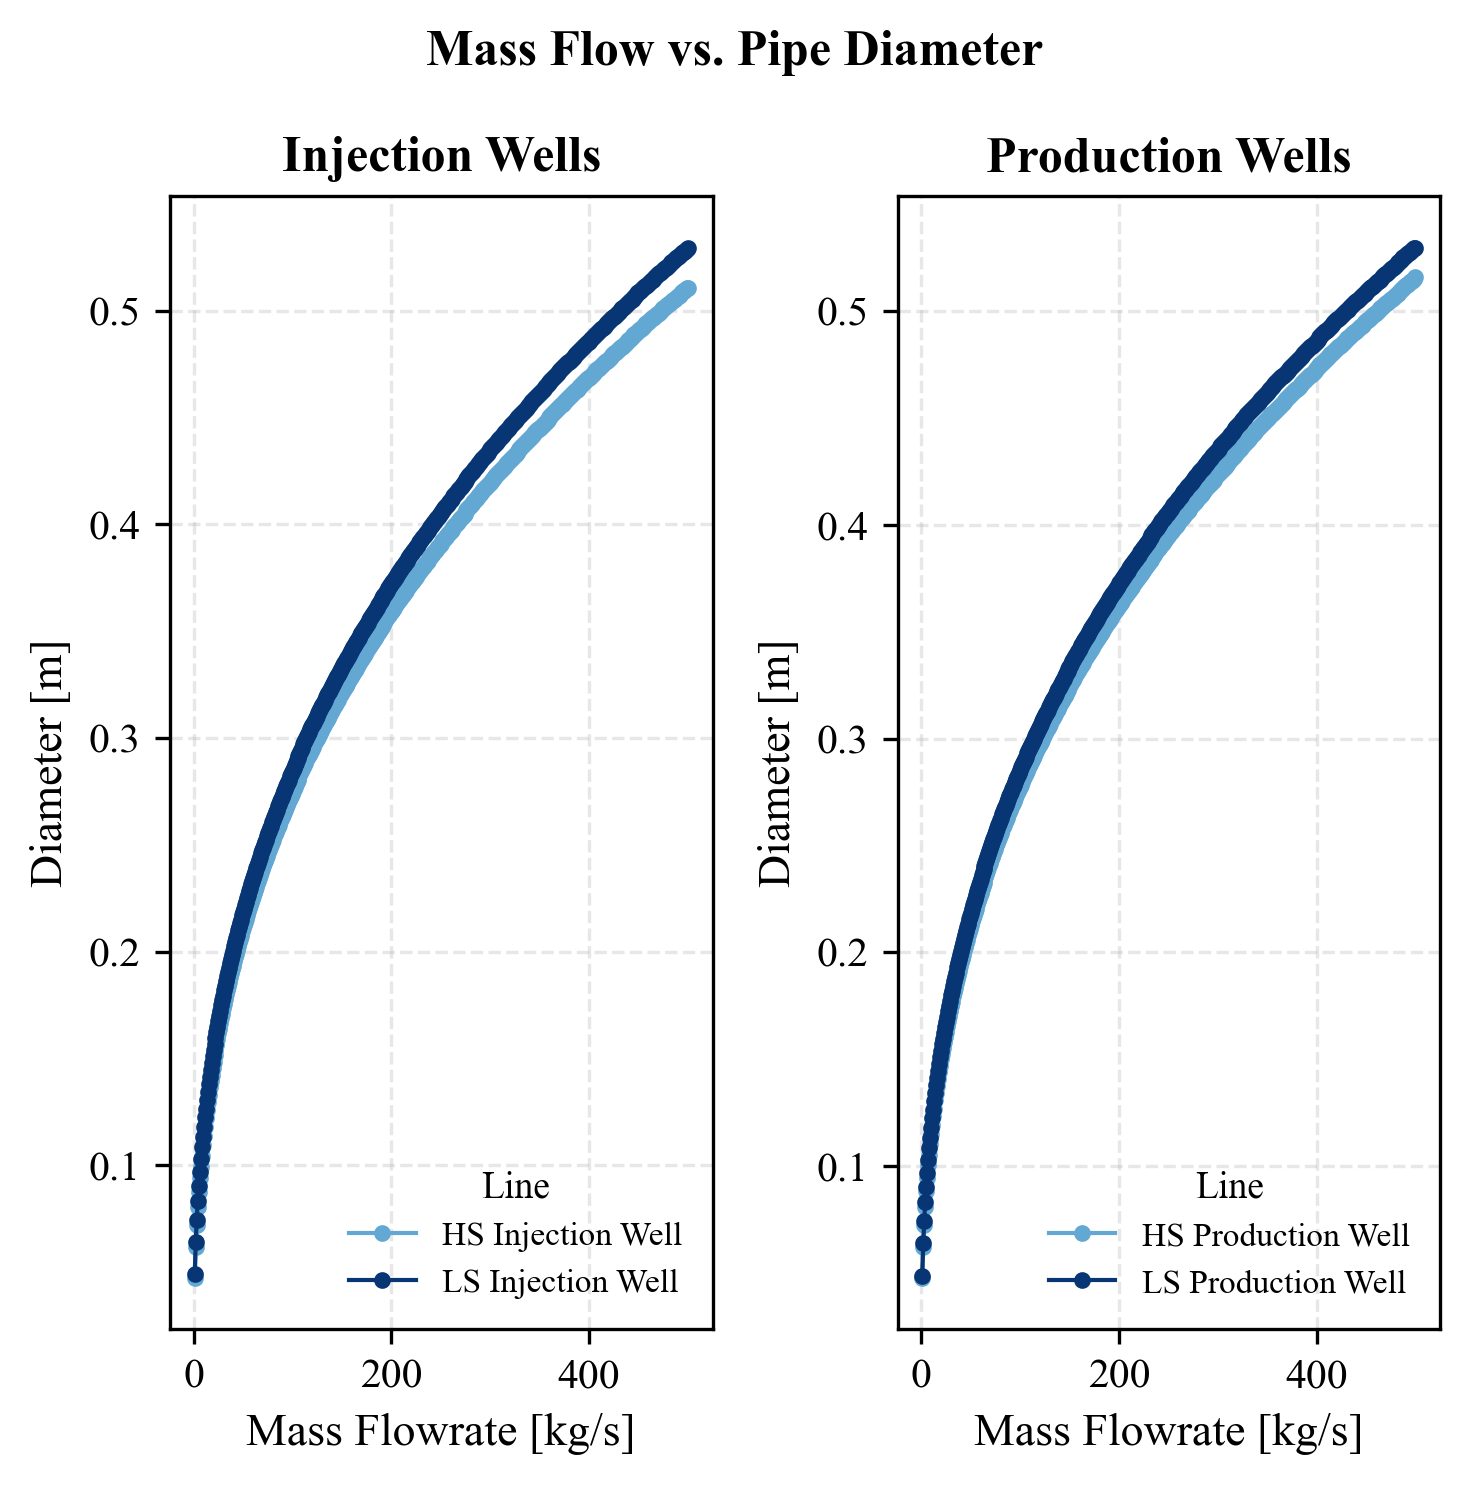

In [100]:
Figure_title = f'Required Well Diameters - fric:{gradP} MPa/m'
File_title = 'Required_Well_Diameters'

fig, axs = plt.subplots(ncols=2,figsize=figsize_std,dpi=300)

cmap   = plt.get_cmap('Blues'); hues   = np.linspace(0.3, 0.975, 4); colors = cmap(hues)
hs_color = colors[1]; ls_color = colors[3]
ax = axs[0]
ax.plot(dfDm_HS_inj_well['mdot'],dfDm_HS_inj_well['Dsol'],marker='o', markersize=3, linewidth=1,color=hs_color,label='HS Injection Well')
ax.plot(dfDm_LS_inj_well['mdot'],dfDm_LS_inj_well['Dsol'],marker='o', markersize=3, linewidth=1,color=ls_color,label='LS Injection Well')
ax.set_xlabel('Mass Flowrate [kg/s]', fontsize=11); ax.set_ylabel('Diameter [m]', fontsize=11); ax.set_title('Injection Wells', fontsize=12, fontweight='bold')
ax.grid(True, which='both', linestyle='--', alpha=0.3); ax.legend(title='Line', fontsize=8, title_fontsize=9, frameon=False, loc = 'lower right')
ax = axs[1]
ax.plot(dfDm_HS_prod_well['mdot'],dfDm_HS_prod_well['Dsol'],marker='o', markersize=3, linewidth=1,color=hs_color,label='HS Production Well')
ax.plot(dfDm_LS_prod_well['mdot'],dfDm_LS_prod_well['Dsol'],marker='o', markersize=3, linewidth=1,color=ls_color,label='LS Production Well')
ax.set_xlabel('Mass Flowrate [kg/s]', fontsize=11); ax.set_ylabel('Diameter [m]', fontsize=11); ax.set_title('Production Wells', fontsize=12, fontweight='bold')
ax.grid(True, which='both', linestyle='--', alpha=0.3); ax.legend(title='Line', fontsize=8, title_fontsize=9, frameon=False, loc = 'lower right')
fig.suptitle(f'{Figure_title}', fontsize=12, fontweight='bold', y=0.98); fig.subplots_adjust(top=0.88); fig.suptitle('Mass Flow vs. Pipe Diameter', fontsize=12, fontweight='bold'); plt.tight_layout(rect=[0, 0, 1, 1.02])

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

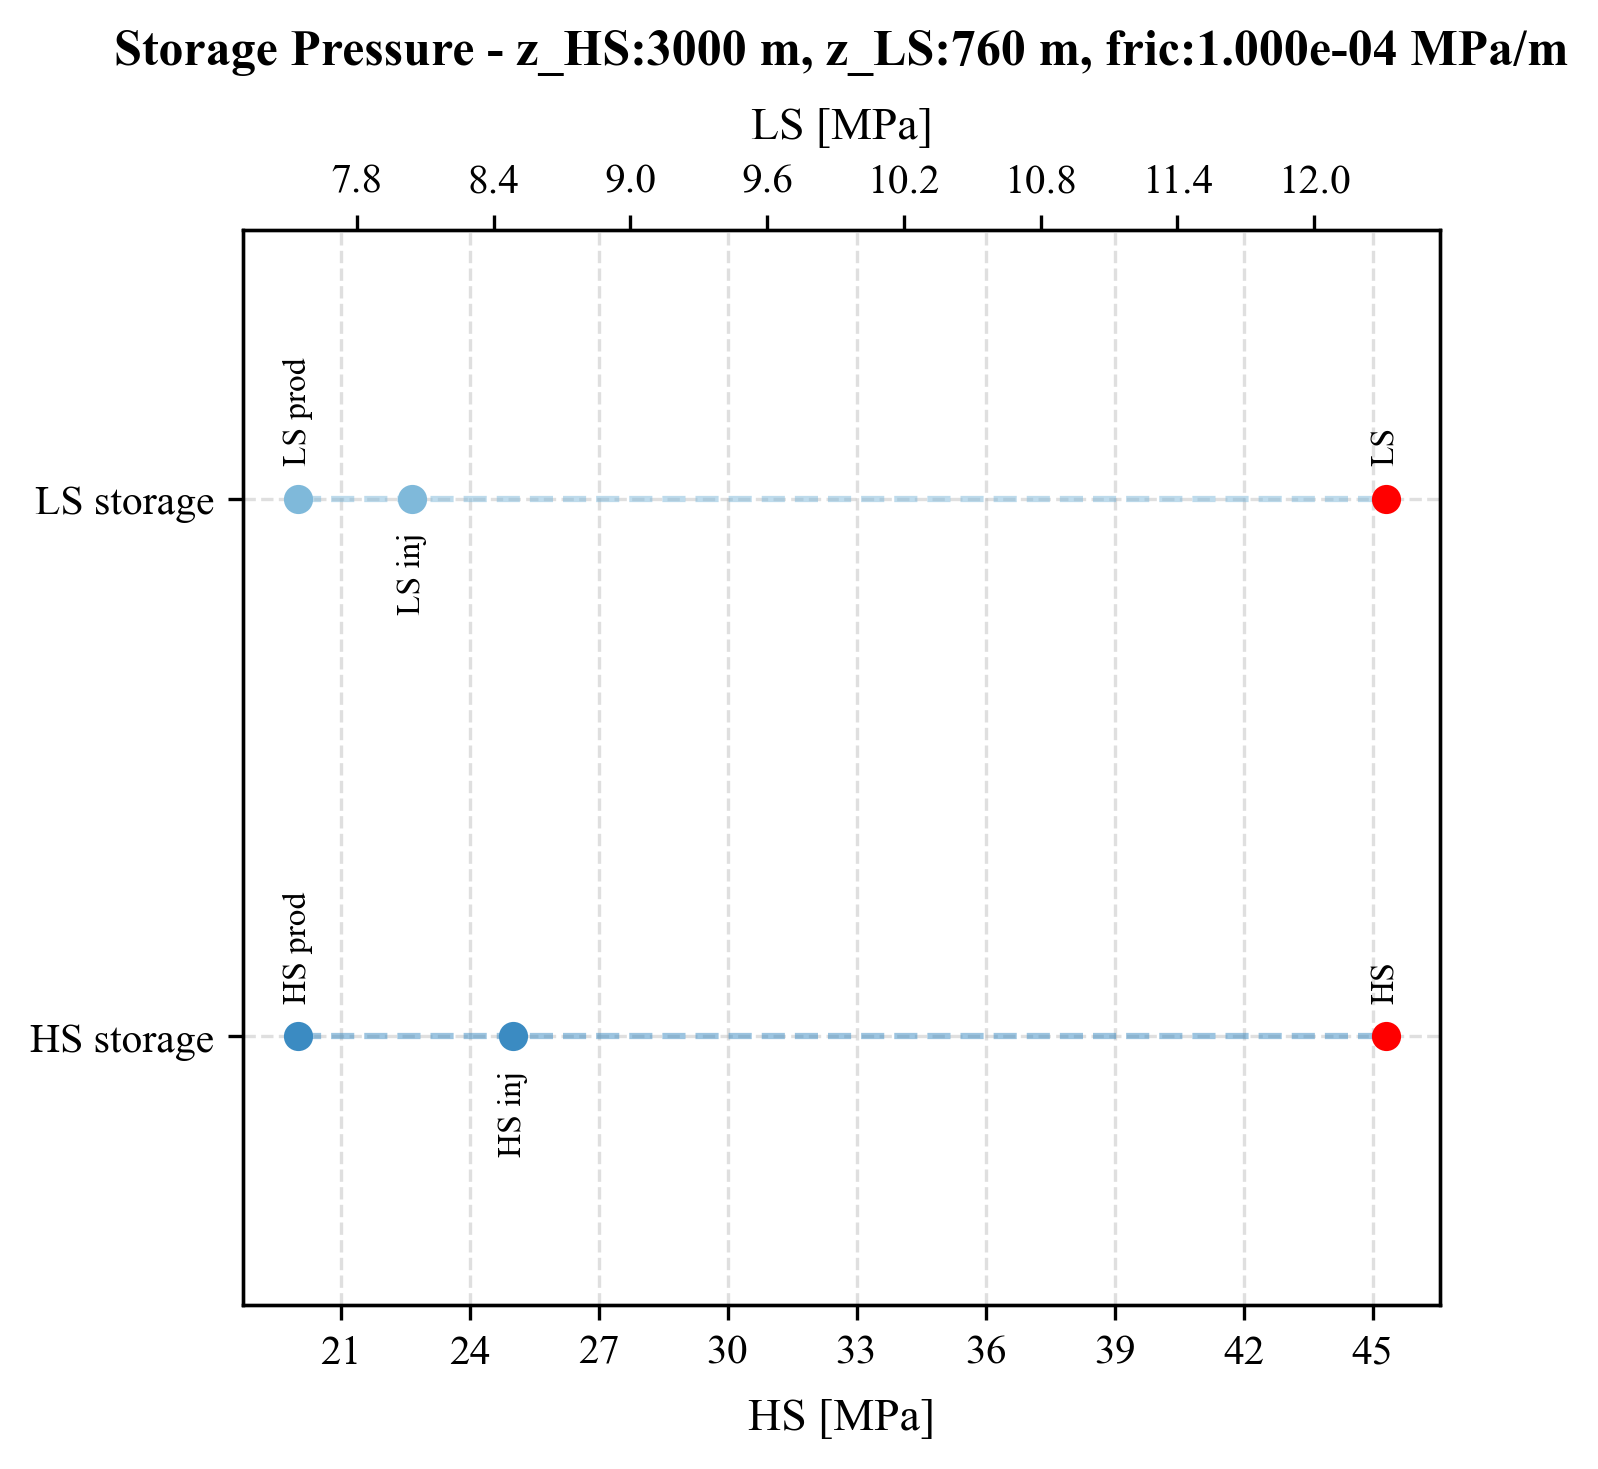

In [101]:
x_var       = 'Pressure'        
x_var_sym   = 'P'               
x_var_units = 'MPa'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

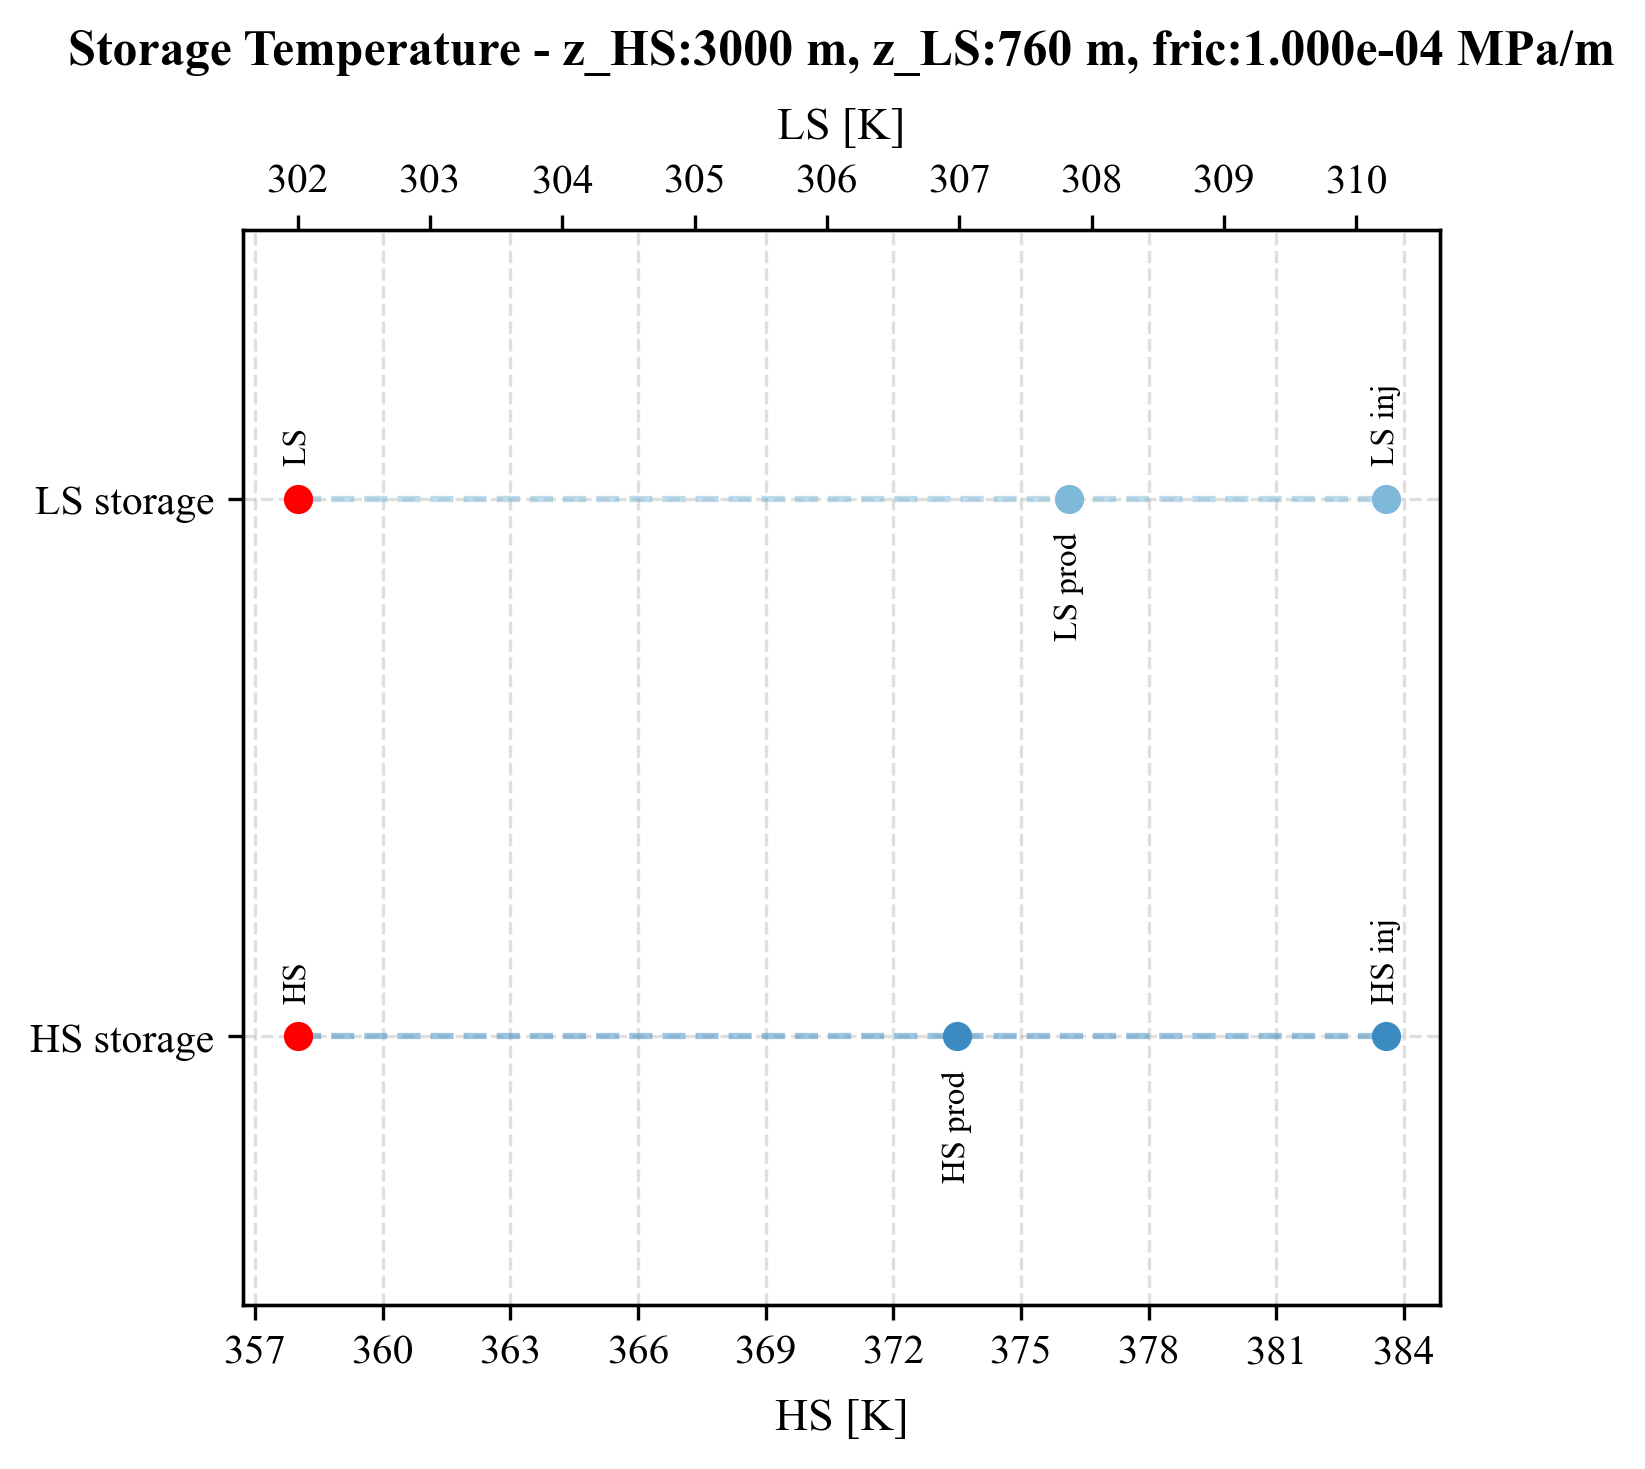

In [102]:
x_var       = 'Temperature'        
x_var_sym   = 'T'               
x_var_units = 'K'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

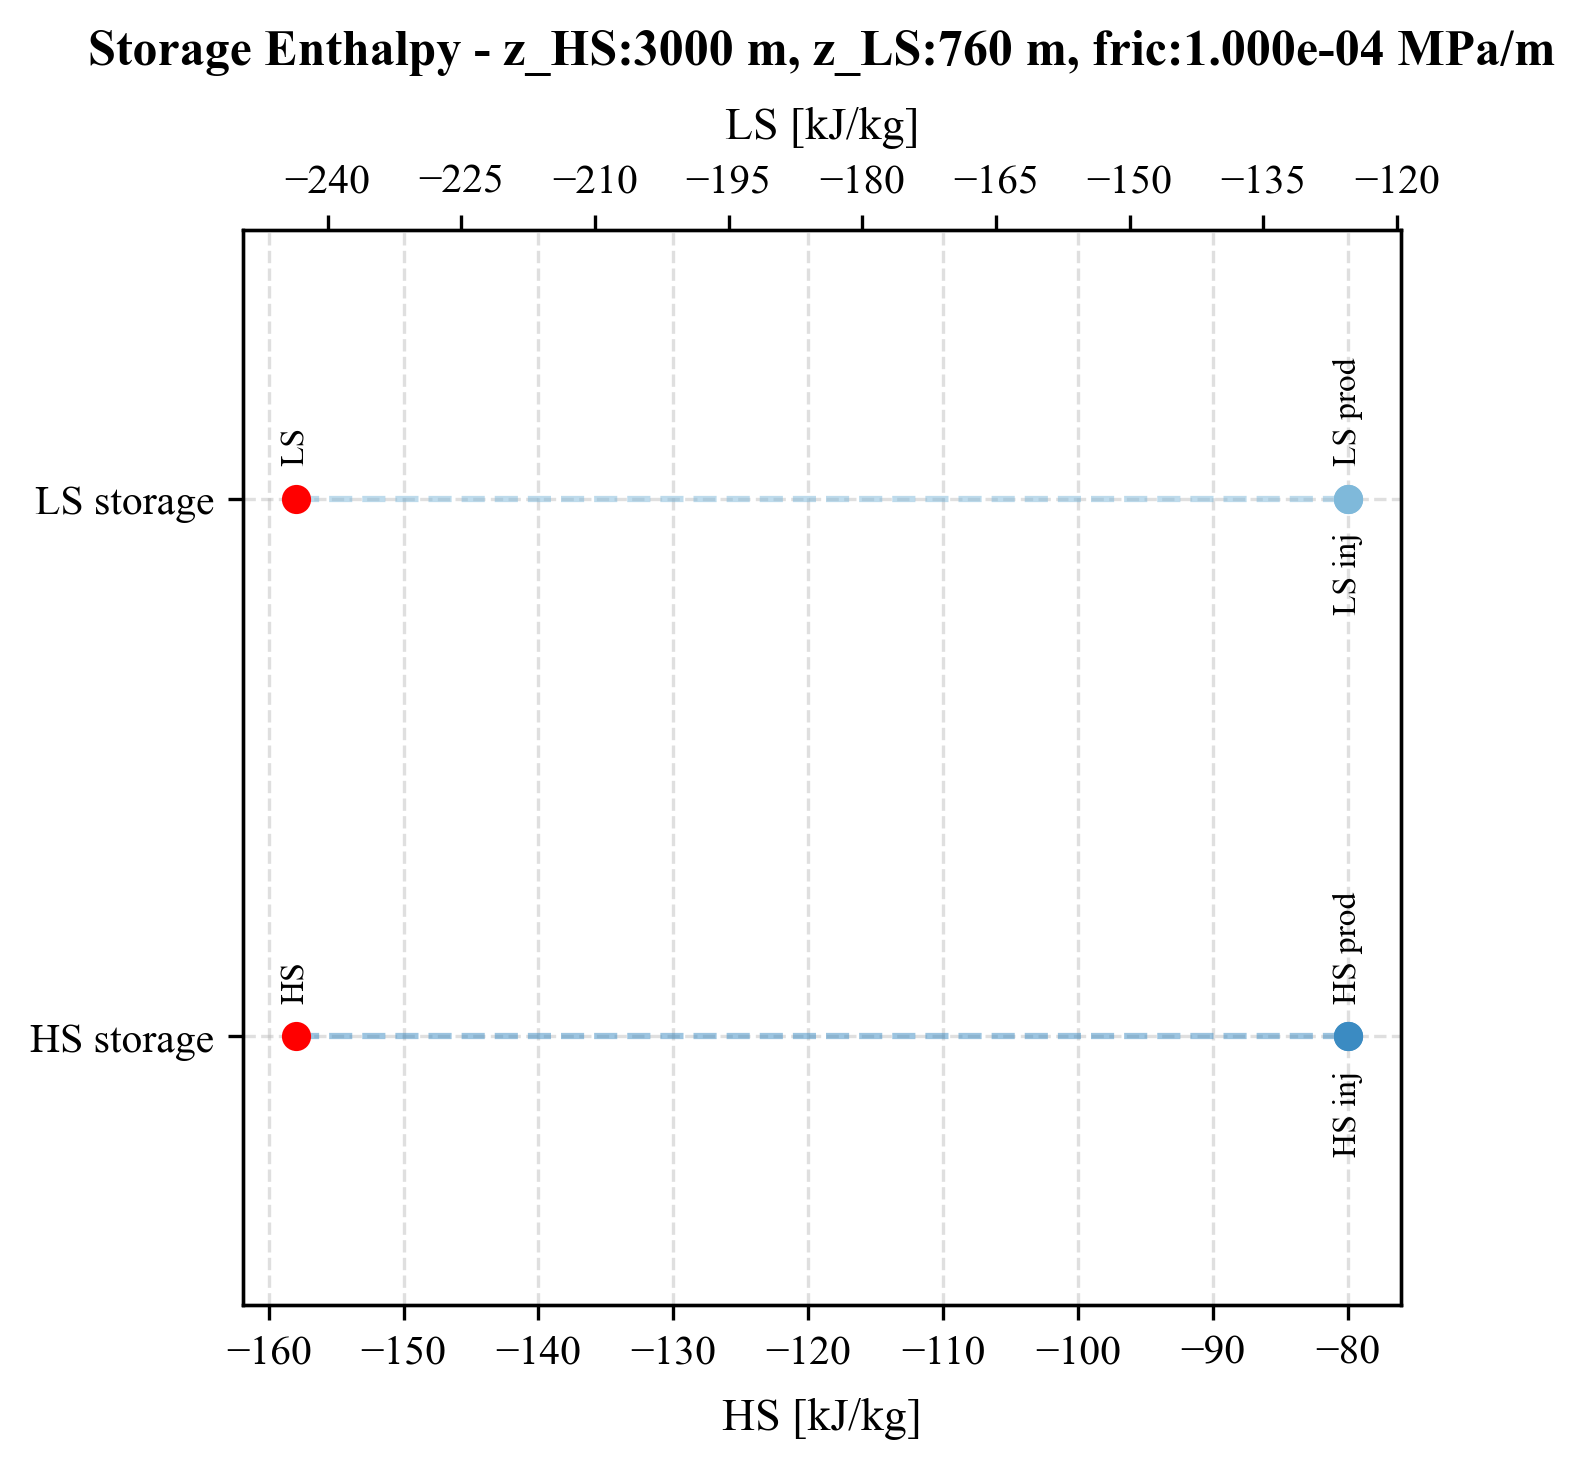

In [103]:
x_var       = 'Enthalpy'        
x_var_sym   = 'h'               
x_var_units = 'kJ/kg'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

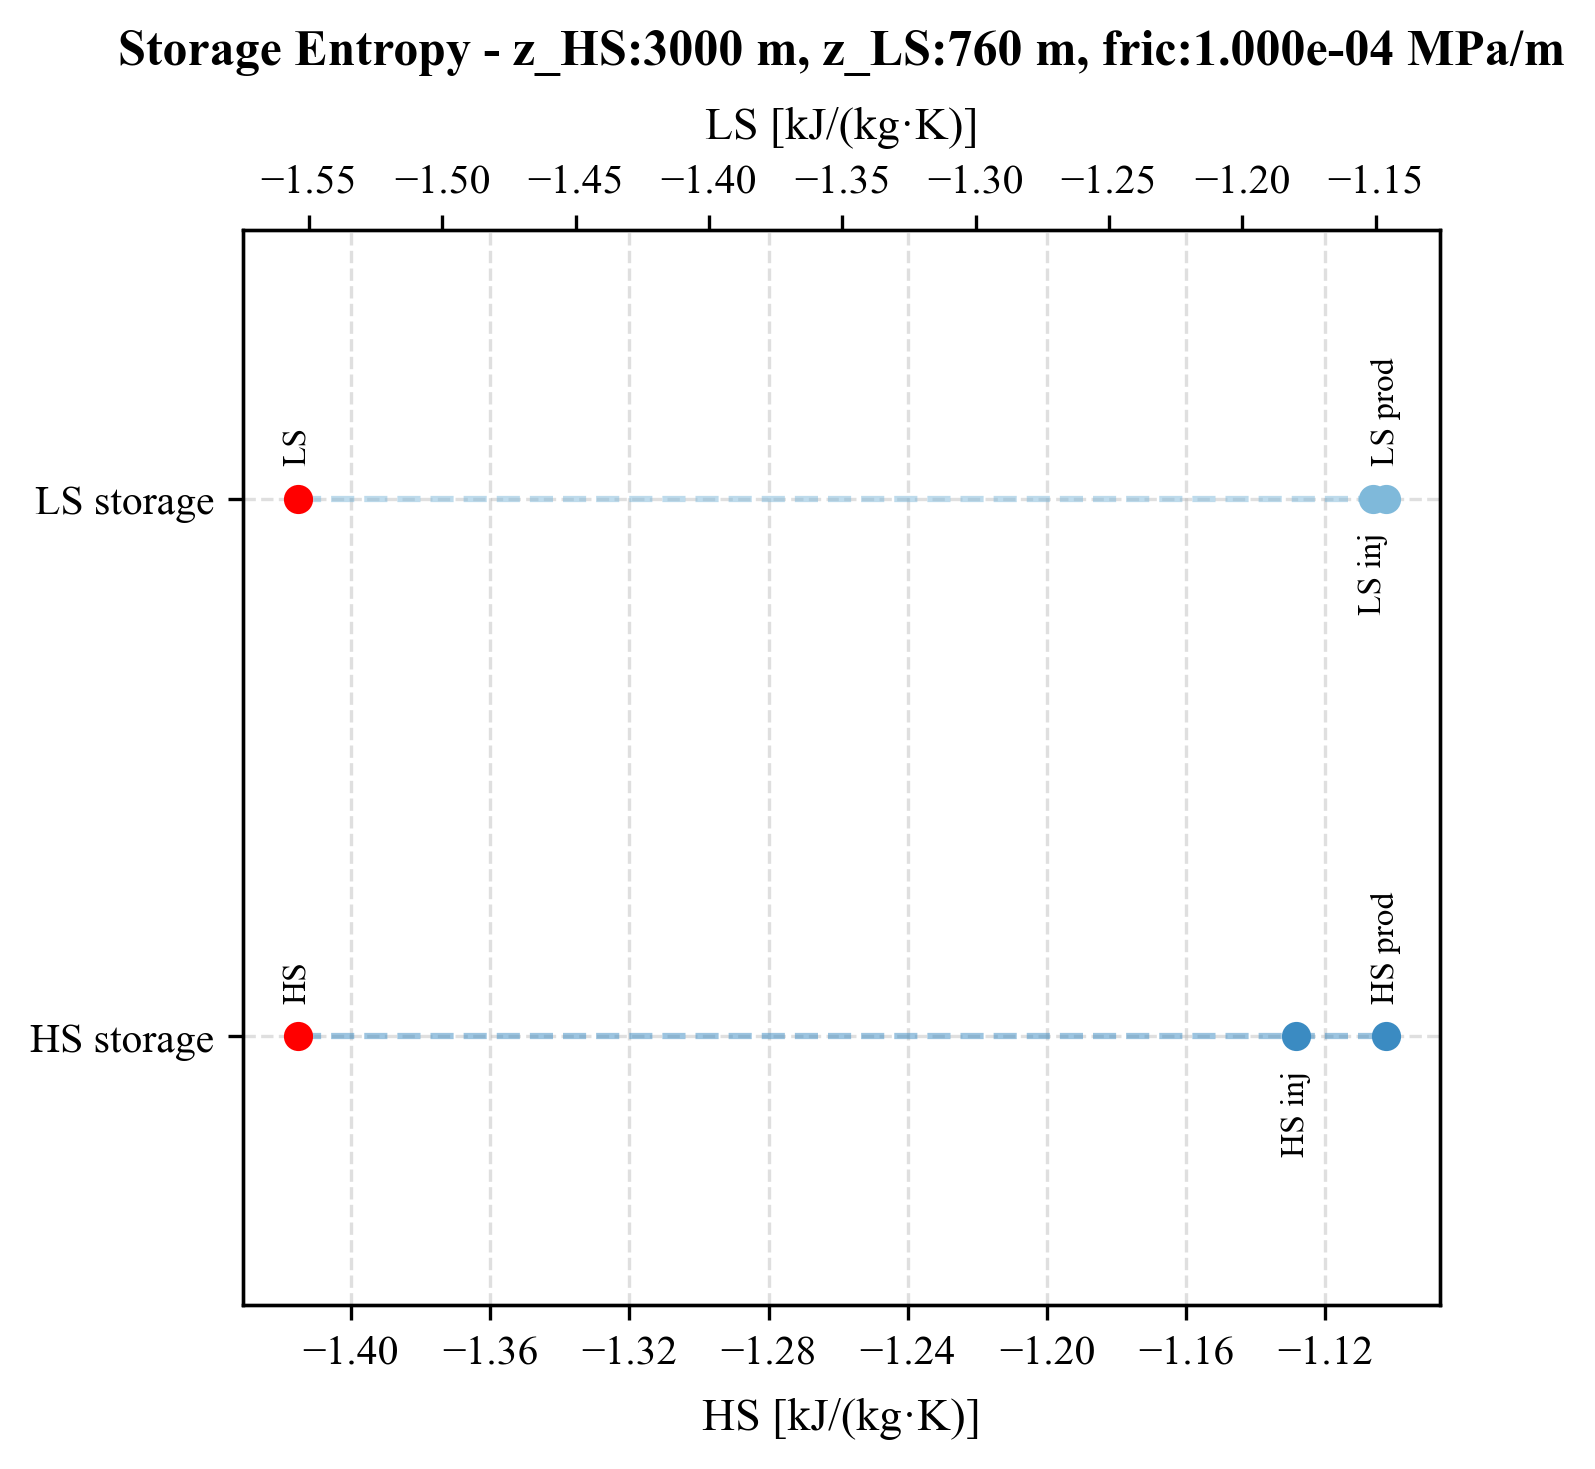

In [104]:
x_var       = 'Entropy'        
x_var_sym   = 's'               
x_var_units = 'kJ/(kg·K)'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)

plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

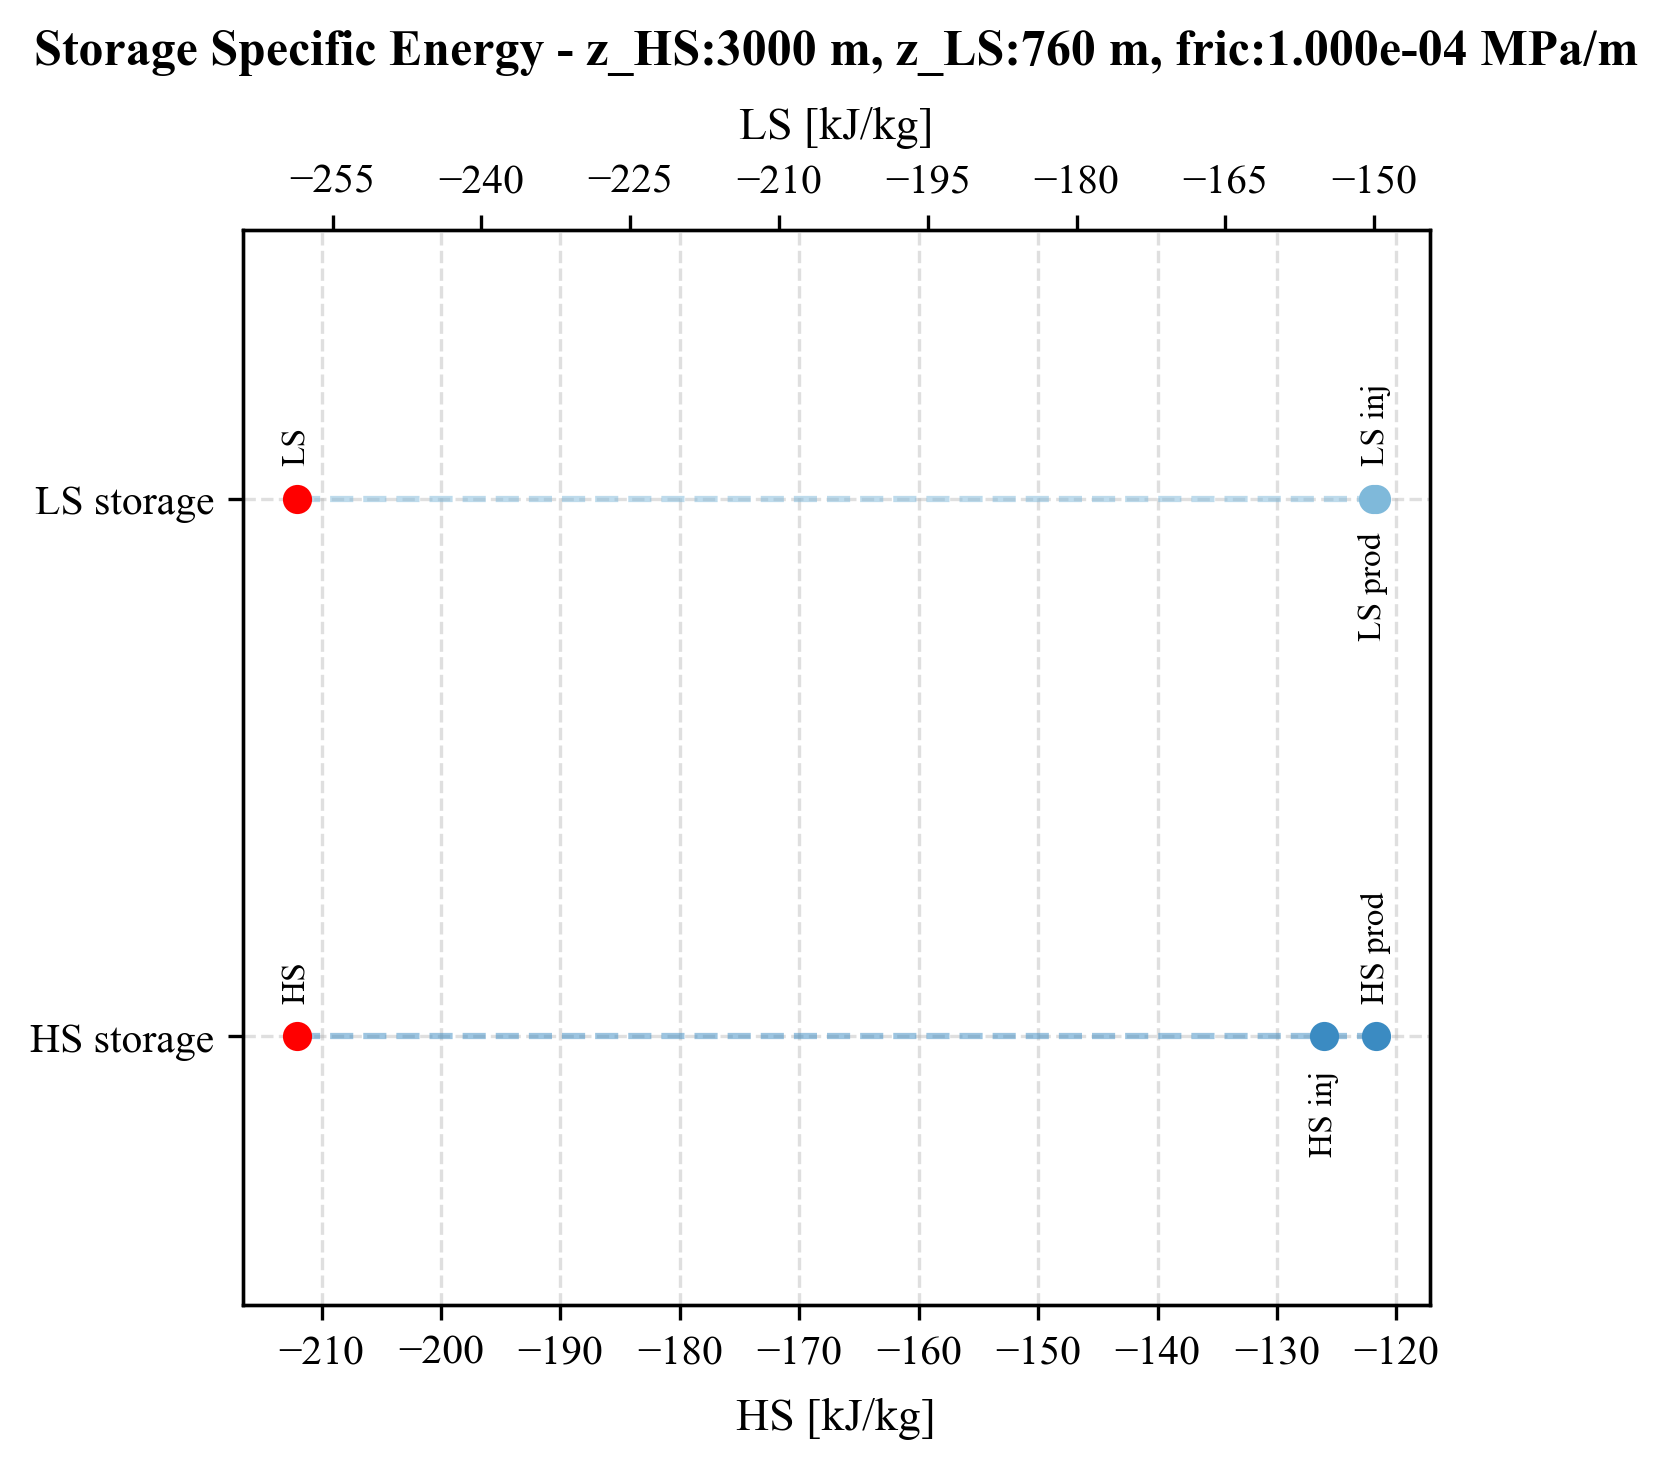

In [105]:
x_var       = 'Specific Energy'        
x_var_sym   = 'e'               
x_var_units = 'kJ/kg'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

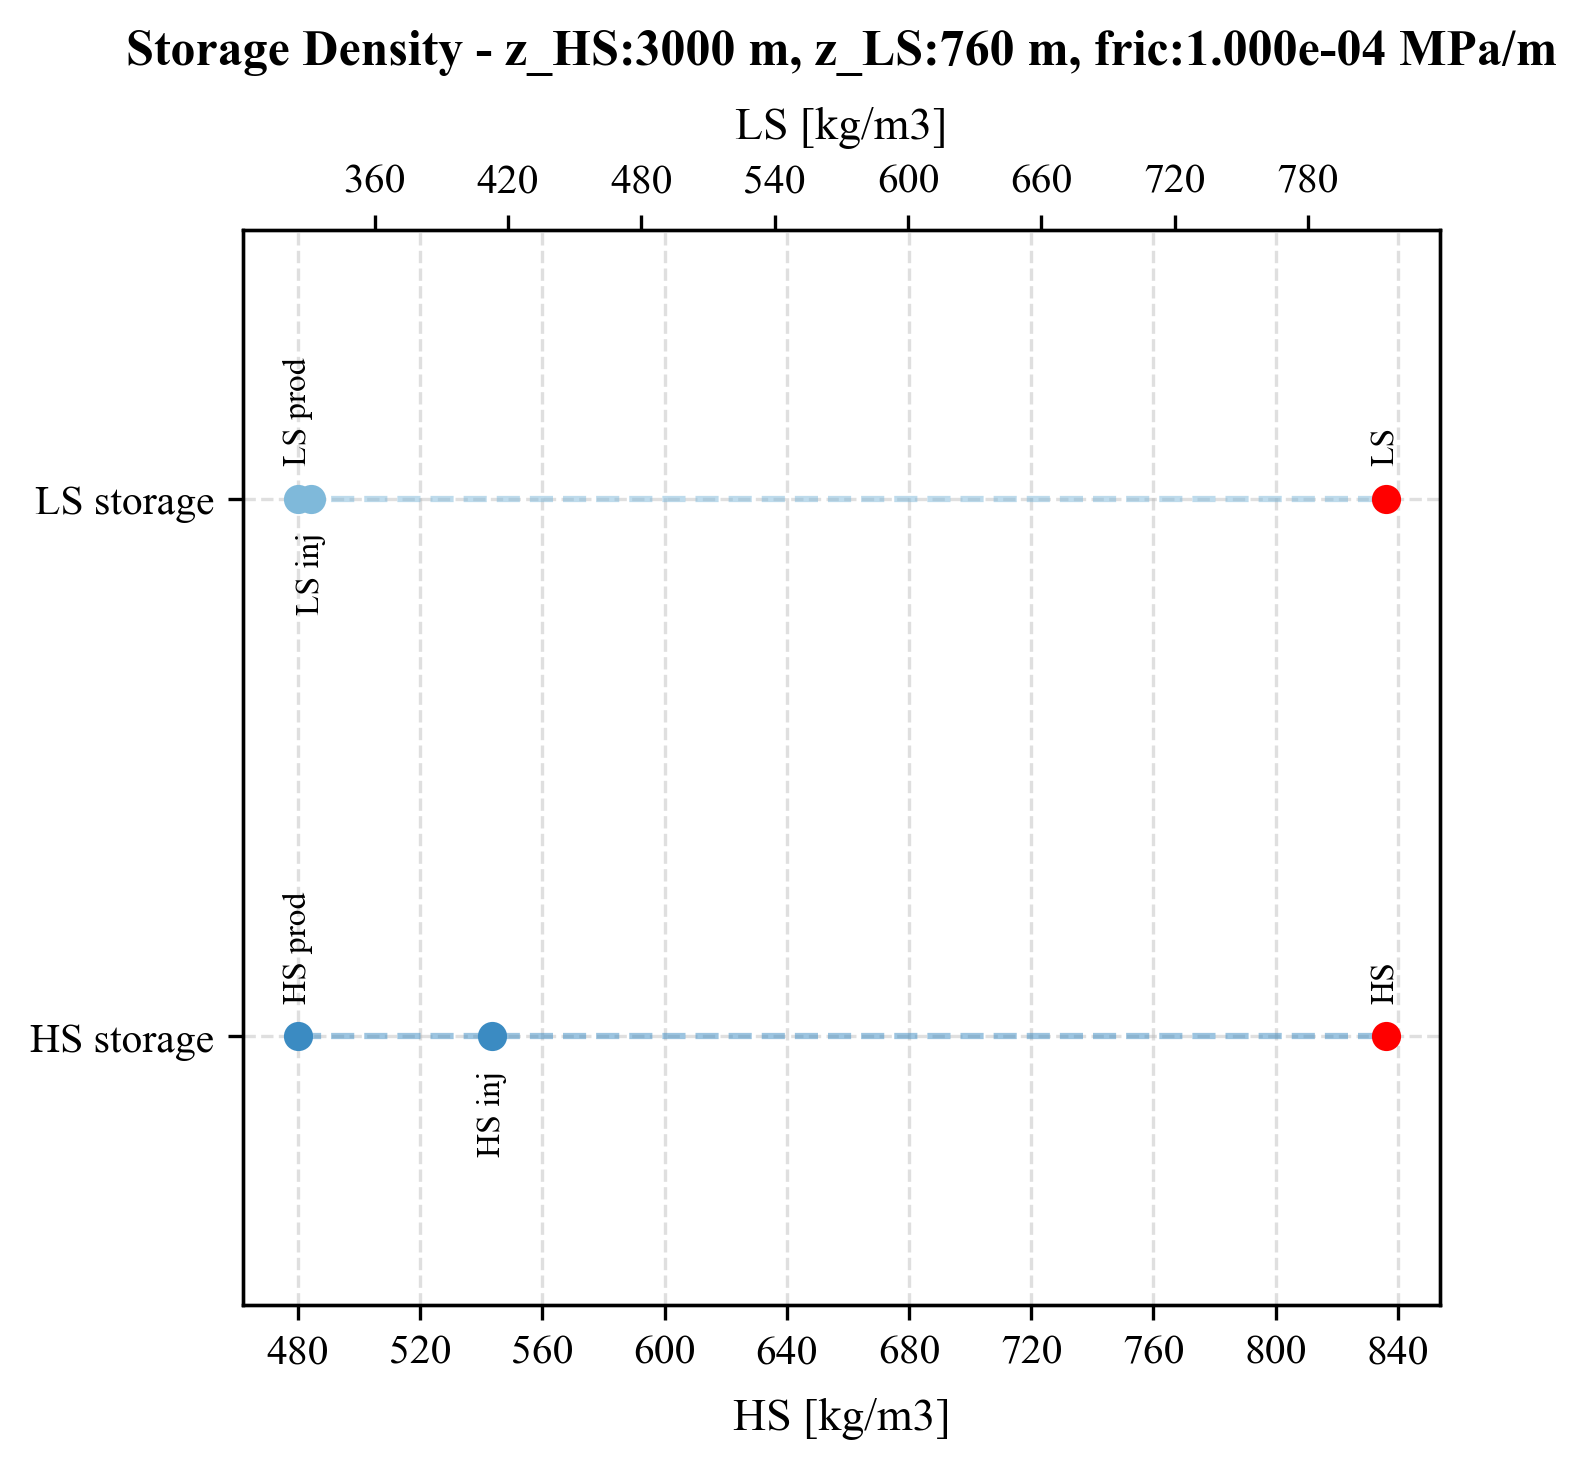

In [106]:
x_var       = 'Density'        
x_var_sym   = 'p'               
x_var_units = 'kg/m3'            
Figure_title = f"Storage {x_var} - z_HS:{z_HS} m, z_LS:{z_LS} m, fric:{gradP:.3e} MPa/m"
File_title = f'Storage_{x_var}s'

ls_inj    = dffull.loc[dffull.To_component=='LS',   'Stream_#'].iat[0]; ls_prod   = dffull.loc[dffull.From_component=='LS', 'Stream_#'].iat[0]
hs_inj    = dffull.loc[dffull.To_component=='HS',   'Stream_#'].iat[0]; hs_prod   = dffull.loc[dffull.From_component=='HS', 'Stream_#'].iat[0]
hs_char, ls_char = sorted(dffull.loc[dffull.Orientation.isna(), 'Stream_#']); dfi       = dffull.set_index('Stream_#')
hs_streams = [hs_inj, hs_char, hs_prod]; ls_streams = [ls_inj, ls_char, ls_prod]
x_hs       = dfi.loc[hs_streams, x_var_sym].values; x_ls       = dfi.loc[ls_streams, x_var_sym].values
def expand(vals):
    lo, hi = vals.min(), vals.max(); rng = hi - lo
    return lo - 0.05*rng, hi + 0.05*rng
hs_xlim = expand(x_hs); ls_xlim = expand(x_ls)

fig, ax_hs = plt.subplots(figsize=figsize_std, dpi=300) 
cmap       = plt.get_cmap('Blues'); hs_base    = cmap(0.65); ls_base    = cmap(0.45); hs_cols = [hs_base, 'red', hs_base]; ls_cols    = [ls_base, 'red', ls_base]
role       = {hs_inj:  'HS inj',  hs_char: 'HS',      hs_prod: 'HS prod',ls_inj:  'LS inj',  ls_char: 'LS',      ls_prod: 'LS prod'}; offsets    = [8, -8]
ax_ls      = ax_hs.twiny()
ax_hs.hlines(0, x_hs.min(), x_hs.max(), linestyles='--', alpha=0.5, color=hs_base)
for xx, col in zip(x_hs, hs_cols):
    ax_hs.scatter(xx, 0, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_hs, hs_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_hs.annotate(role[s],xy=(xx, 0),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_hs.set_xlim(*hs_xlim); ax_hs.set_xlabel(f"HS [{x_var_units}]", labelpad=6); ax_ls.hlines(1, x_ls.min(), x_ls.max(), linestyles='--', alpha=0.5, color=ls_base)
for xx, col in zip(x_ls, ls_cols):
    ax_ls.scatter(xx, 1, color=col, zorder=3)
for idx, (xx, s) in enumerate(sorted(zip(x_ls, ls_streams), key=lambda t: t[0])):
    dy = offsets[idx % 2]; ax_ls.annotate(role[s],xy=(xx, 1),xytext=(0, dy),textcoords='offset points',rotation=90,va='bottom' if dy>0 else 'top',ha='center',fontsize=8)
ax_ls.set_xlim(*ls_xlim); ax_ls.xaxis.set_label_position('top'); ax_ls.xaxis.set_ticks_position('top'); ax_ls.set_xlabel(f"LS [{x_var_units}]", labelpad=6)
ax_hs.set_yticks([0, 1]); ax_hs.set_yticklabels(['HS storage', 'LS storage']); ax_hs.set_ylim(-0.5, 1.5)
ax_hs.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_ls.xaxis.set_major_locator(MaxNLocator(nbins=10)); ax_hs.grid(True, which='major', linestyle='--', alpha=0.4); ax_hs.set_title(Figure_title, pad=10)


plt.tight_layout(); out_path = fig_dir / f"{File_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

In [107]:
from matplotlib.ticker import FuncFormatter

def visualize_QSS(df, series_left, left_label, left_units,
                  series_right=None, right_label=None, right_units=None,
                  separate_axes=True, title="QSS Time Series",
                  figsize=figsize_std, dpi=300, cmap_name="Blues"):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter

    # Settlement period and time labels
    sp = np.arange(1, 49)
    time_labels = [f"{h:02d}:{'00' if i%2==0 else '30'}:00"
                   for i in range(48) for h in [i//2]][:48]

    # Series colors
    left_colors = plt.get_cmap(cmap_name)(np.linspace(0.45, 0.85, len(series_left)))
    right_colors = (plt.get_cmap('Greens')(
        np.linspace(0.45, 0.85, len(series_right))) if series_right else [])

    # Axis highlight colors (distinct from series)
    axis_left_color = 'navy'      # dark blue
    axis_right_color = 'darkgreen'

    fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    handles, labels = [], []

    # Left-axis series
    for i, col in enumerate(series_left):
        h, = ax1.plot(sp, df[col], 'o-', color=left_colors[i], markersize=3, linewidth=1)
        handles.append(h)
        labels.append(col)
    ax1.set_ylabel(f"{left_label} {left_units}")
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3g}"))

    # Color left spine & labels uniform
    ax1.spines['left'].set_color(axis_left_color)
    ax1.yaxis.label.set_color(axis_left_color)
    ax1.tick_params(axis='y', colors=axis_left_color)

    # Right-axis series
    ax2 = ax1
    if separate_axes and series_right:
        ax2 = ax1.twinx()
        for j, col in enumerate(series_right, start=len(series_left)):
            idx = j - len(series_left)
            h, = ax2.plot(sp, df[col], 'o-', color=right_colors[idx], markersize=3, linewidth=1)
            handles.append(h)
            labels.append(col)
        ax2.set_ylabel(f"{right_label} {right_units}")
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3g}"))

        # Color right spine & labels uniform
        ax2.spines['right'].set_color(axis_right_color)
        ax2.yaxis.label.set_color(axis_right_color)
        ax2.tick_params(axis='y', colors=axis_right_color)

    # Main grid and title
    ax1.grid(True, which='both', linestyle='--', alpha=0.3)
    fig.suptitle(title, fontsize=12, fontweight='bold')

    # X axes: bottom time, top settlement period
    ax1.set_xlim(1, 48)
    ax1.set_xlabel('Time [hh:mm:ss]', fontsize=10)
    ax1.set_xticks(sp)
    ax1.set_xticklabels(time_labels, rotation=90, fontsize=6, color='black')
    ax1.xaxis.set_tick_params(which='both', pad=2)

    ax_top = ax1.twiny()
    ax_top.set_xlim(ax1.get_xlim())
    ax_top.set_xticks(sp)
    ax_top.set_xticklabels(sp, fontsize=6, color='black')
    ax_top.set_xlabel('Settlement Period [#]', fontsize=10)
    ax_top.xaxis.set_tick_params(which='both', pad=2)

    # Legend below the x-axis label
    legend = ax1.legend(
        handles, labels,
        title='Series',
        ncol=2,
        fontsize=6,
        title_fontsize=7,
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.175)
    )
    # Tint legend text
    for idx, text in enumerate(legend.get_texts()):
        text.set_color(handles[idx].get_color())

    plt.tight_layout(rect=[0, 0, 1, 1])
    return fig, ax1


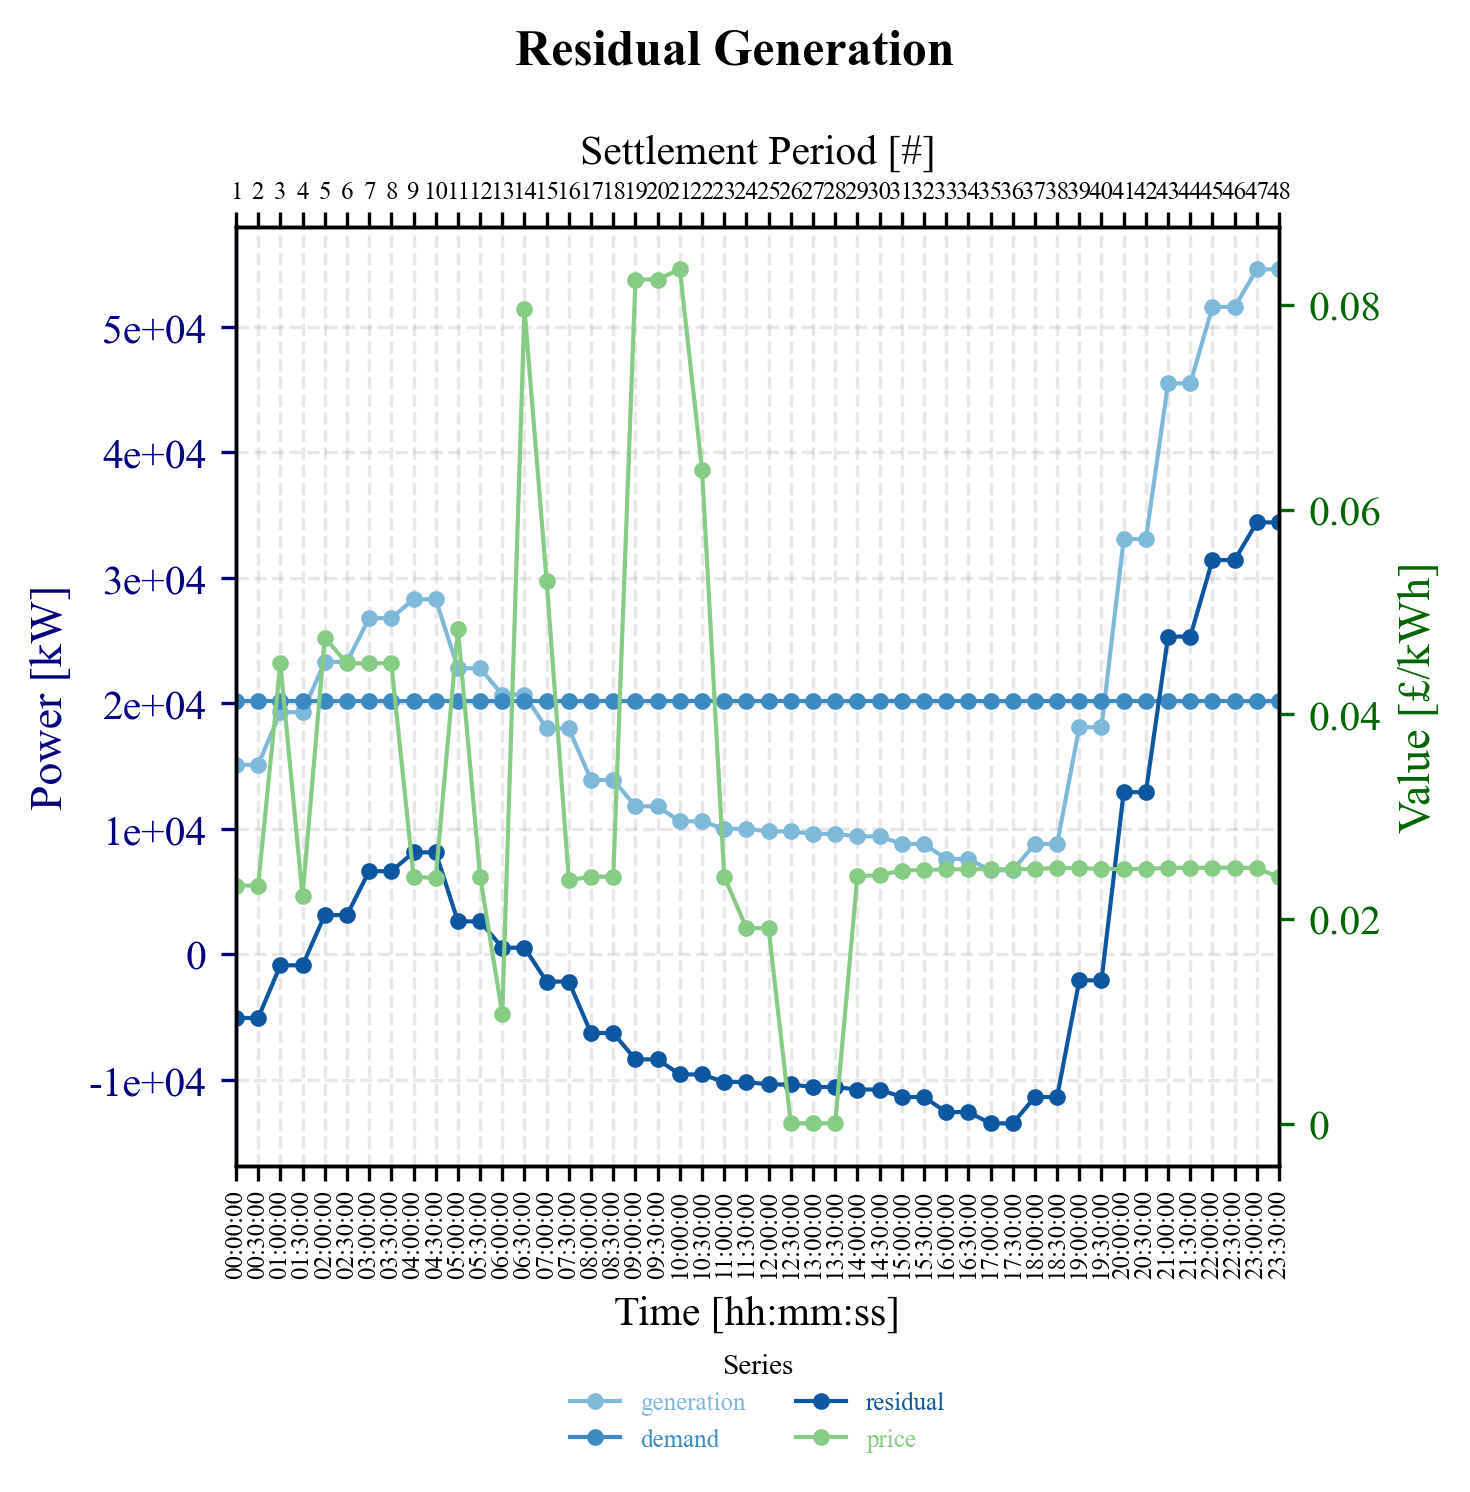

In [108]:
Figure_title = 'Residual Generation'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['generation', 'demand', 'residual'],
    left_label='Power',
    left_units='[kW]',
    series_right = ['price'],
    right_label = 'Value',
    right_units = '[£/kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

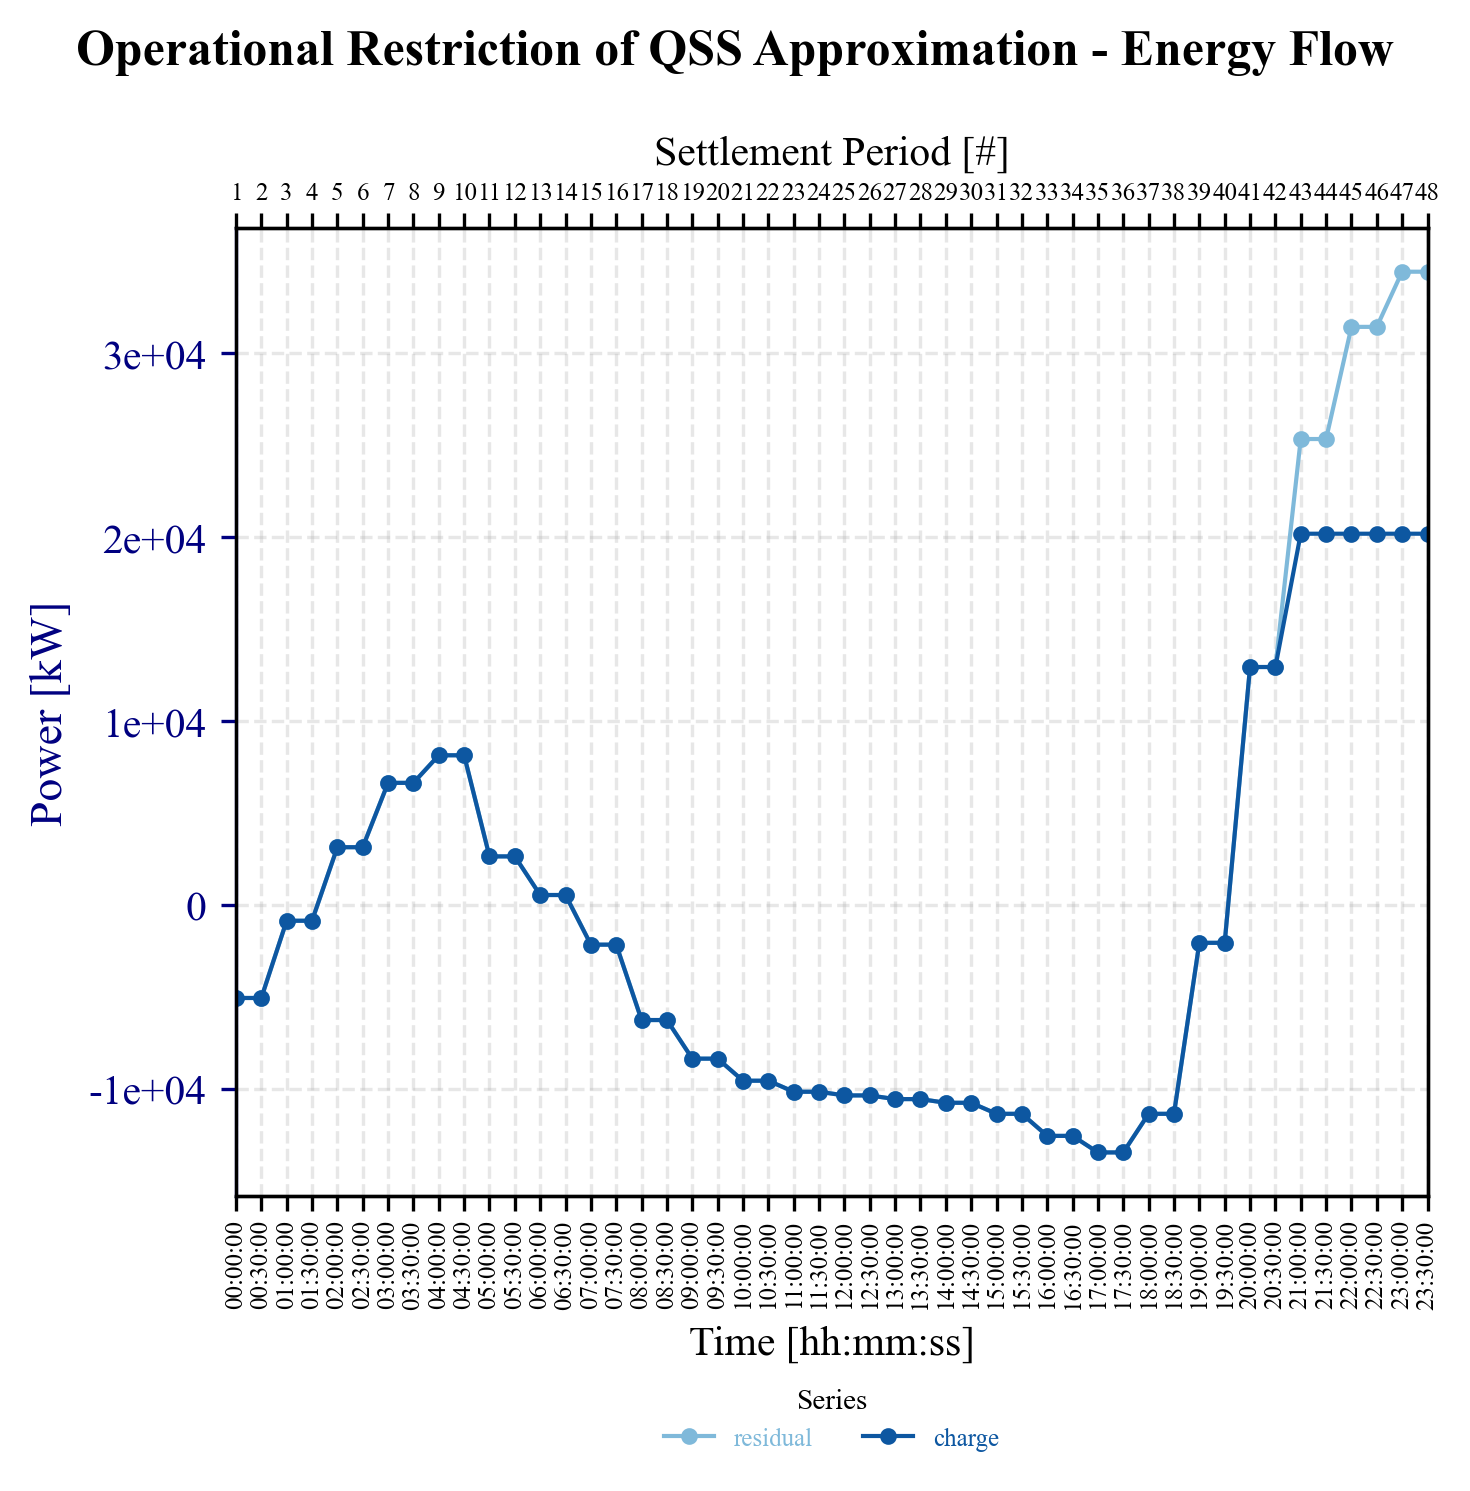

In [109]:
Figure_title = 'Operational Restriction of QSS Approximation - Energy Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual', 'charge'],
    left_label='Power',
    left_units='[kW]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

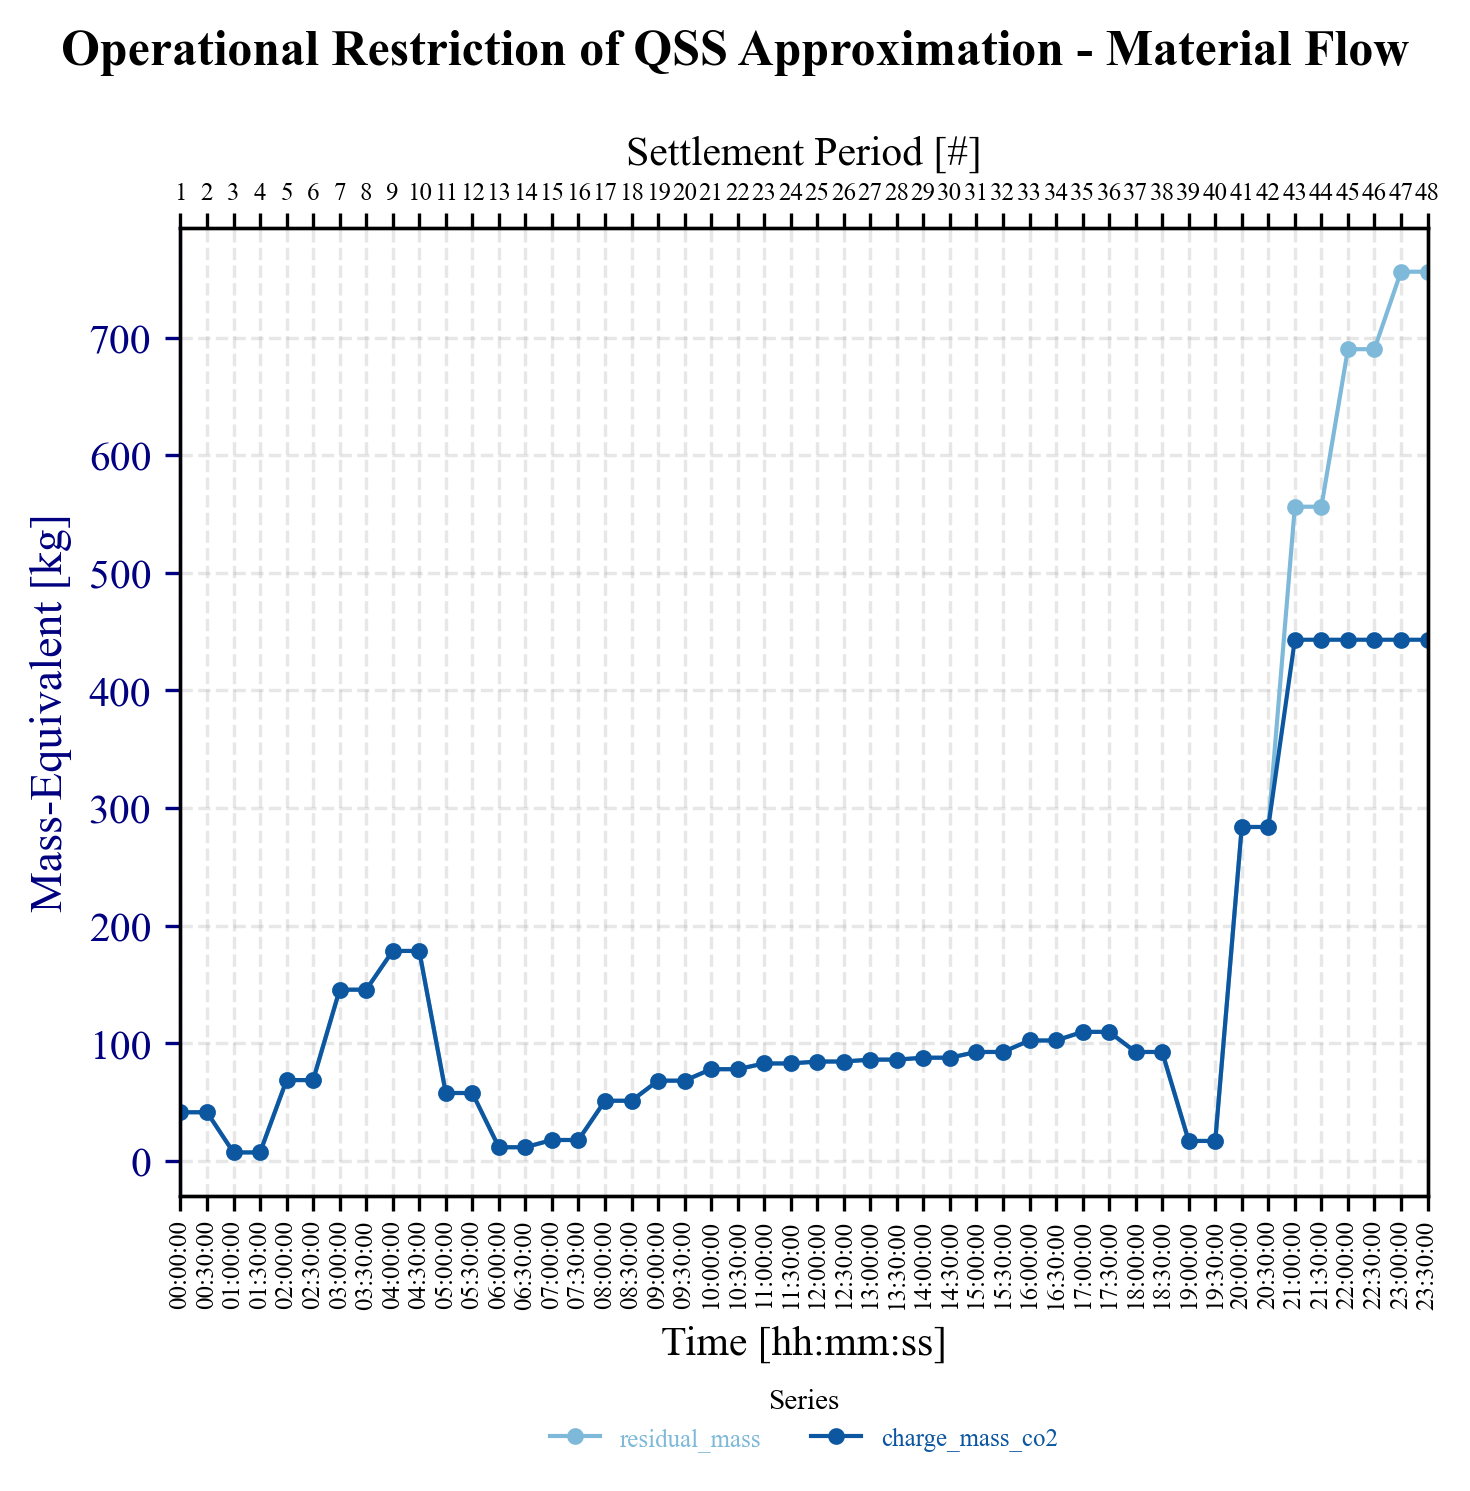

In [110]:
Figure_title = 'Operational Restriction of QSS Approximation - Material Flow'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['residual_mass','charge_mass_co2'],
    left_label='Mass-Equivalent',
    left_units='[kg]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

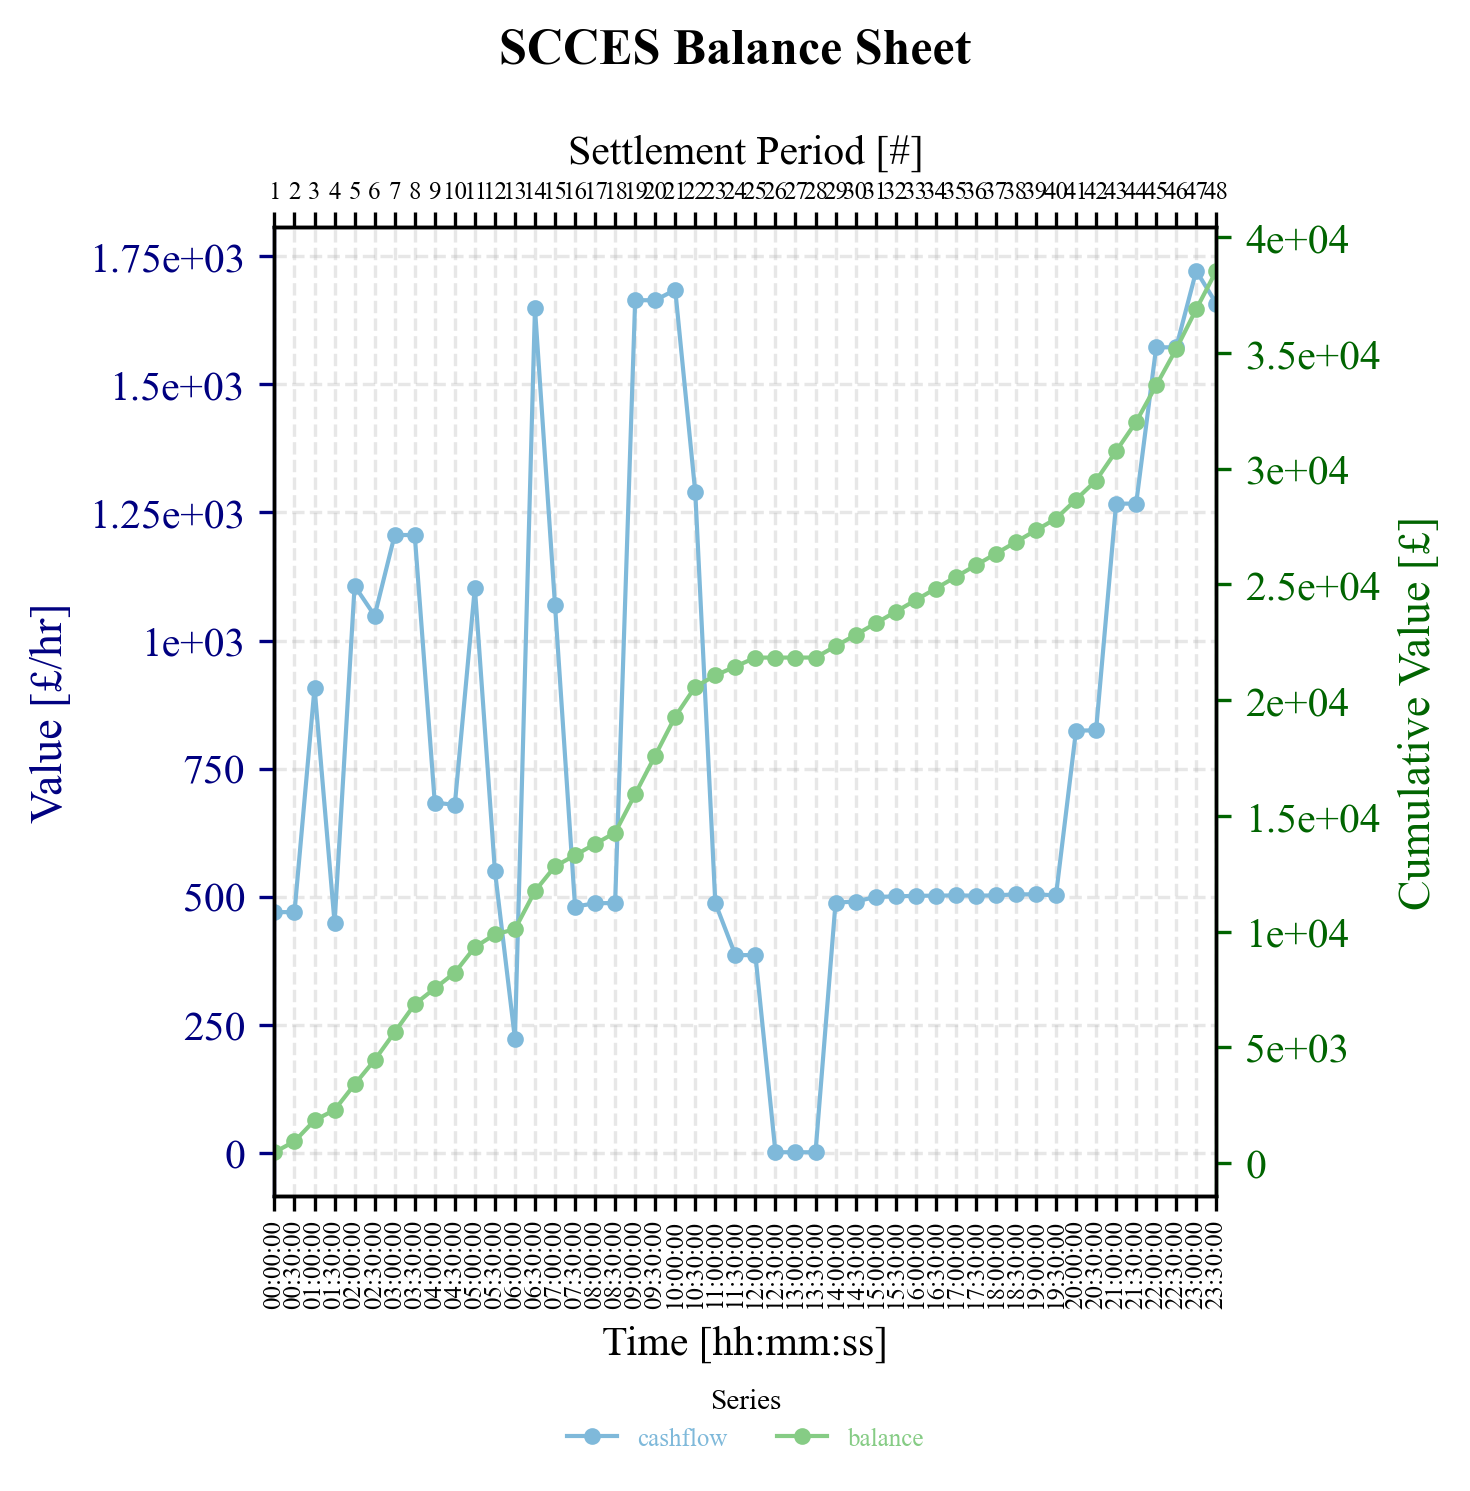

In [111]:
Figure_title = f'{Cycle} Balance Sheet'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['cashflow'],
    left_label='Value',
    left_units='[£/hr]',
    series_right = ['balance'],
    right_label = 'Cumulative Value',
    right_units = '[£]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

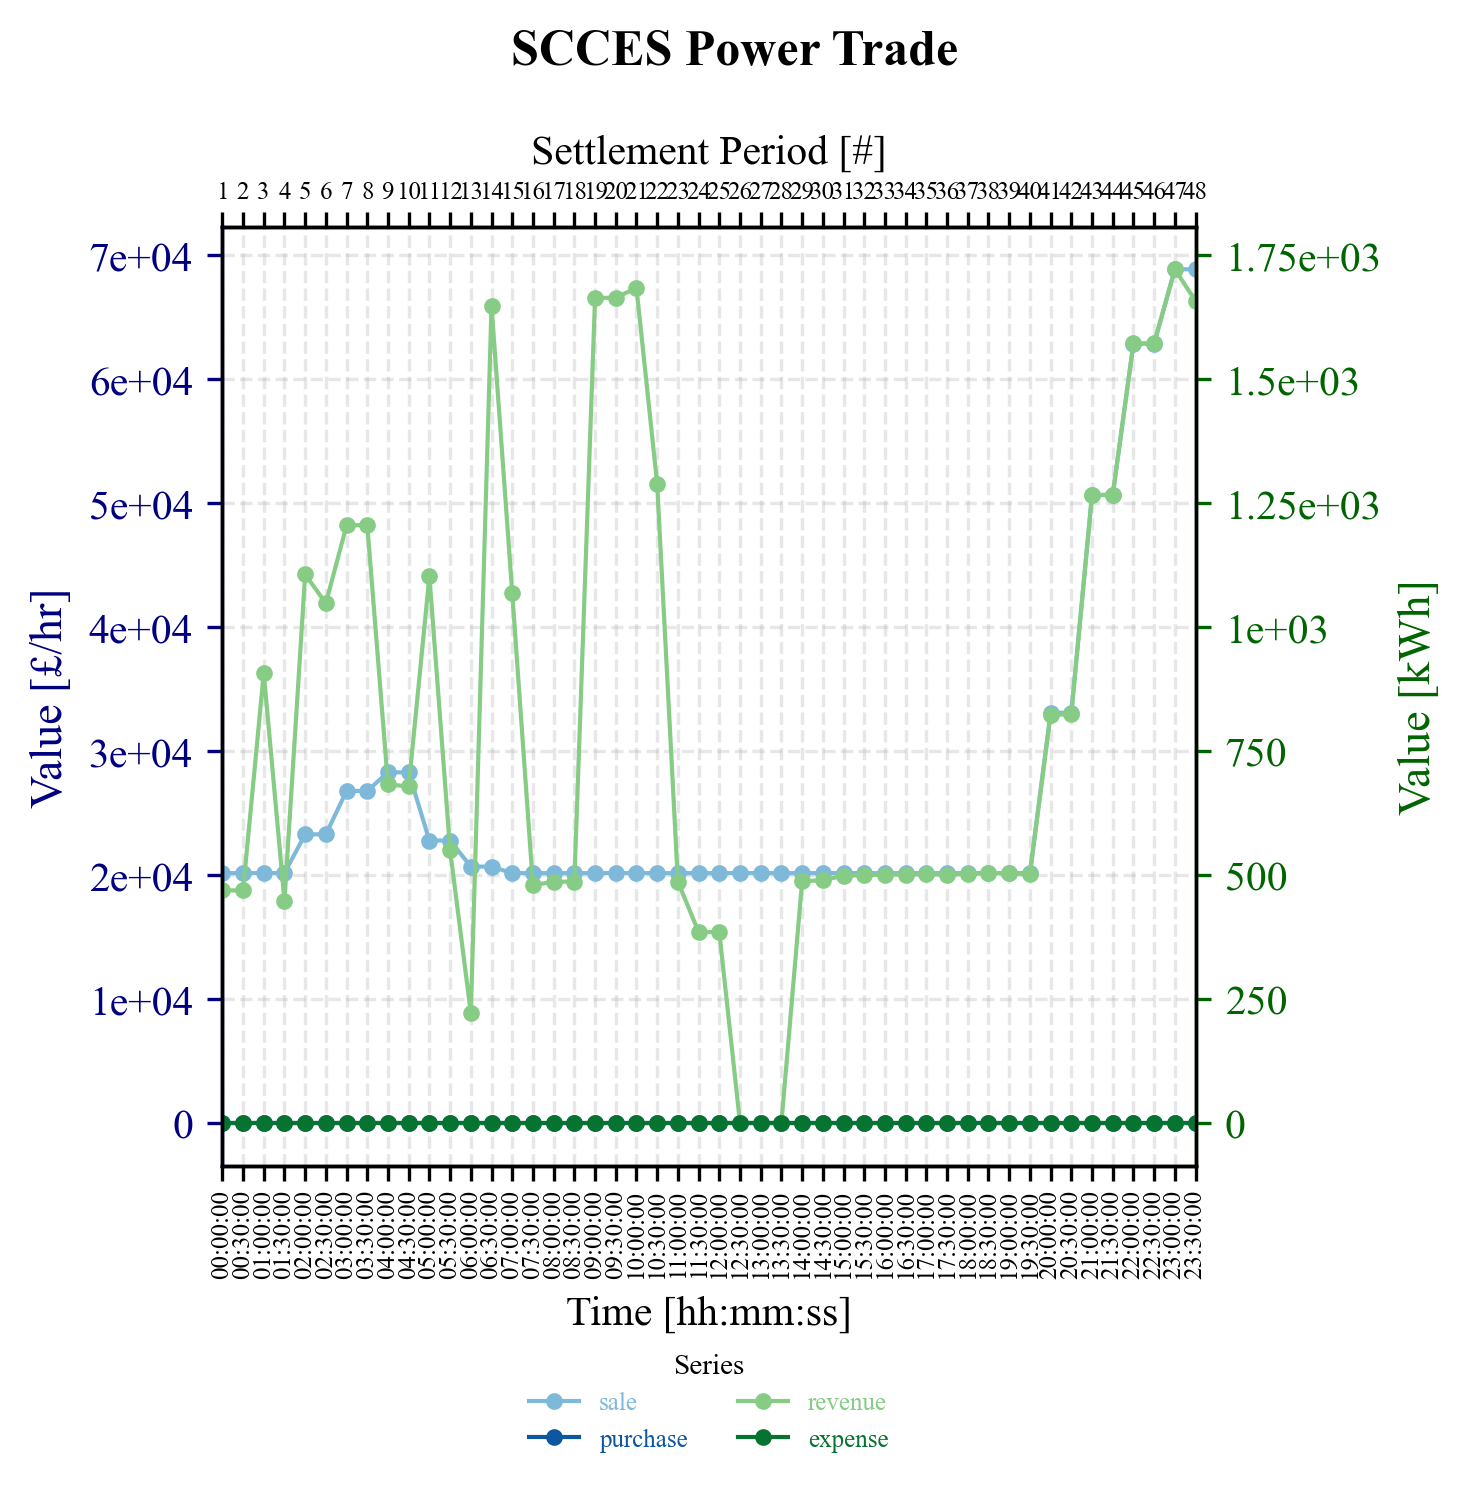

In [112]:
Figure_title = f'{Cycle} Power Trade'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['sale','purchase'],
    left_label='Value',
    left_units='[£/hr]',
    series_right = ['revenue','expense'],
    right_label = 'Value',
    right_units = '[kWh]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

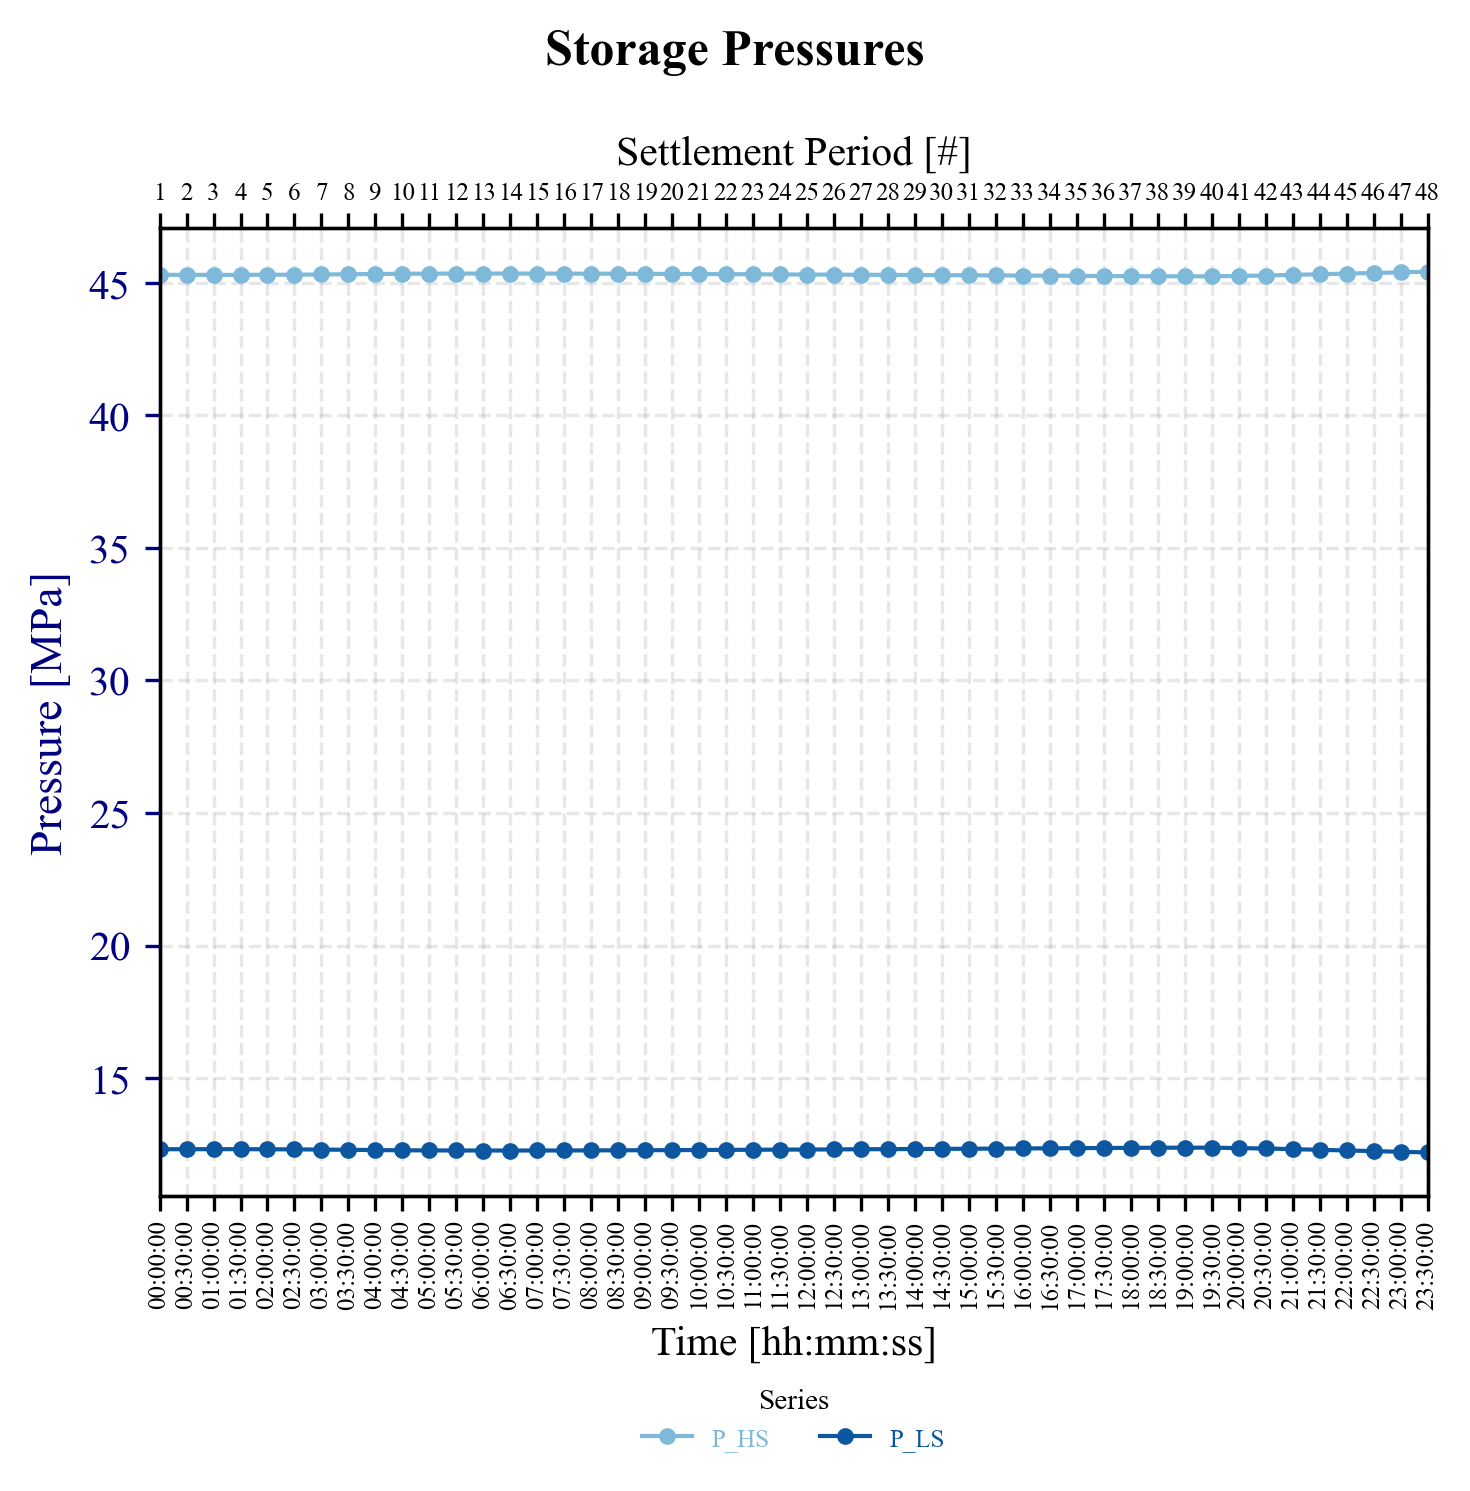

In [113]:
Figure_title = 'Storage Pressures'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['P_HS', 'P_LS'],
    left_label= 'Pressure',
    left_units='[MPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

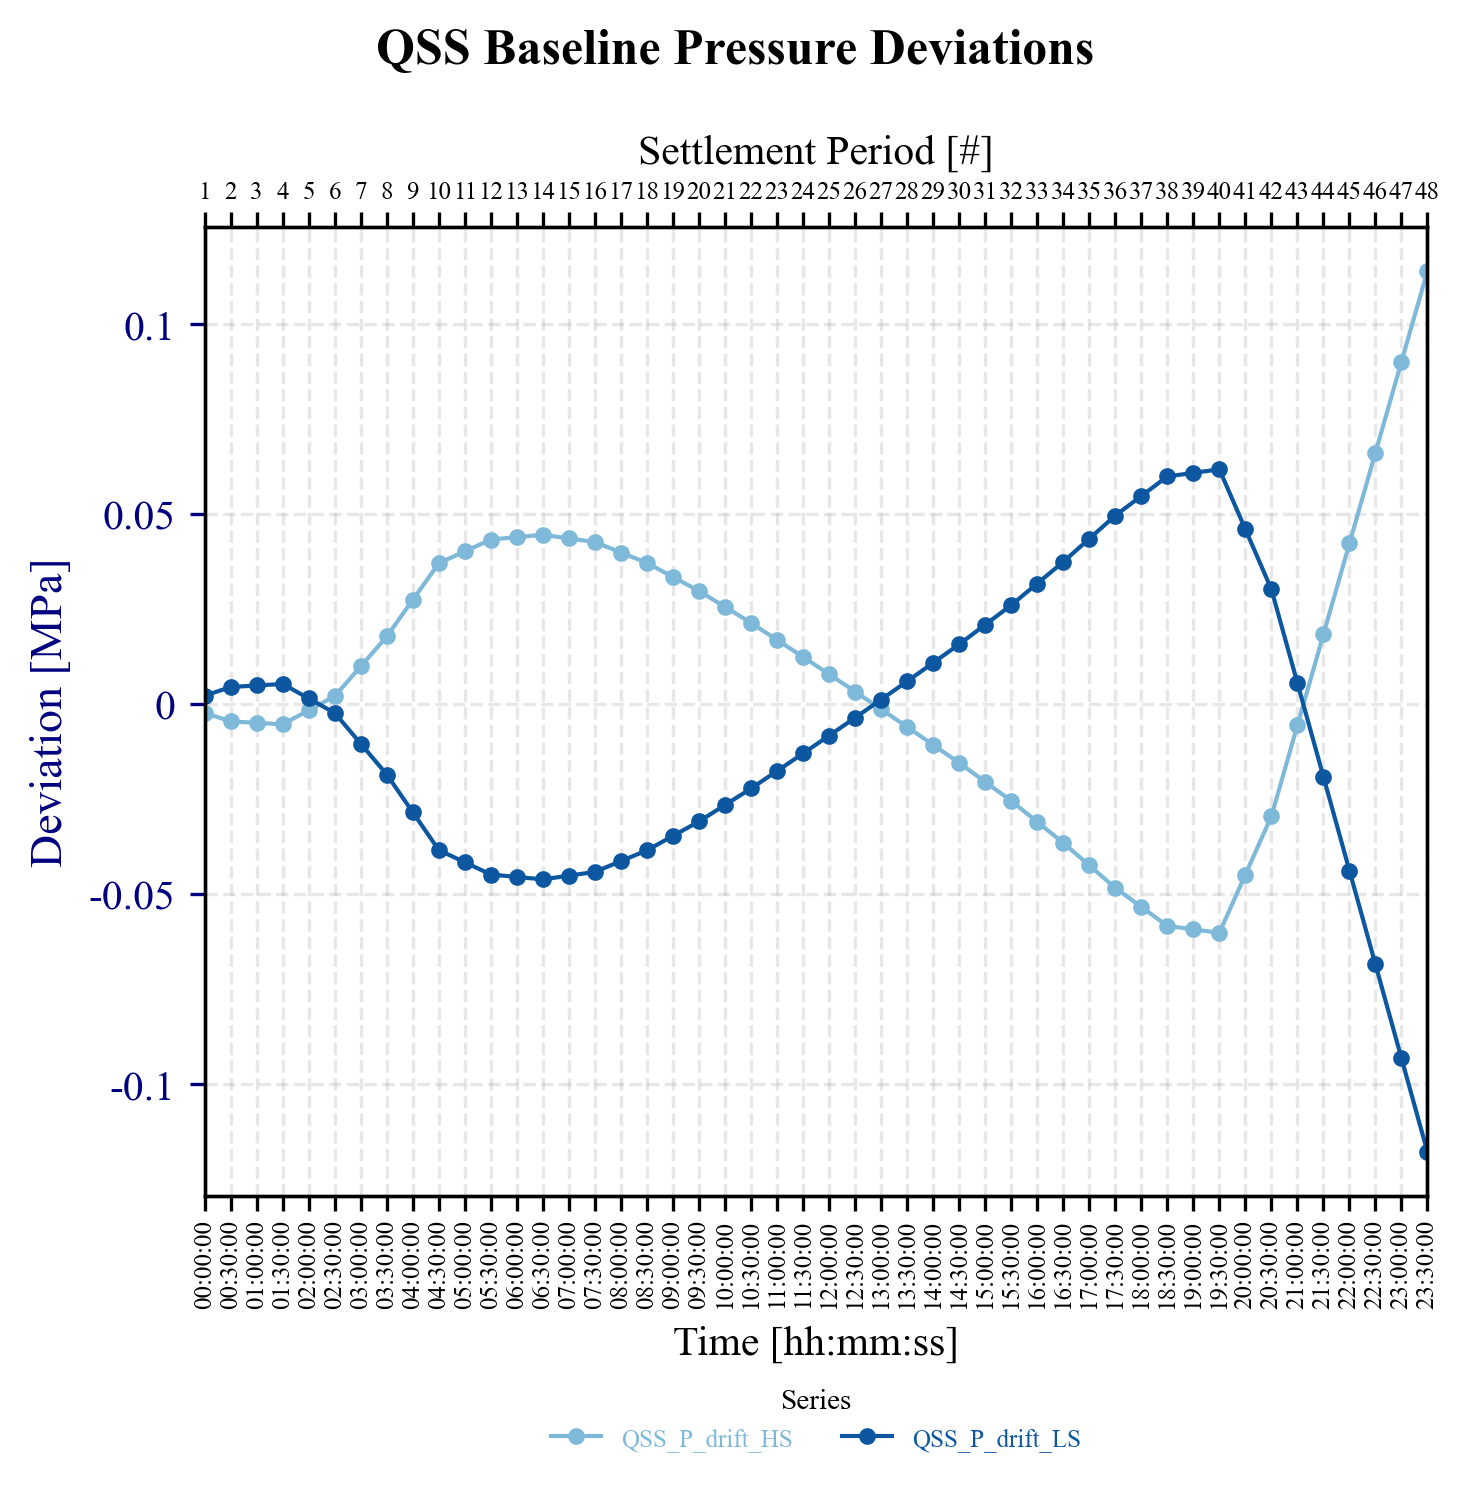

In [114]:
Figure_title = 'QSS Baseline Pressure Deviations'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['QSS_P_drift_HS','QSS_P_drift_LS'],
    left_label= 'Deviation',
    left_units='[MPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

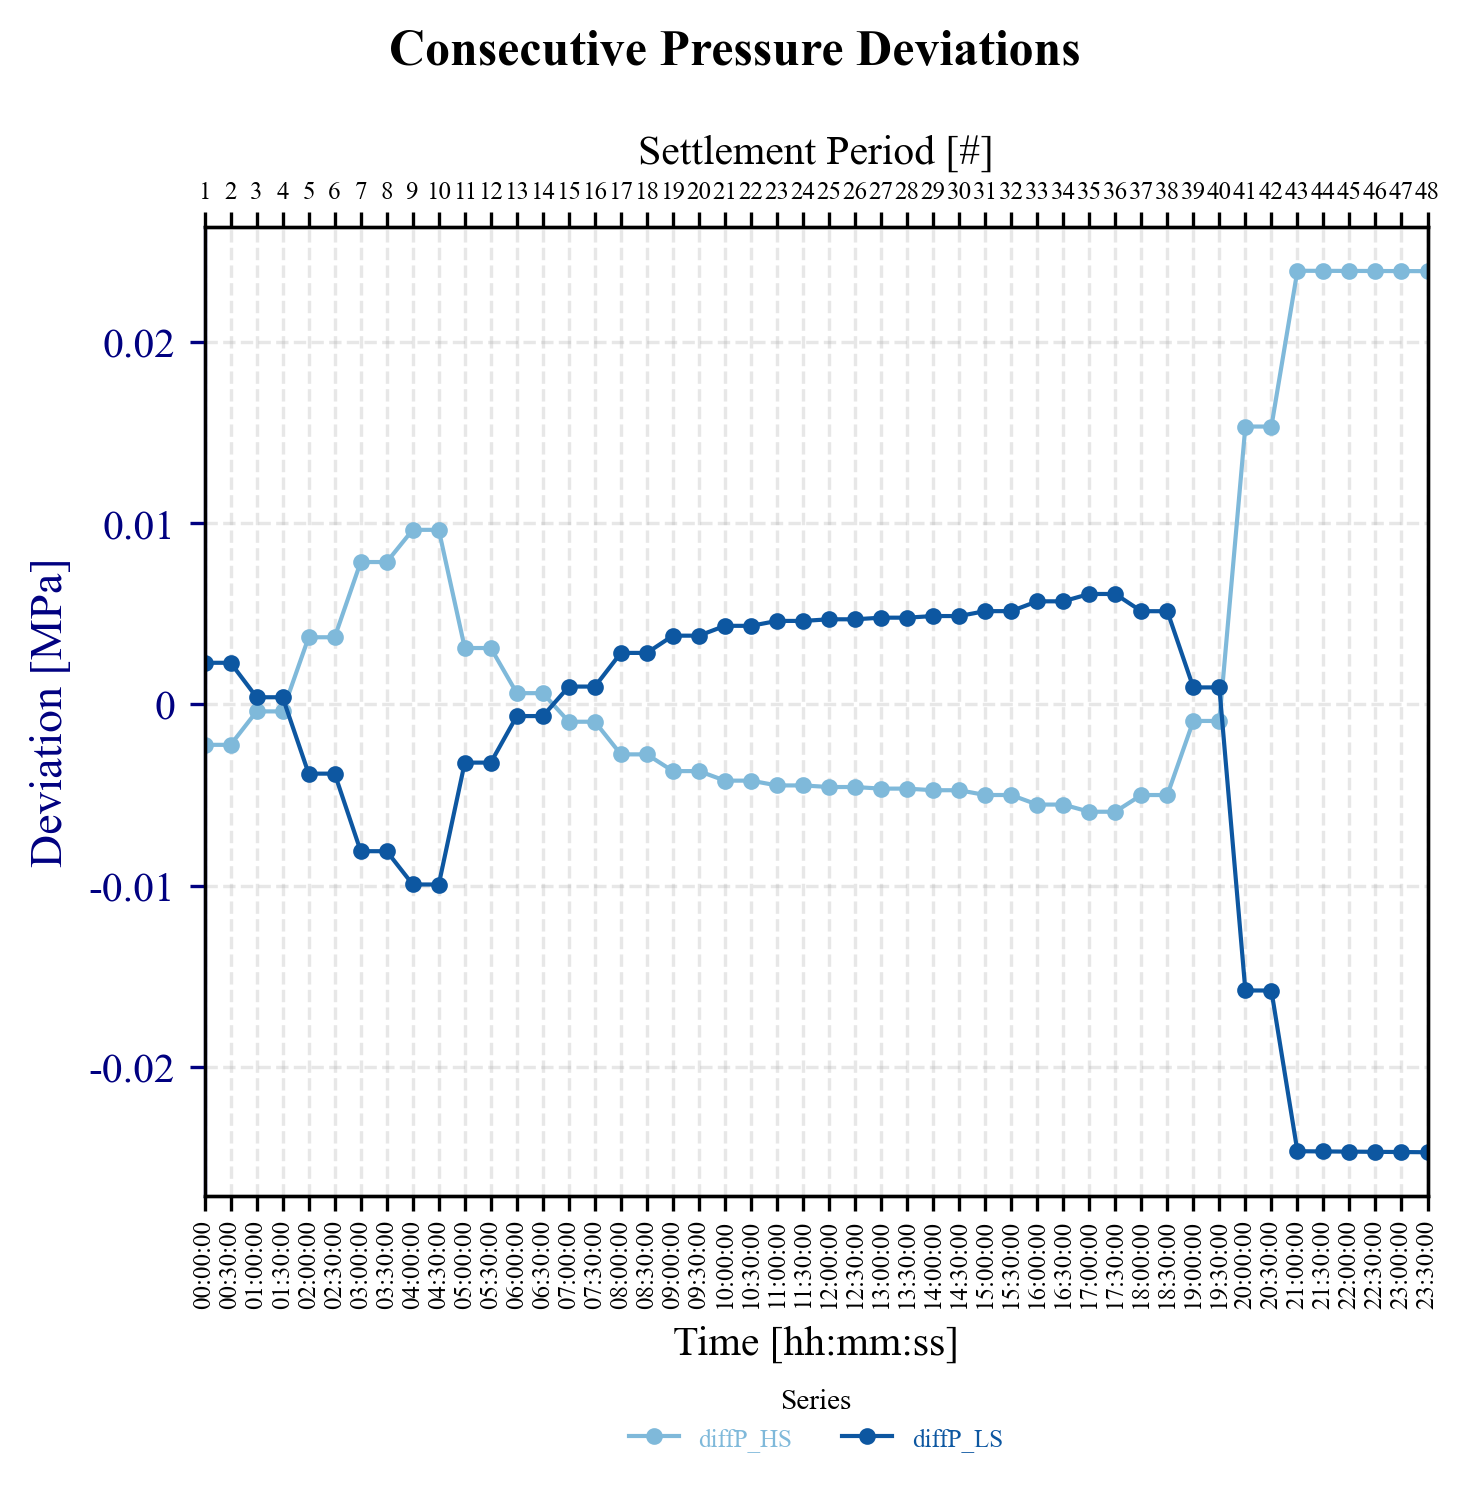

In [115]:
Figure_title = 'Consecutive Pressure Deviations'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['diffP_HS','diffP_LS'],
    left_label= 'Deviation',
    left_units='[MPa]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

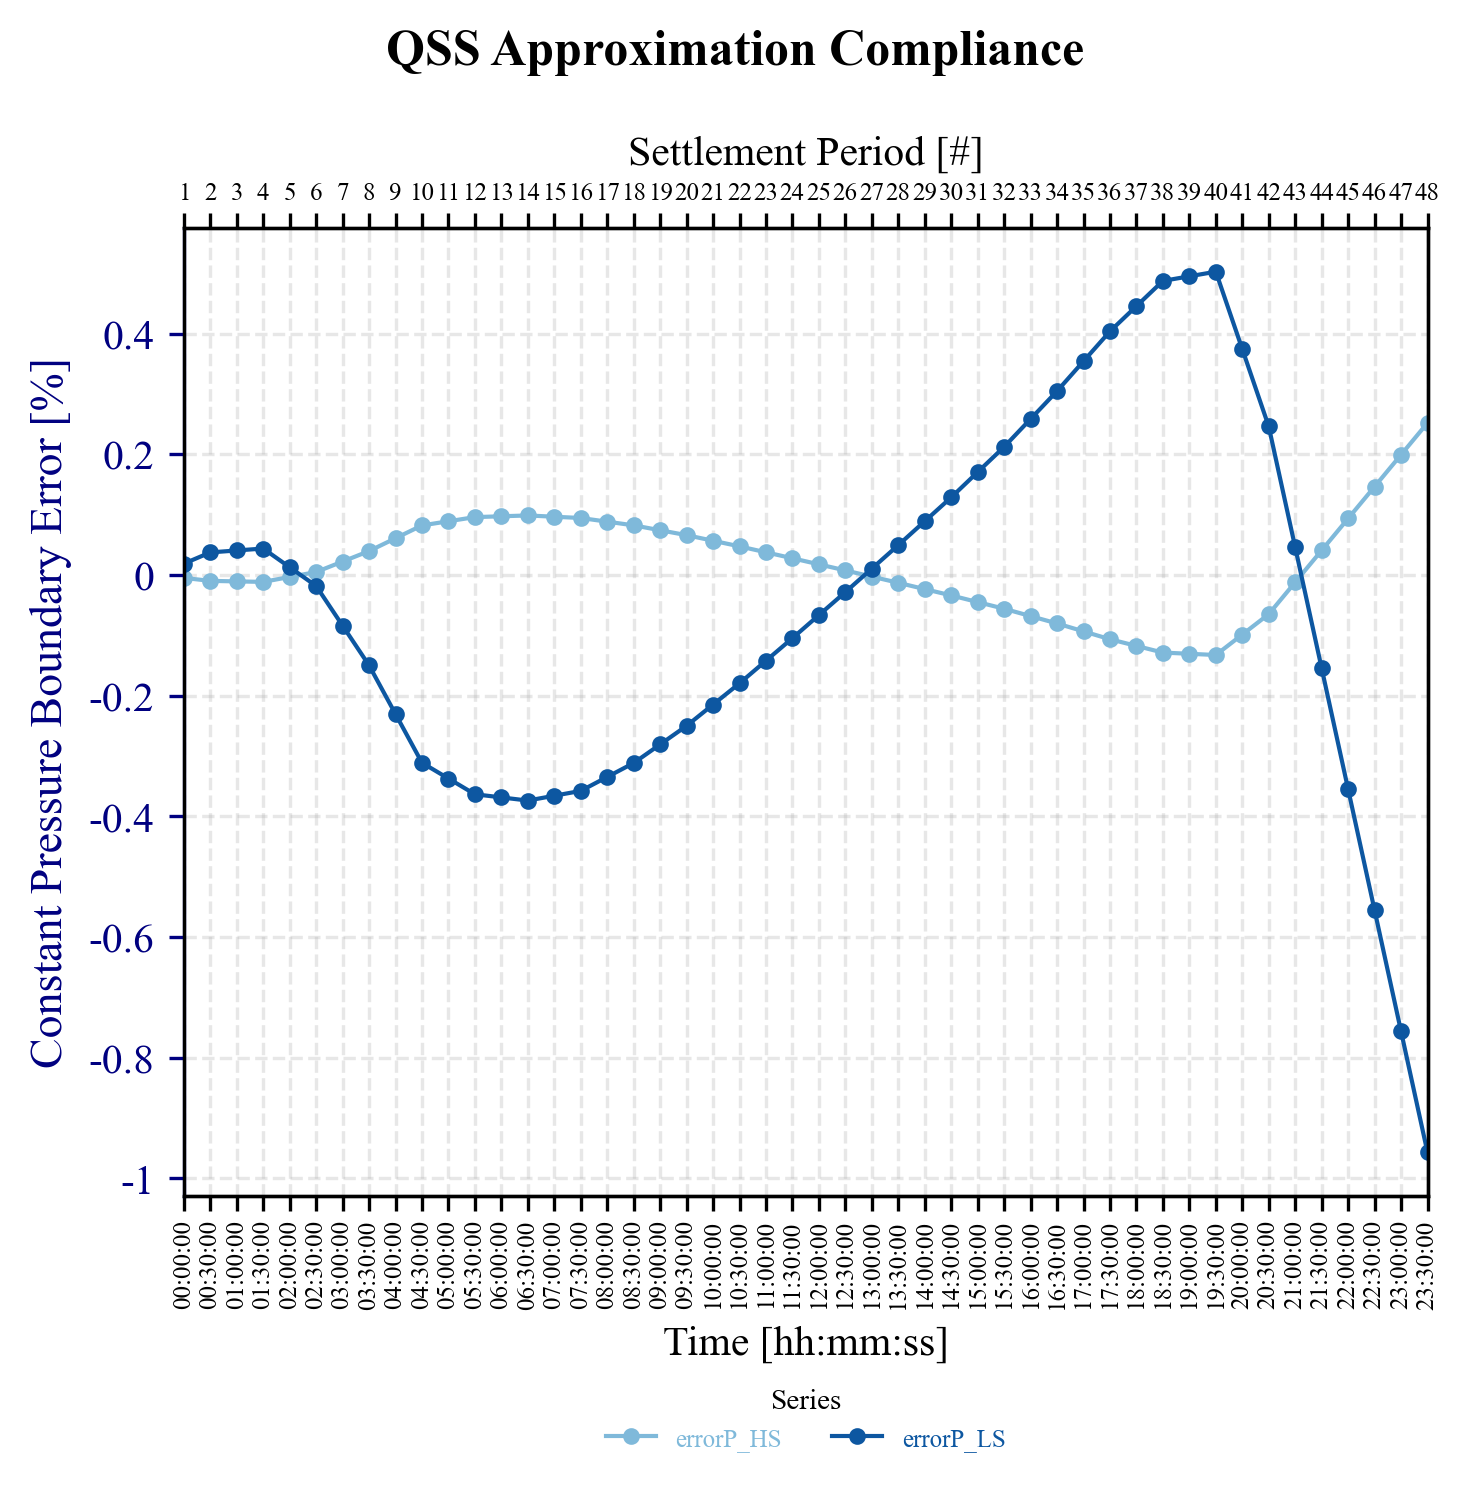

In [116]:
Figure_title = 'QSS Approximation Compliance'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['errorP_HS','errorP_LS'],
    left_label= 'Constant Pressure Boundary Error',
    left_units='[%]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

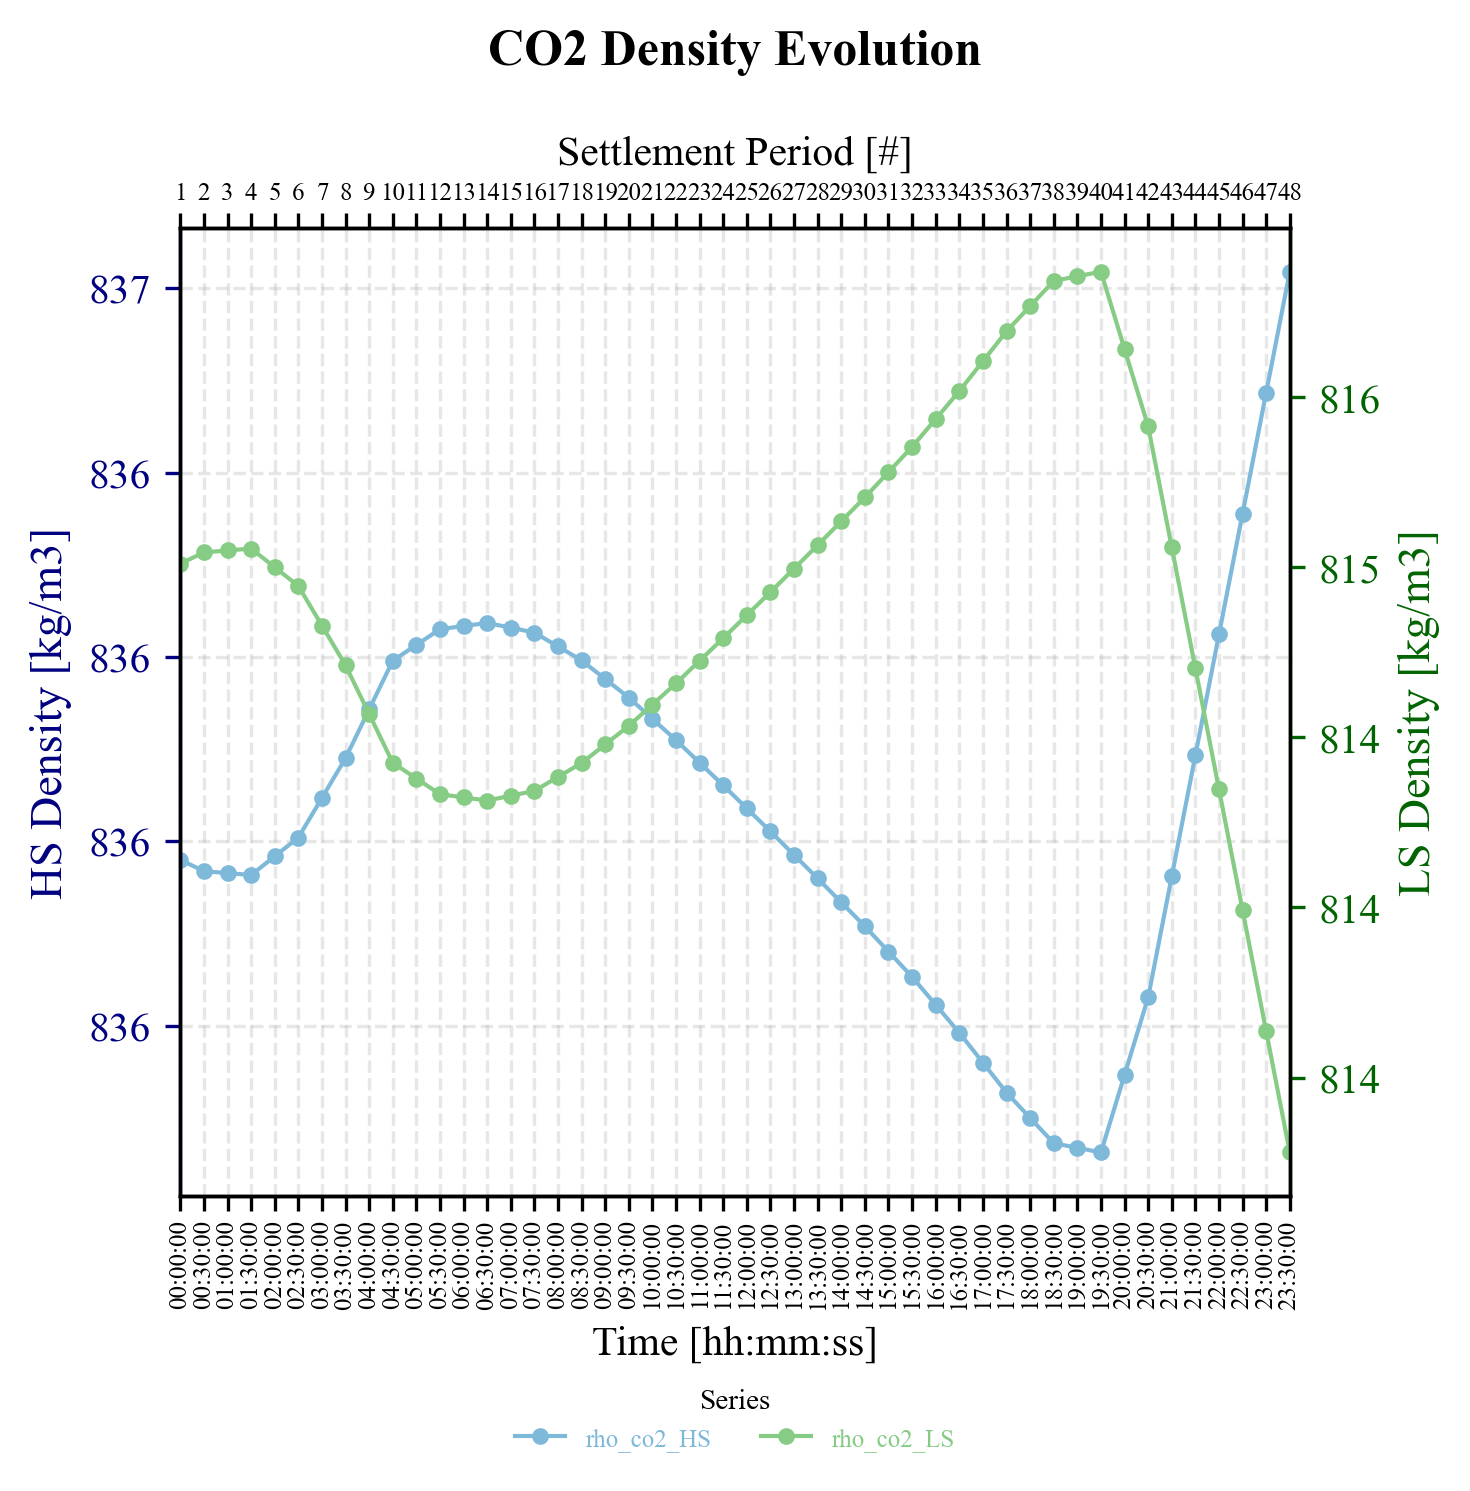

In [117]:
Figure_title = f'{Working_fluid} Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_co2_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]',
    series_right = ['rho_co2_LS'],
    right_label= 'LS Density',             
    right_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

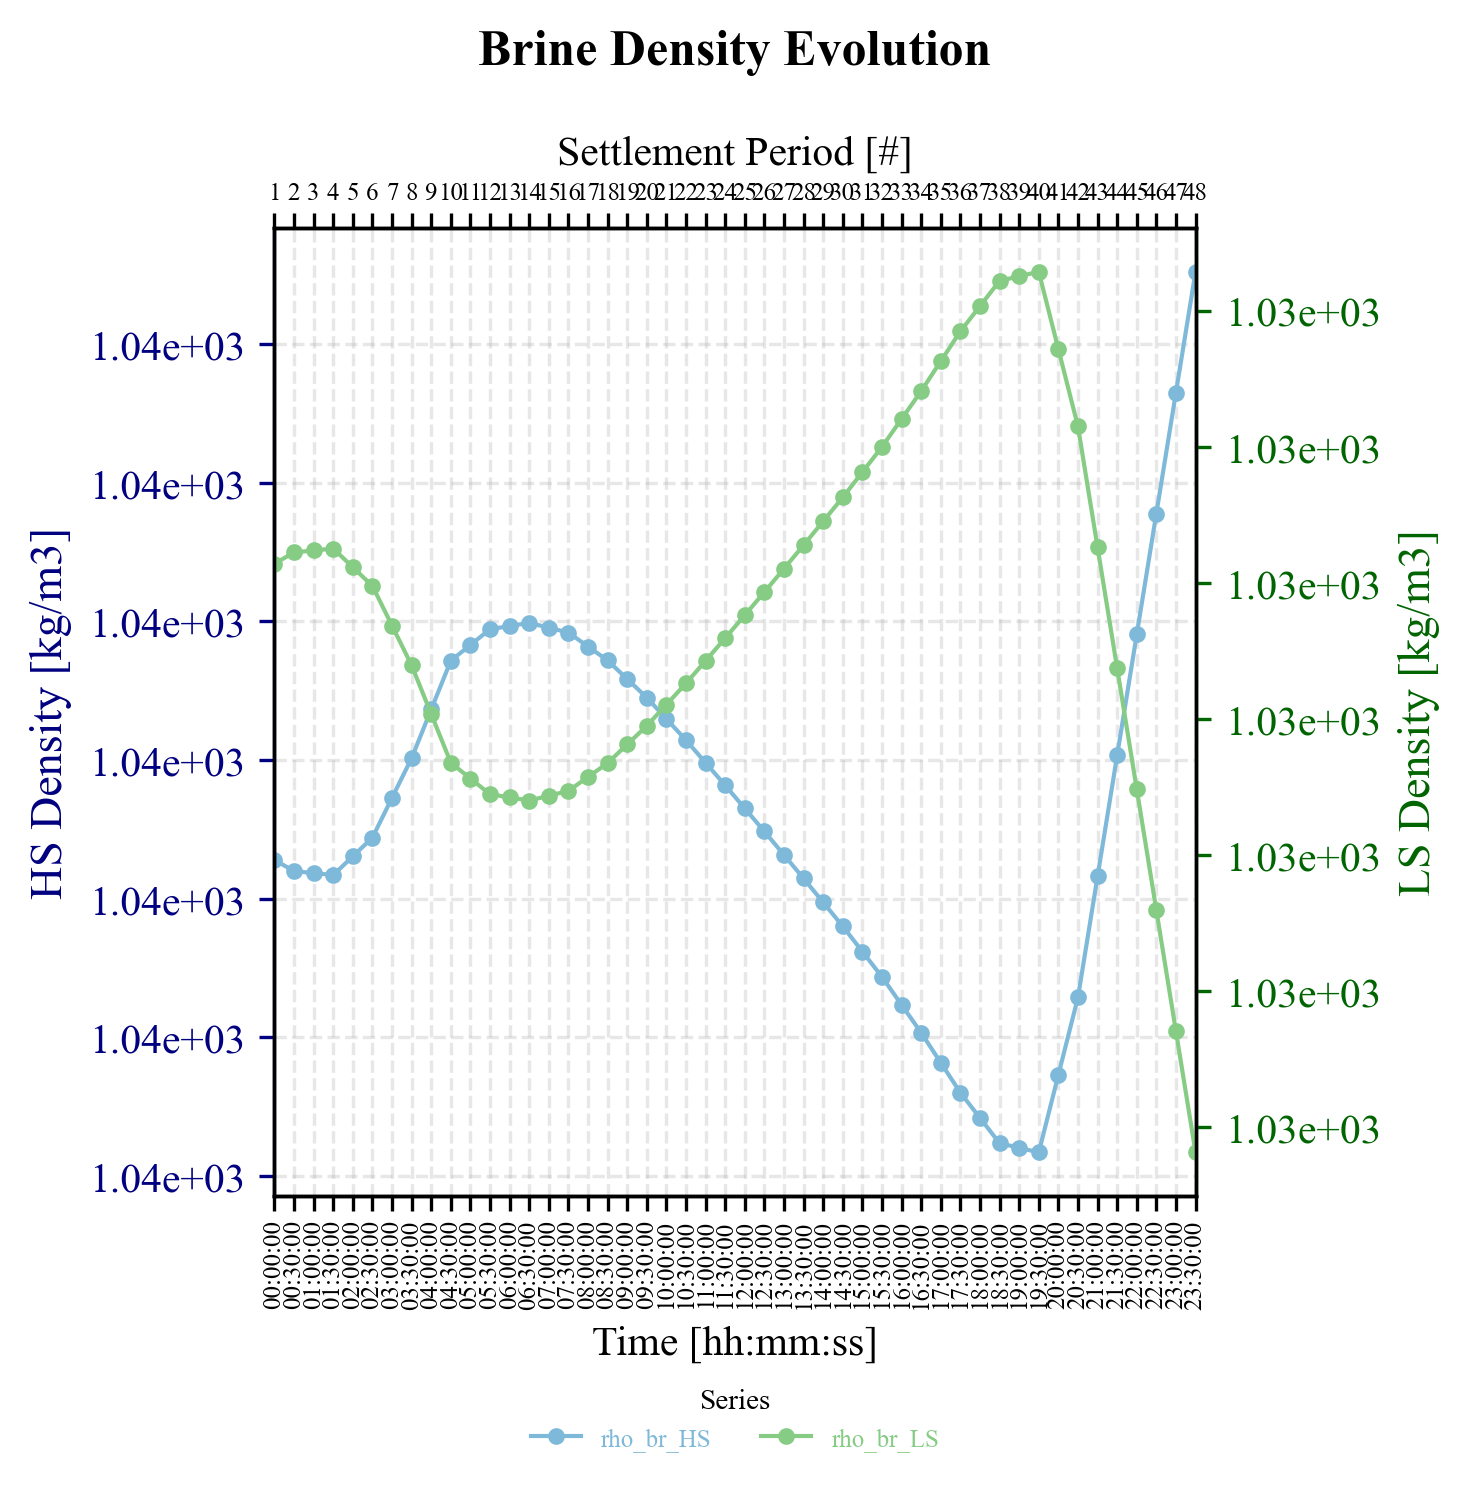

In [118]:
Figure_title = 'Brine Density Evolution'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['rho_br_HS'],
    left_label= 'HS Density',
    left_units='[kg/m3]',
    series_right = ['rho_br_LS'],
    right_label= 'LS Density',             
    right_units='[kg/m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

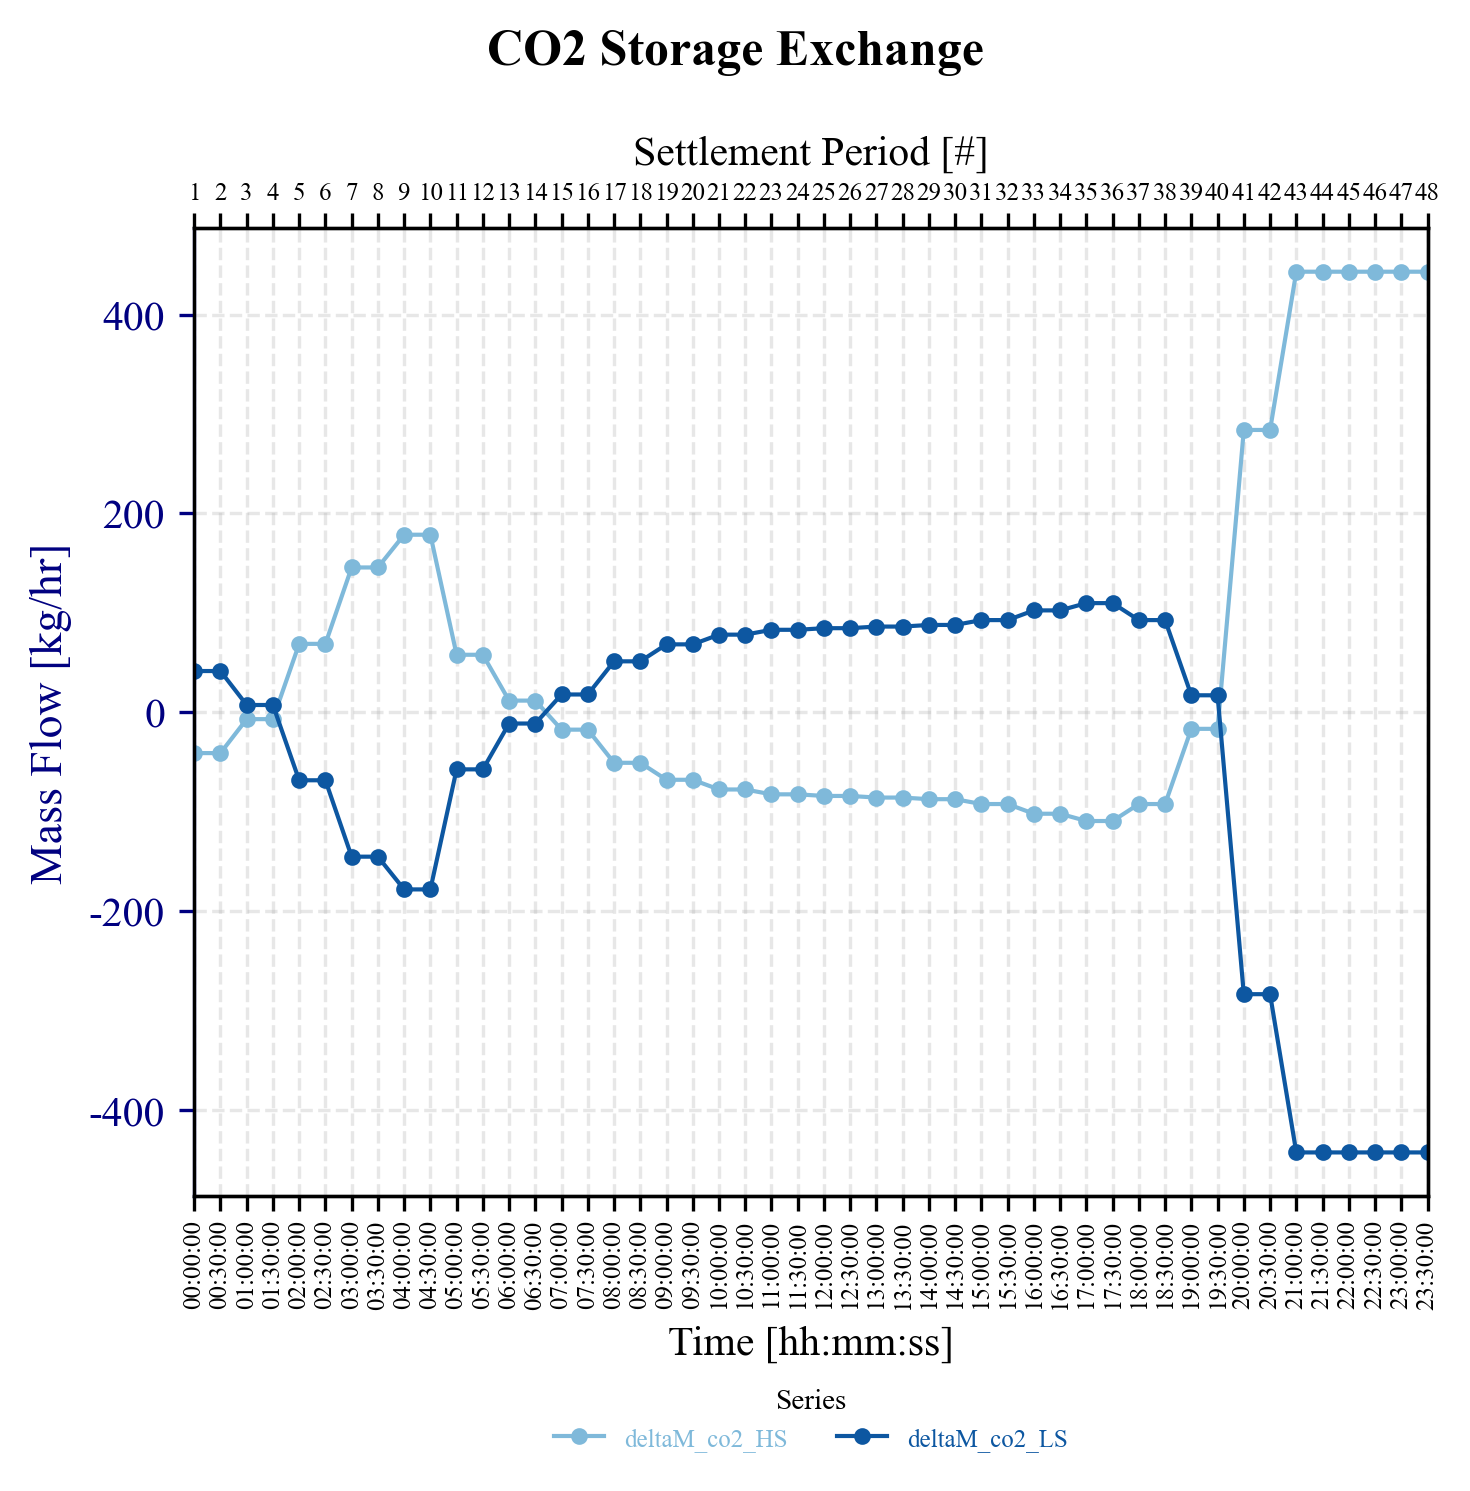

In [119]:
Figure_title = f'{Working_fluid} Storage Exchange'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['deltaM_co2_HS', 'deltaM_co2_LS'],
    left_label= 'Mass Flow',
    left_units='[kg/hr]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

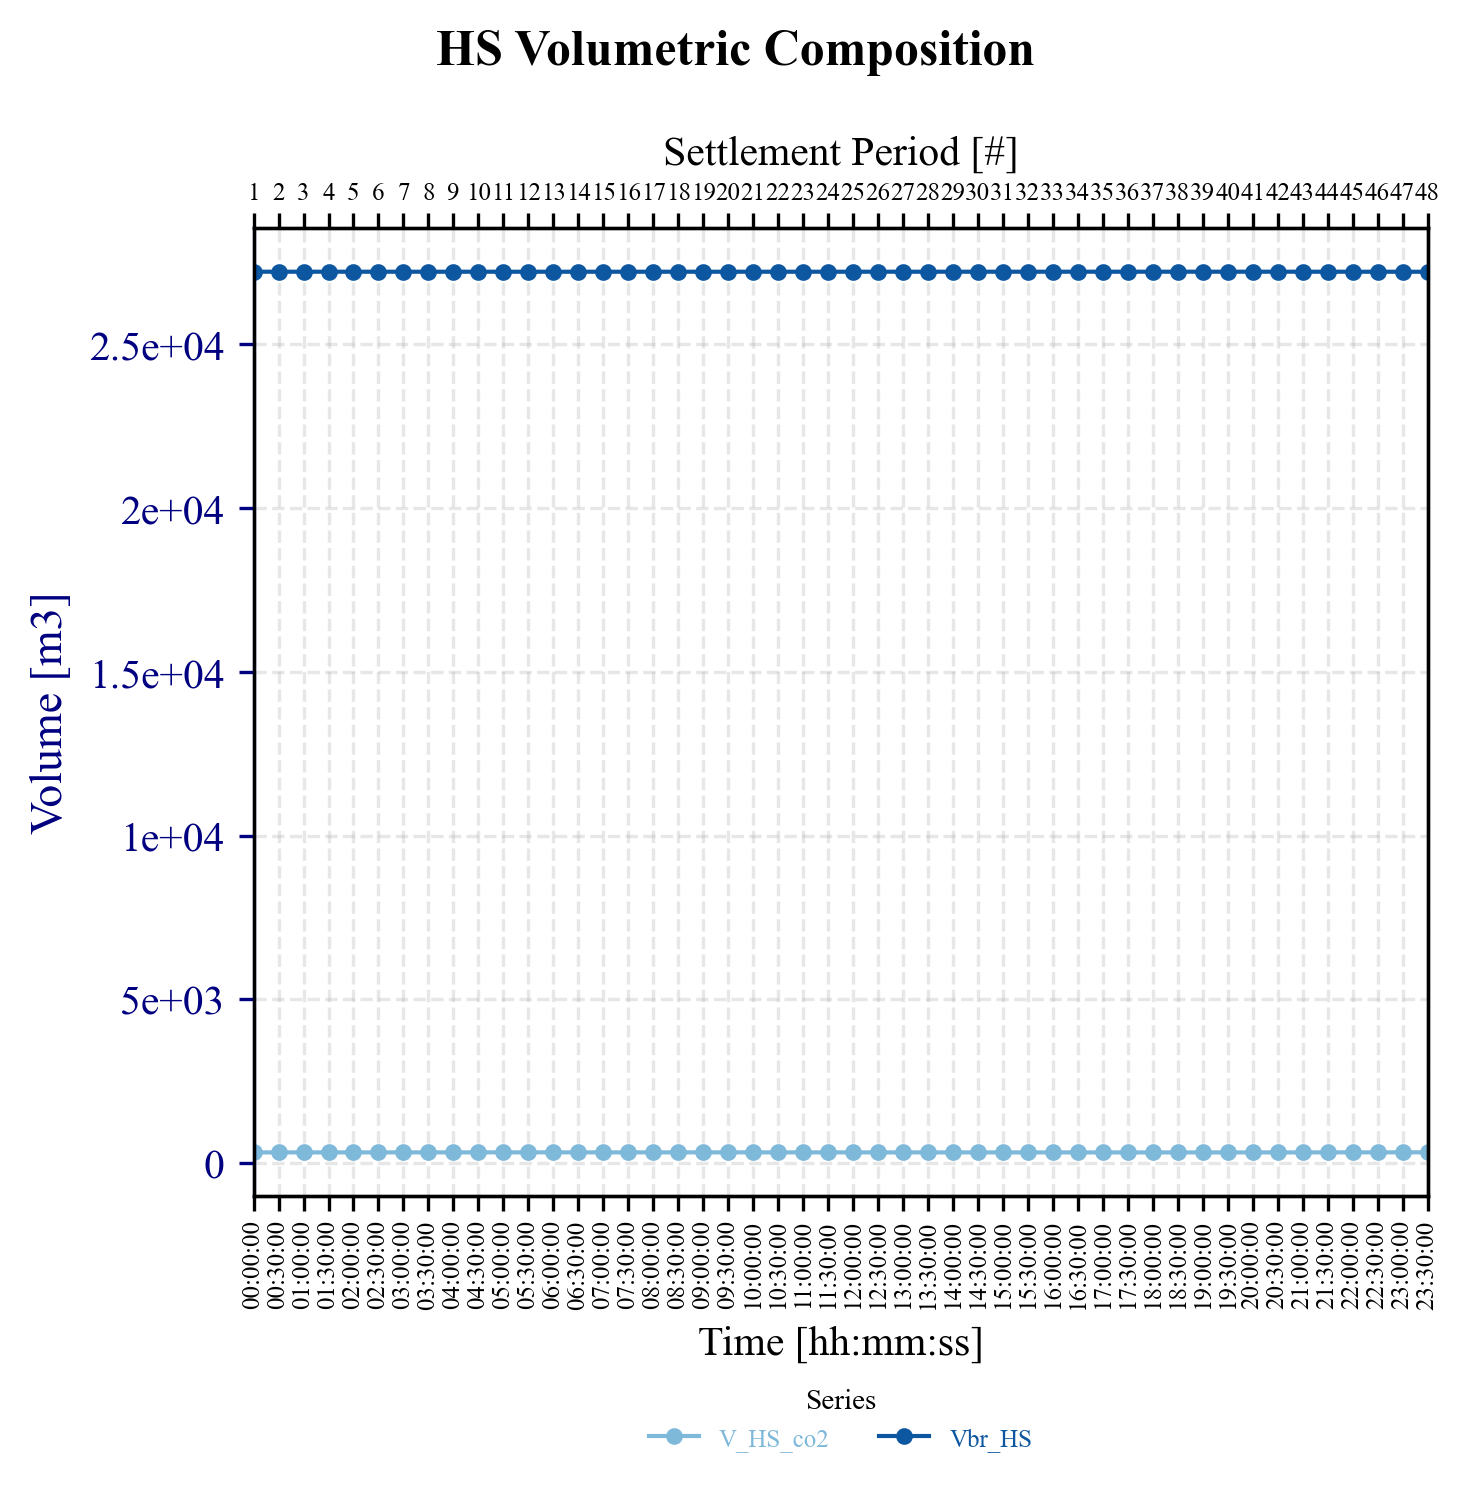

In [120]:
Figure_title = 'HS Volumetric Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['V_HS_co2', 'Vbr_HS'],
    left_label= 'Volume',
    left_units='[m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

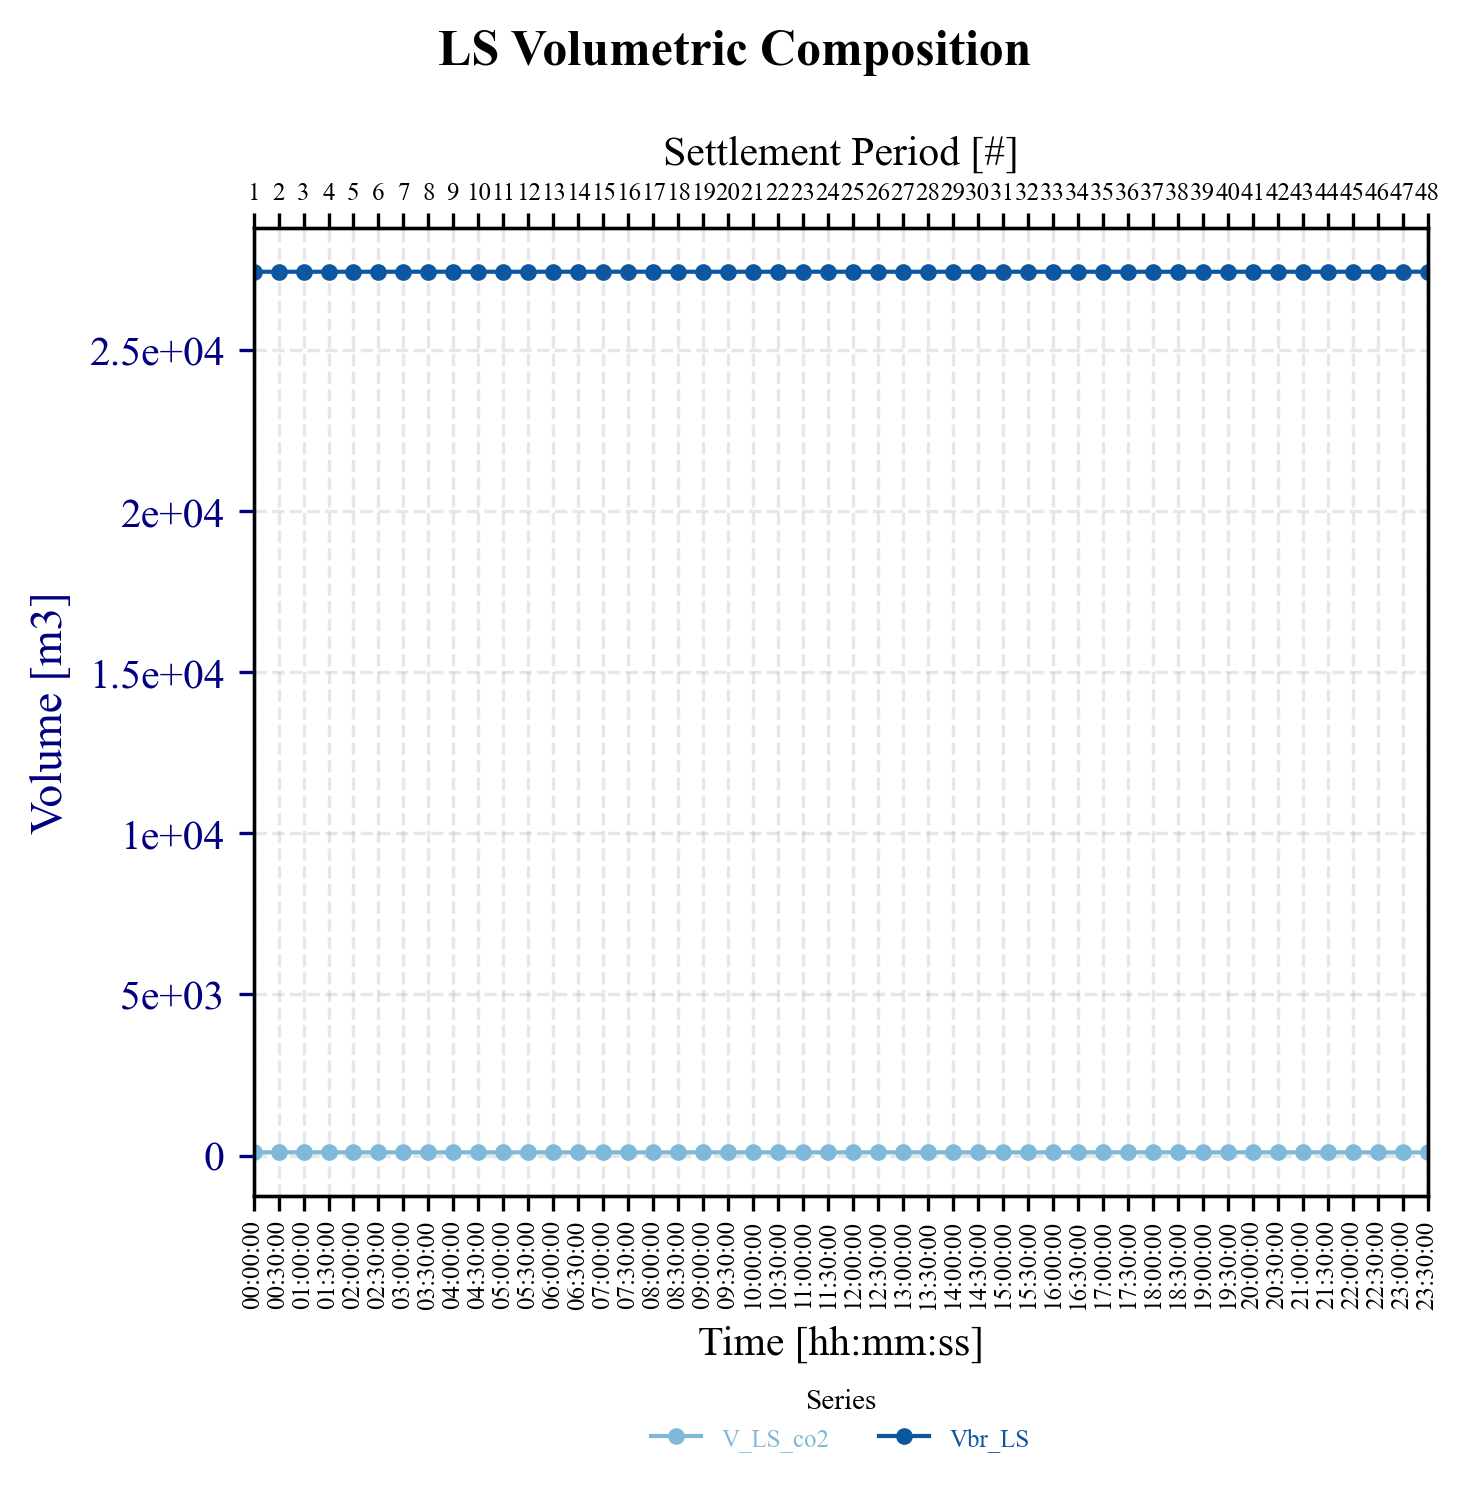

In [121]:
Figure_title = 'LS Volumetric Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['V_LS_co2', 'Vbr_LS'],
    left_label= 'Volume',
    left_units='[m3]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

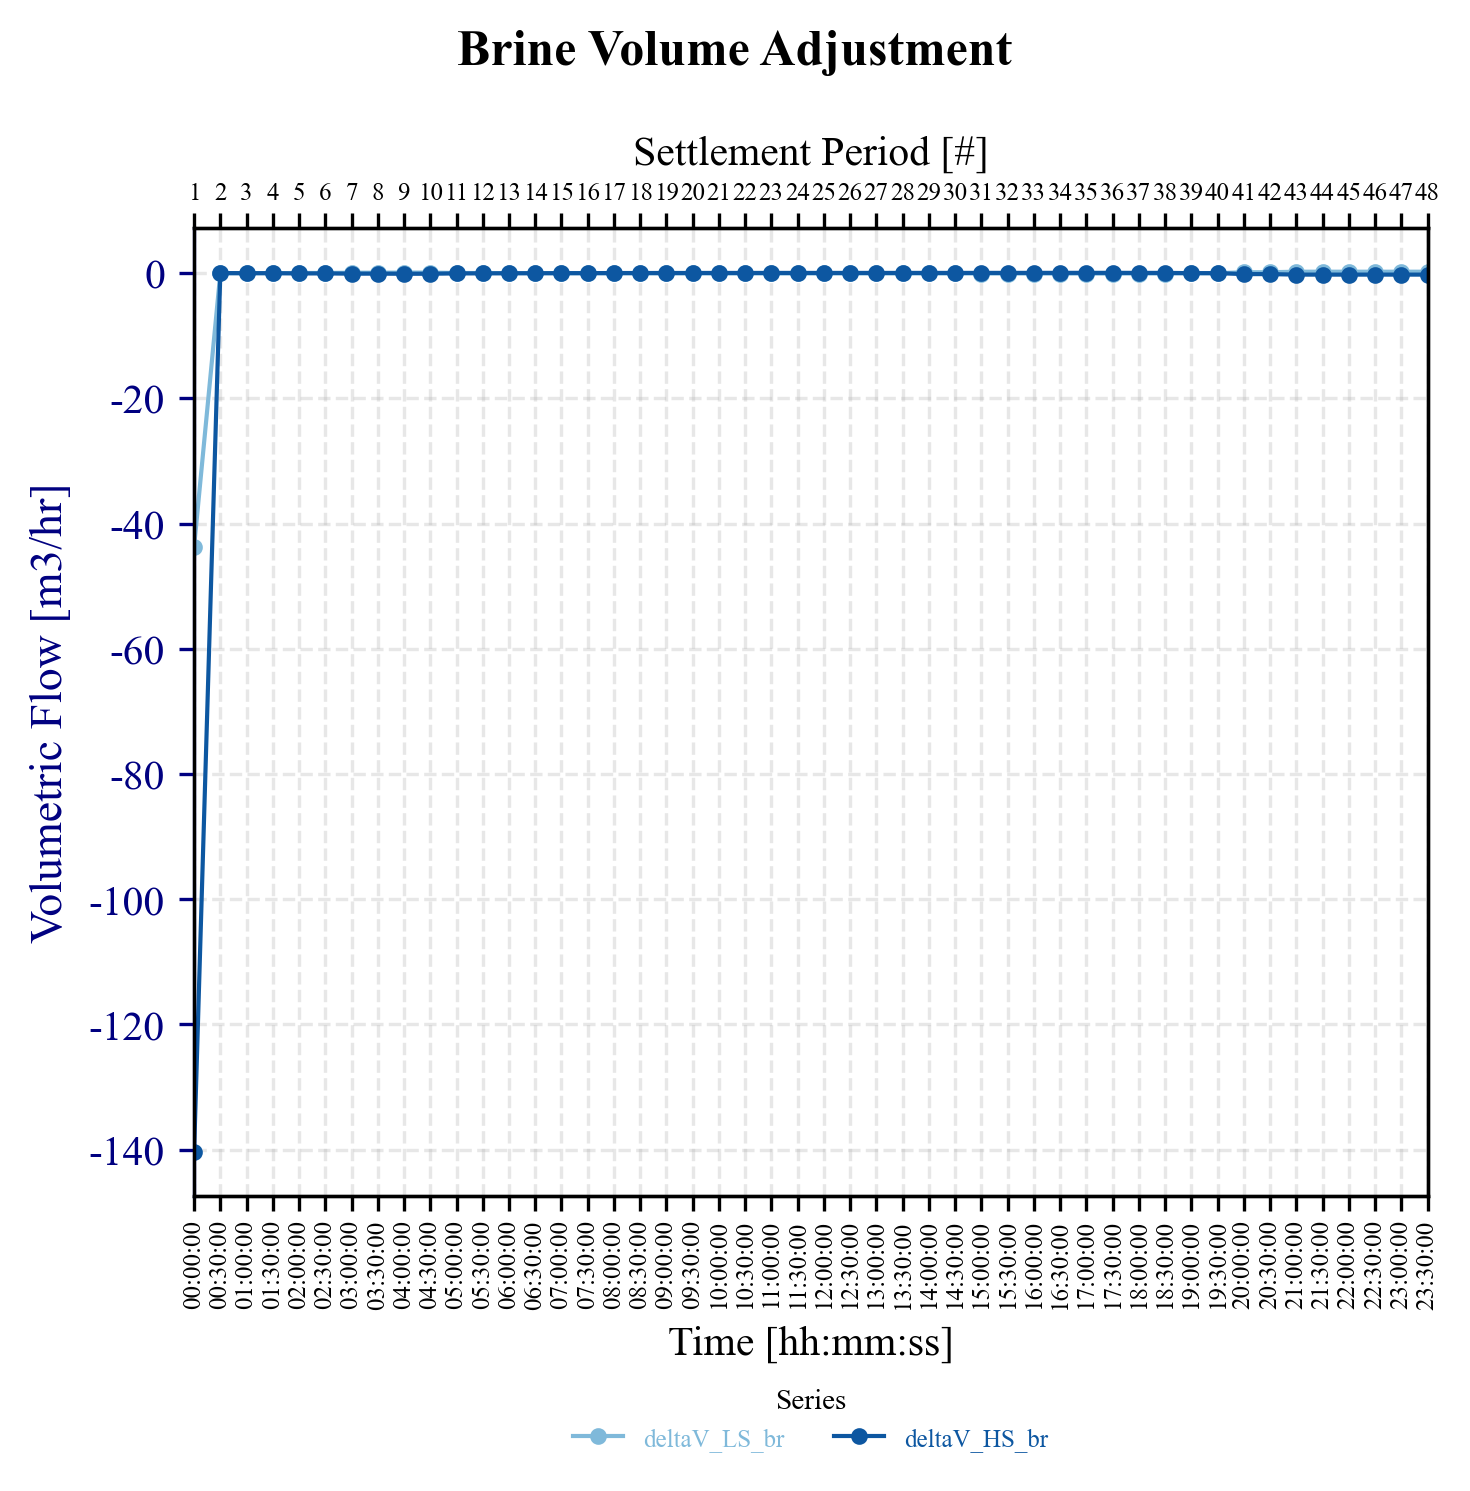

In [122]:
Figure_title = 'Brine Volume Adjustment'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['deltaV_LS_br', 'deltaV_HS_br'],
    left_label= 'Volumetric Flow',
    left_units='[m3/hr]')

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

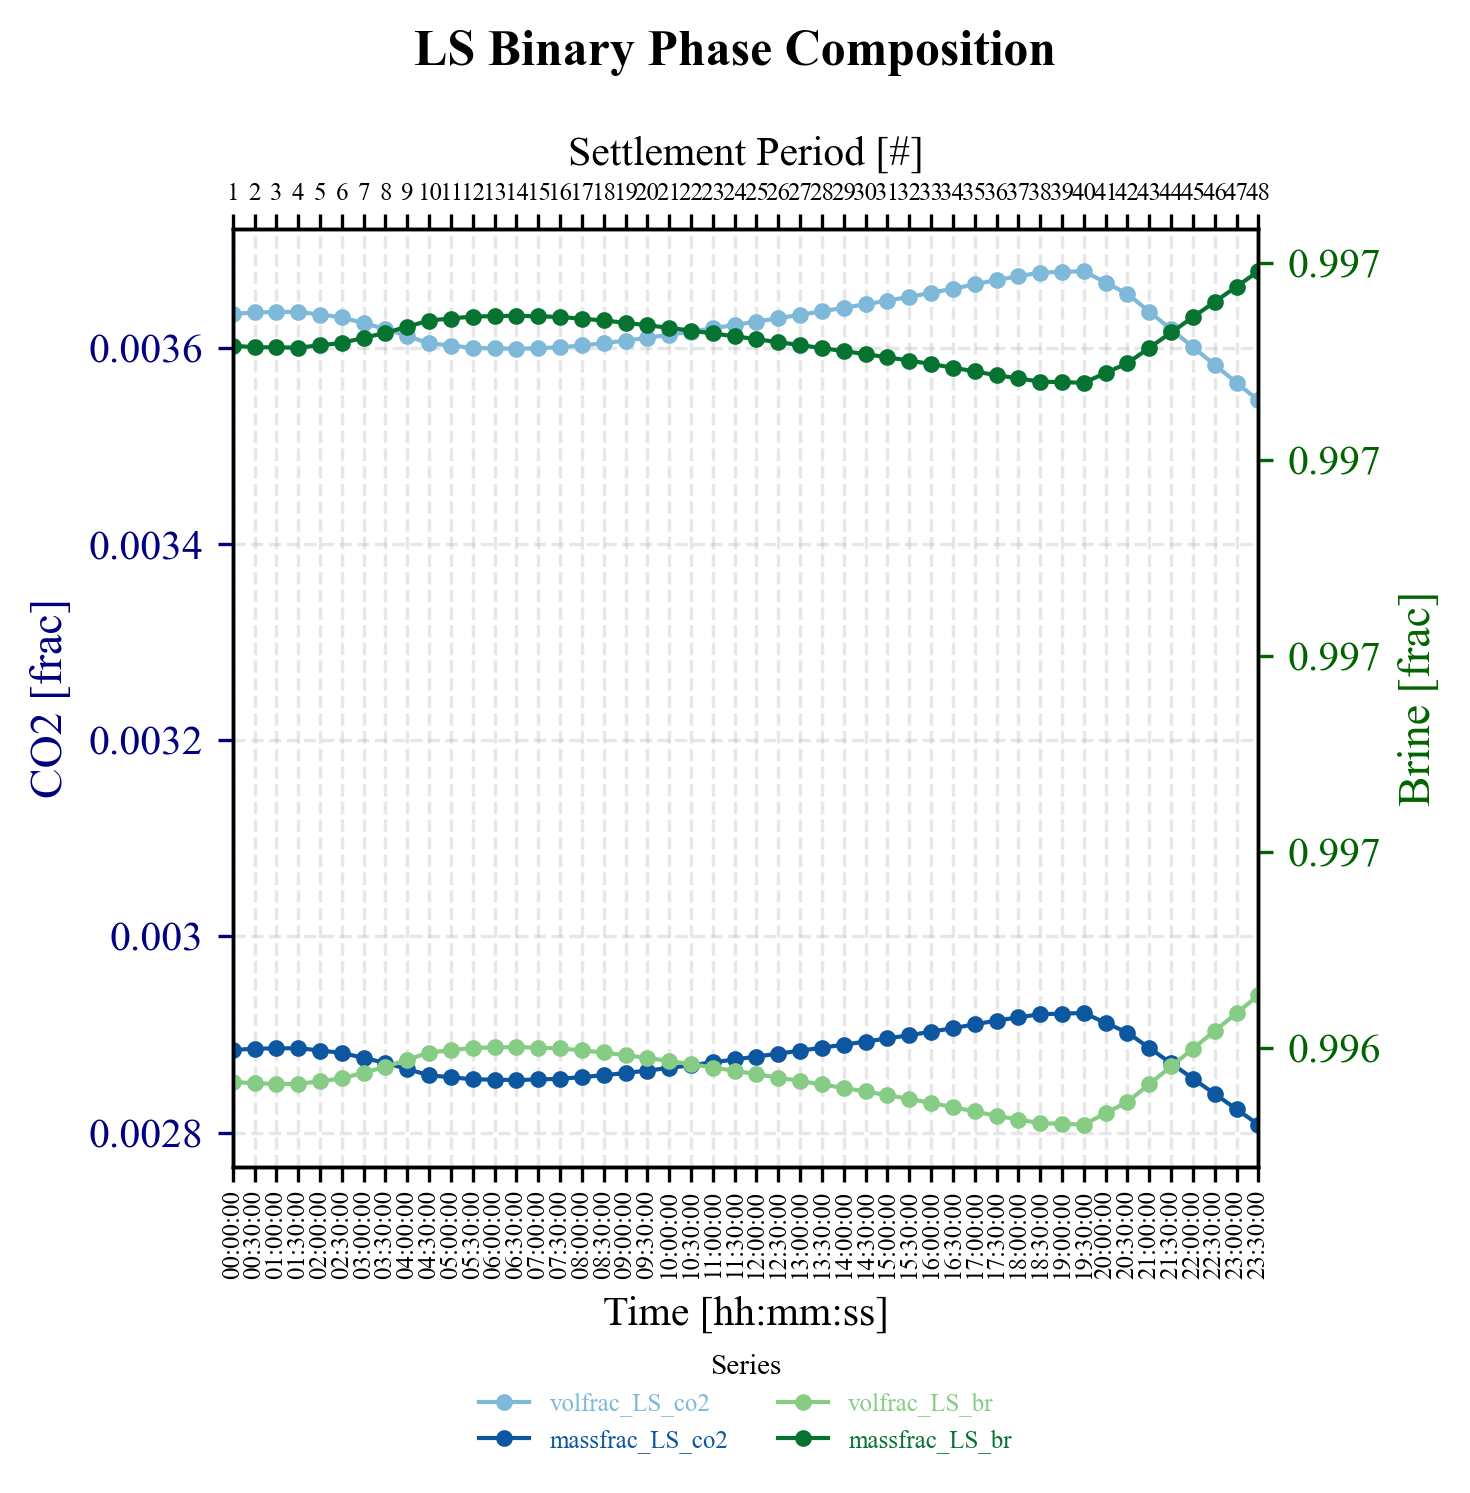

In [123]:
Figure_title = 'LS Binary Phase Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['volfrac_LS_co2','massfrac_LS_co2'],
    left_label= 'CO2',
    left_units='[frac]',
    series_right=['volfrac_LS_br','massfrac_LS_br'],
    right_label= 'Brine',
    right_units='[frac]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

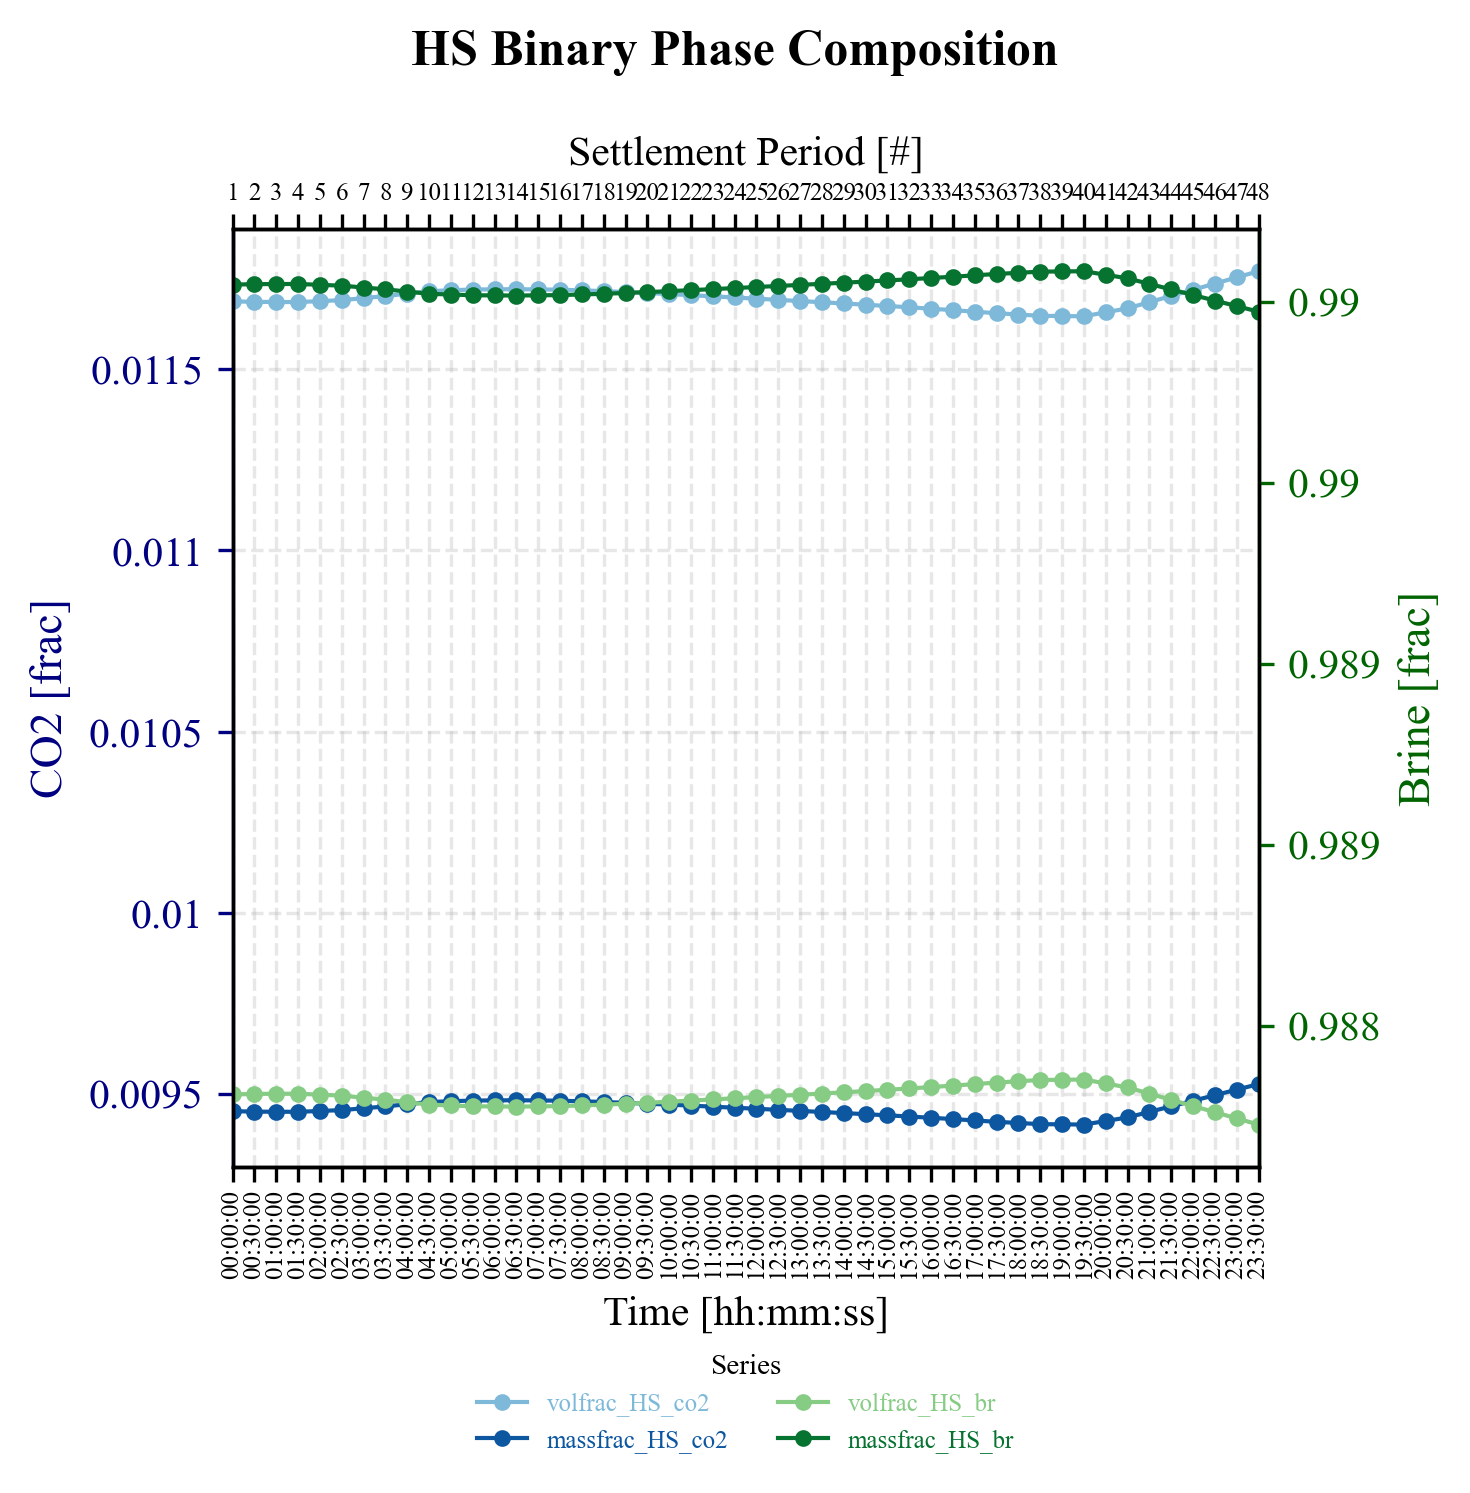

In [124]:
Figure_title = 'HS Binary Phase Composition'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['volfrac_HS_co2','massfrac_HS_co2'],
    left_label= 'CO2',
    left_units='[frac]',
    series_right=['volfrac_HS_br','massfrac_HS_br'],
    right_label= 'Brine',
    right_units='[frac]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

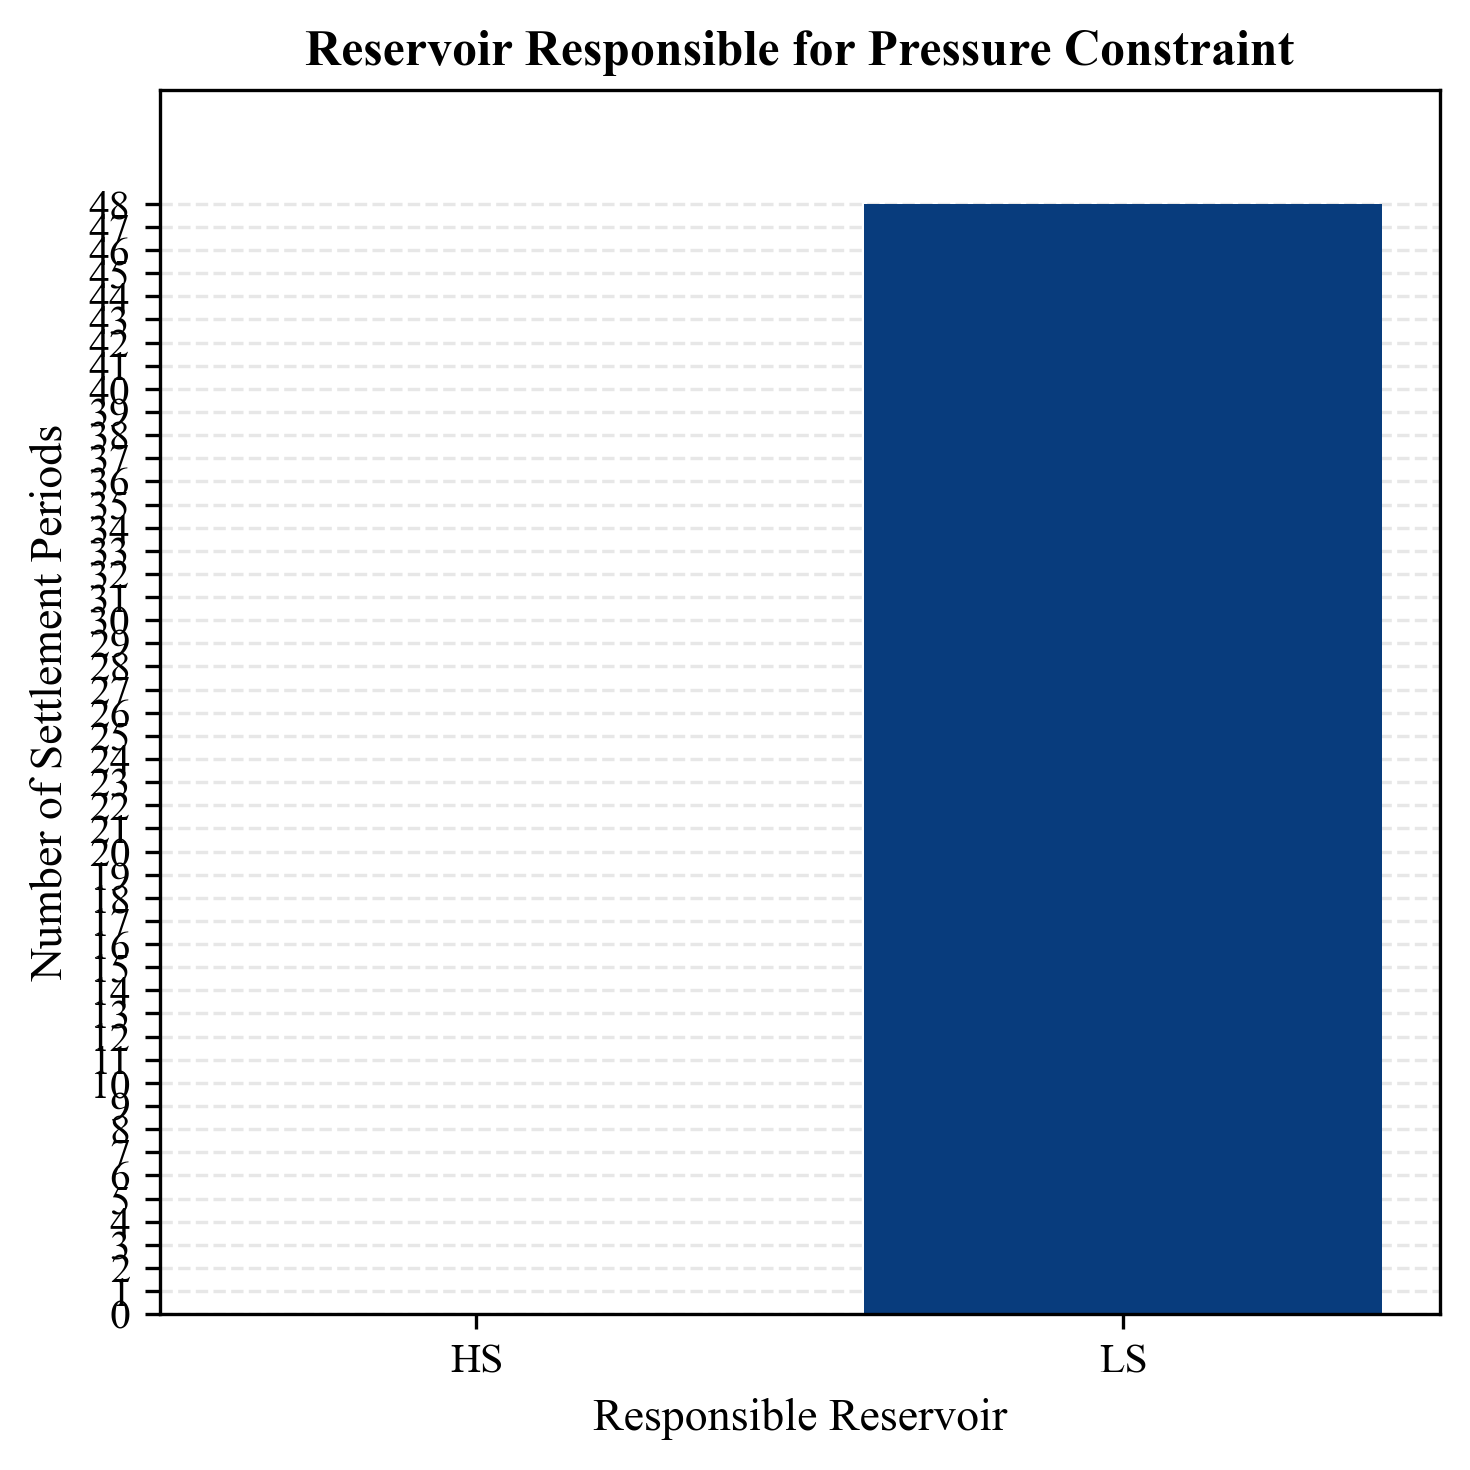

In [125]:
Figure_title = 'Reservoir Responsible for Pressure Constraint'

counts = dfQSS['reservoir_responsible_pressure_constraint'].value_counts(); HS_count = counts.get('HS', 0); LS_count = counts.get('LS', 0)
kpis = ['HS', 'LS']
y_data = [HS_count, LS_count]

fig, ax = plt.subplots(figsize=figsize_std, dpi=300)
cmap = plt.get_cmap('Blues'); hues = np.linspace(0.2, 0.95, len(kpis)); colors = cmap(hues)
x = np.arange(len(kpis)); bars = ax.bar(x, y_data, color=colors, edgecolor='none')
ax.set_xticks(x); ax.set_xticklabels(kpis); ax.set_xlabel('Responsible Reservoir'); ax.set_ylabel('Number of Settlement Periods'); ax.set_title(Figure_title)
y_max = max(y_data); ax.set_yticks(np.arange(0, y_max+1, 1))
plt.rcParams['font.family']    = 'serif'; plt.rcParams['font.serif']     = ['Times New Roman']; plt.rcParams['axes.titlesize'] = 12; plt.rcParams['axes.titleweight'] = 'bold'; plt.rcParams['axes.labelsize'] = 11; plt.rcParams['xtick.labelsize'] = 10; plt.rcParams['ytick.labelsize'] = 10; plt.rcParams['legend.fontsize'] = 8
ax.grid(axis='y', linestyle='--', alpha=0.3); ax.set_axisbelow(True); y0, y1 = ax.get_ylim(); dy = (y1 - y0) * 0.05; ax.set_ylim(y0, y1 + dy)

plt.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; plt.savefig(out_path, dpi=300, bbox_inches='tight')

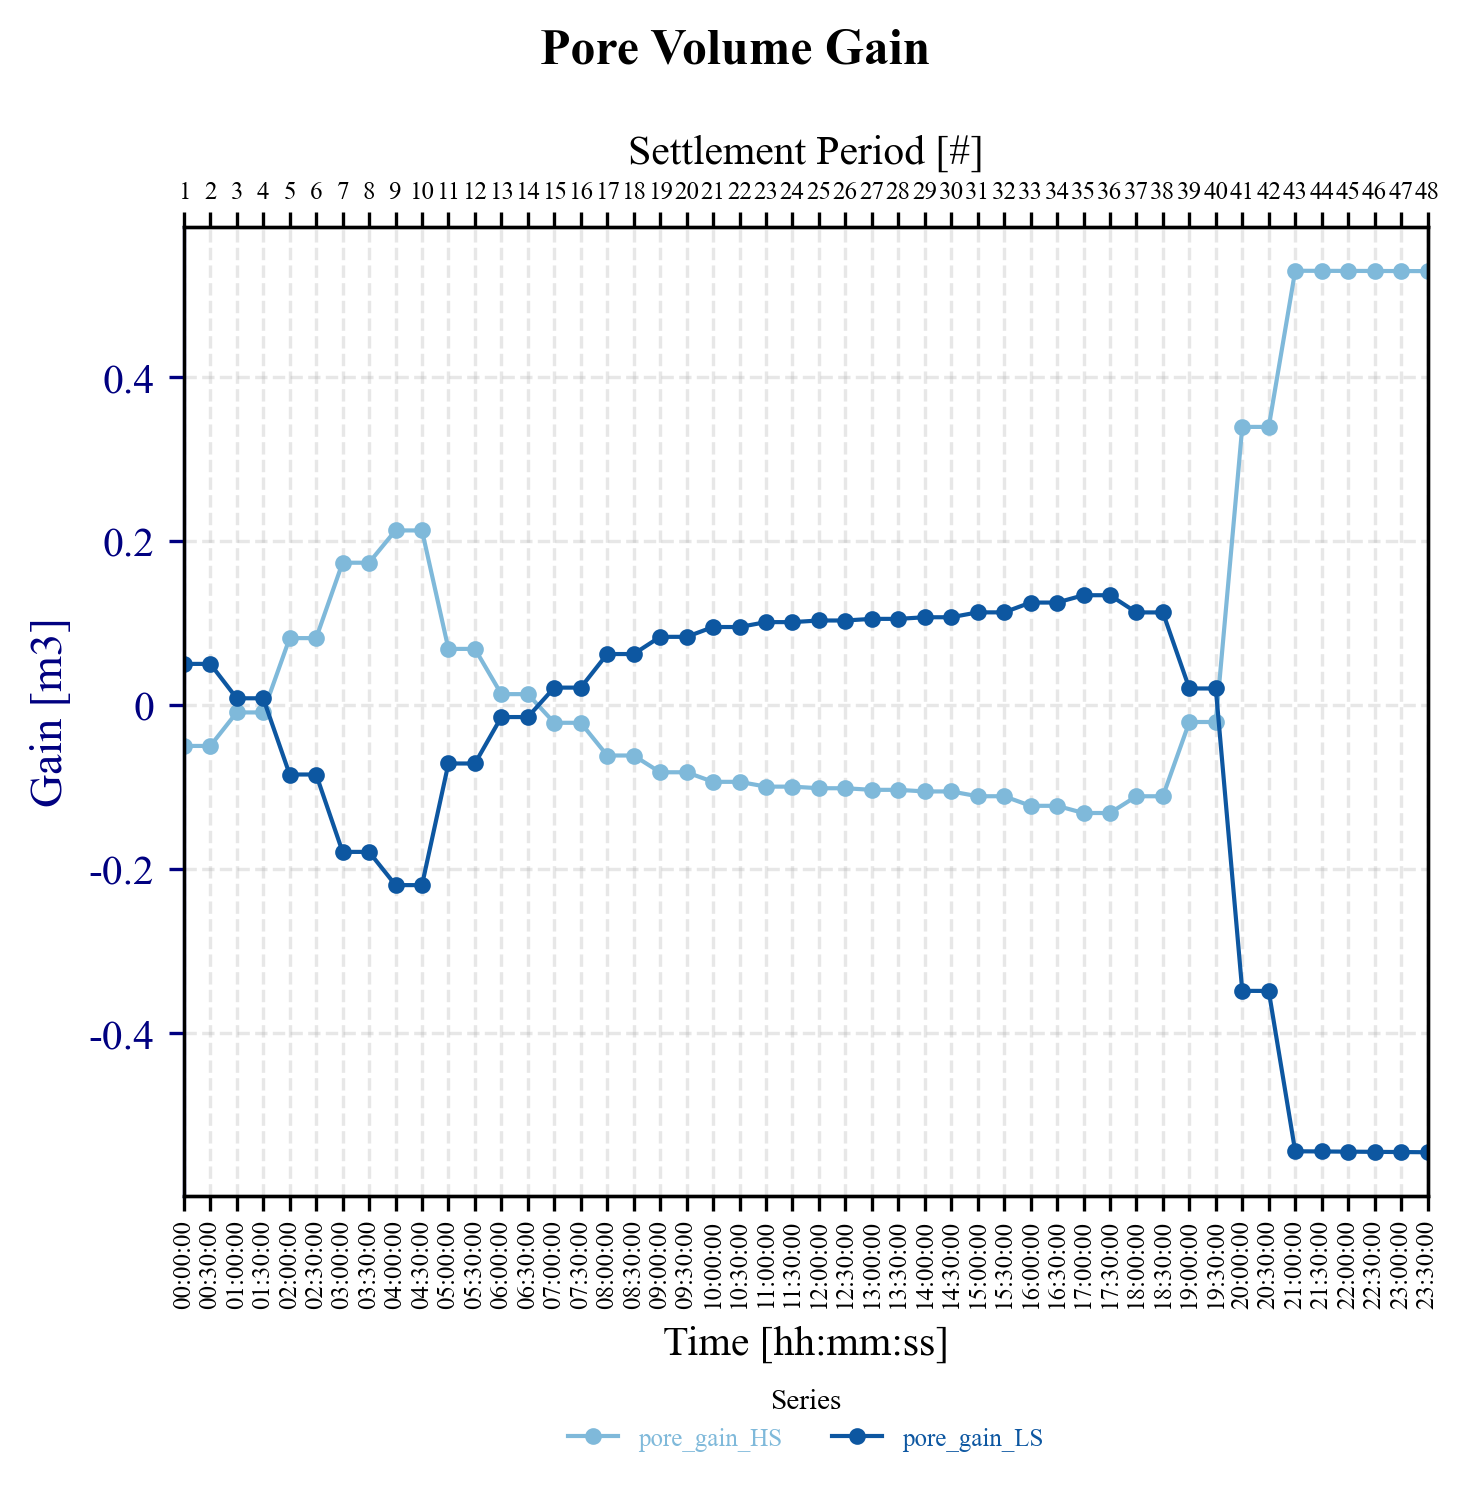

In [126]:
Figure_title = 'Pore Volume Gain'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['pore_gain_HS','pore_gain_LS'],
    left_label= 'Gain',
    left_units='[m3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

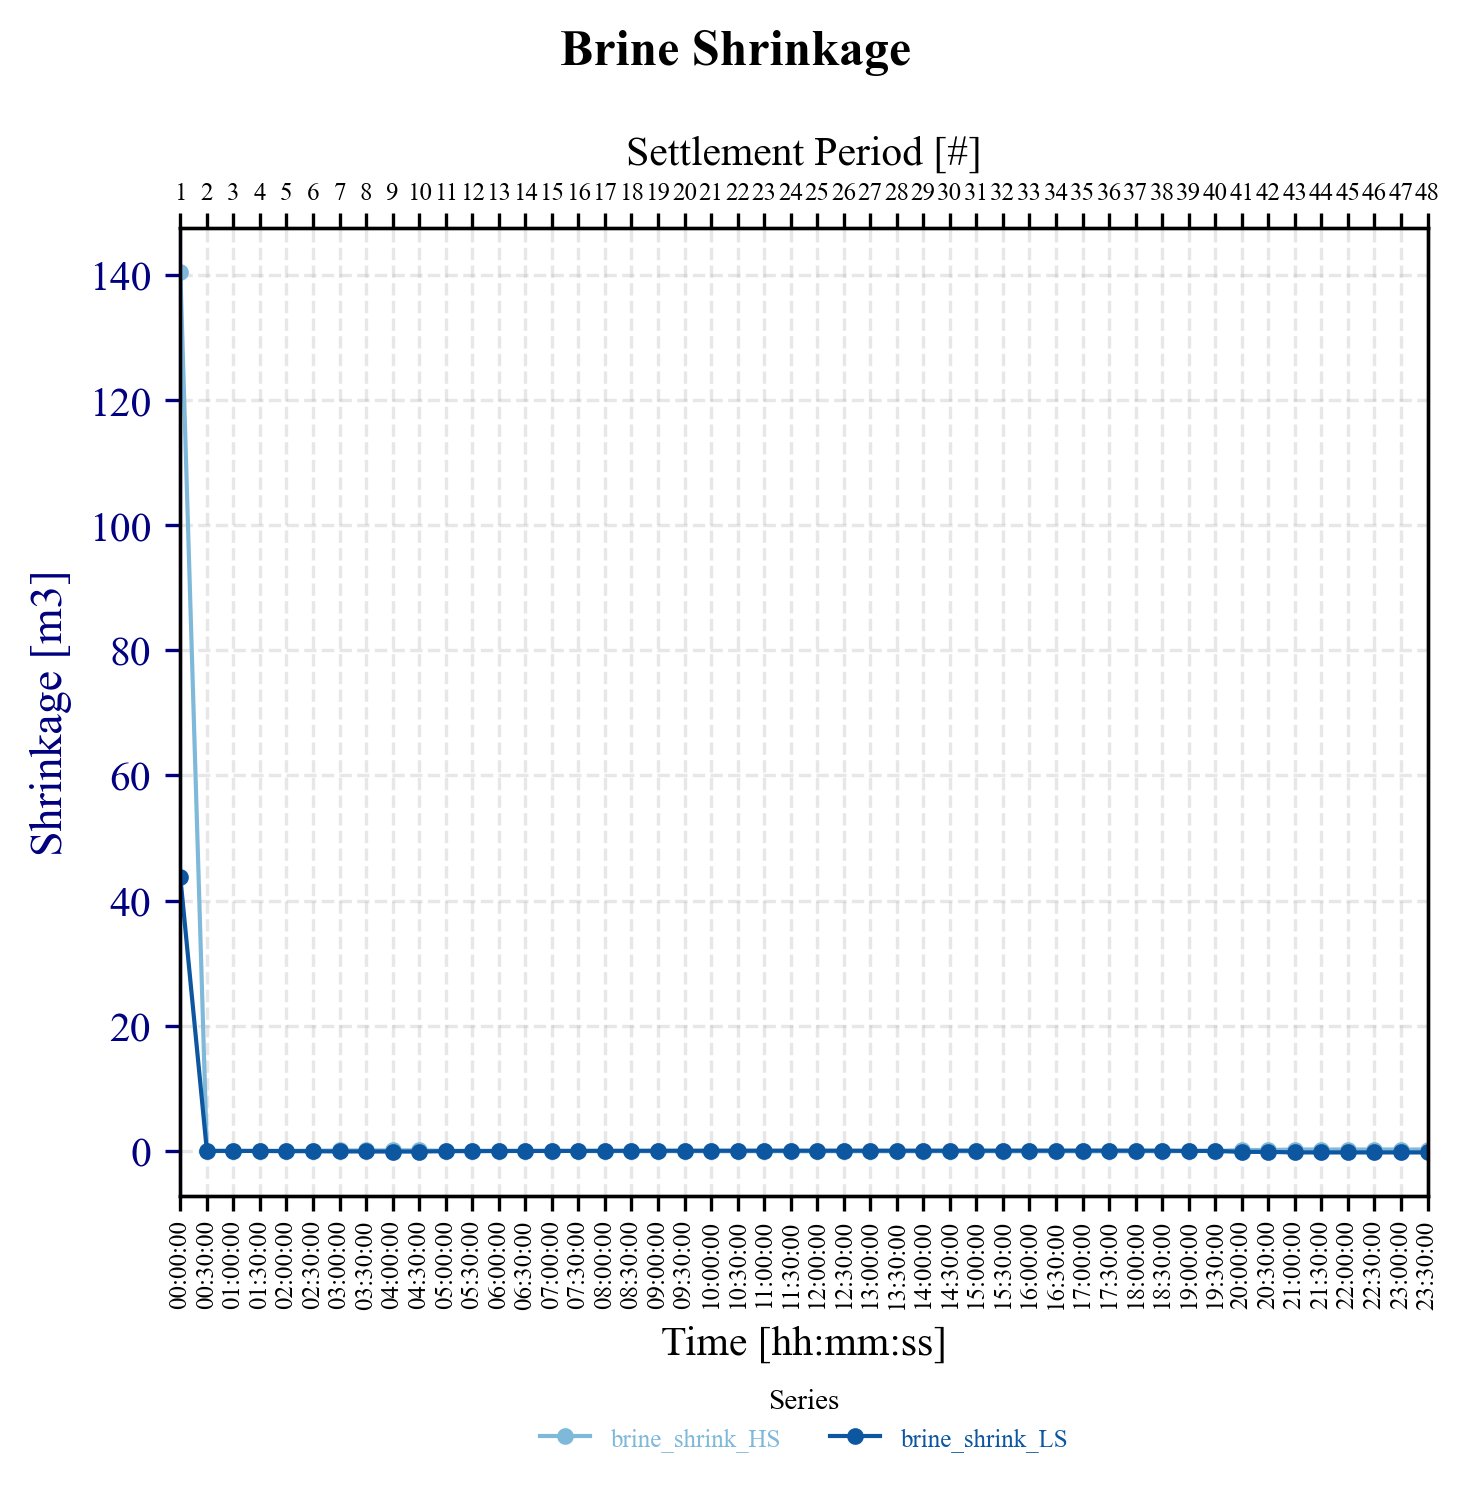

In [127]:
Figure_title = 'Brine Shrinkage'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['brine_shrink_HS','brine_shrink_LS'],
    left_label= 'Shrinkage',
    left_units='[m3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

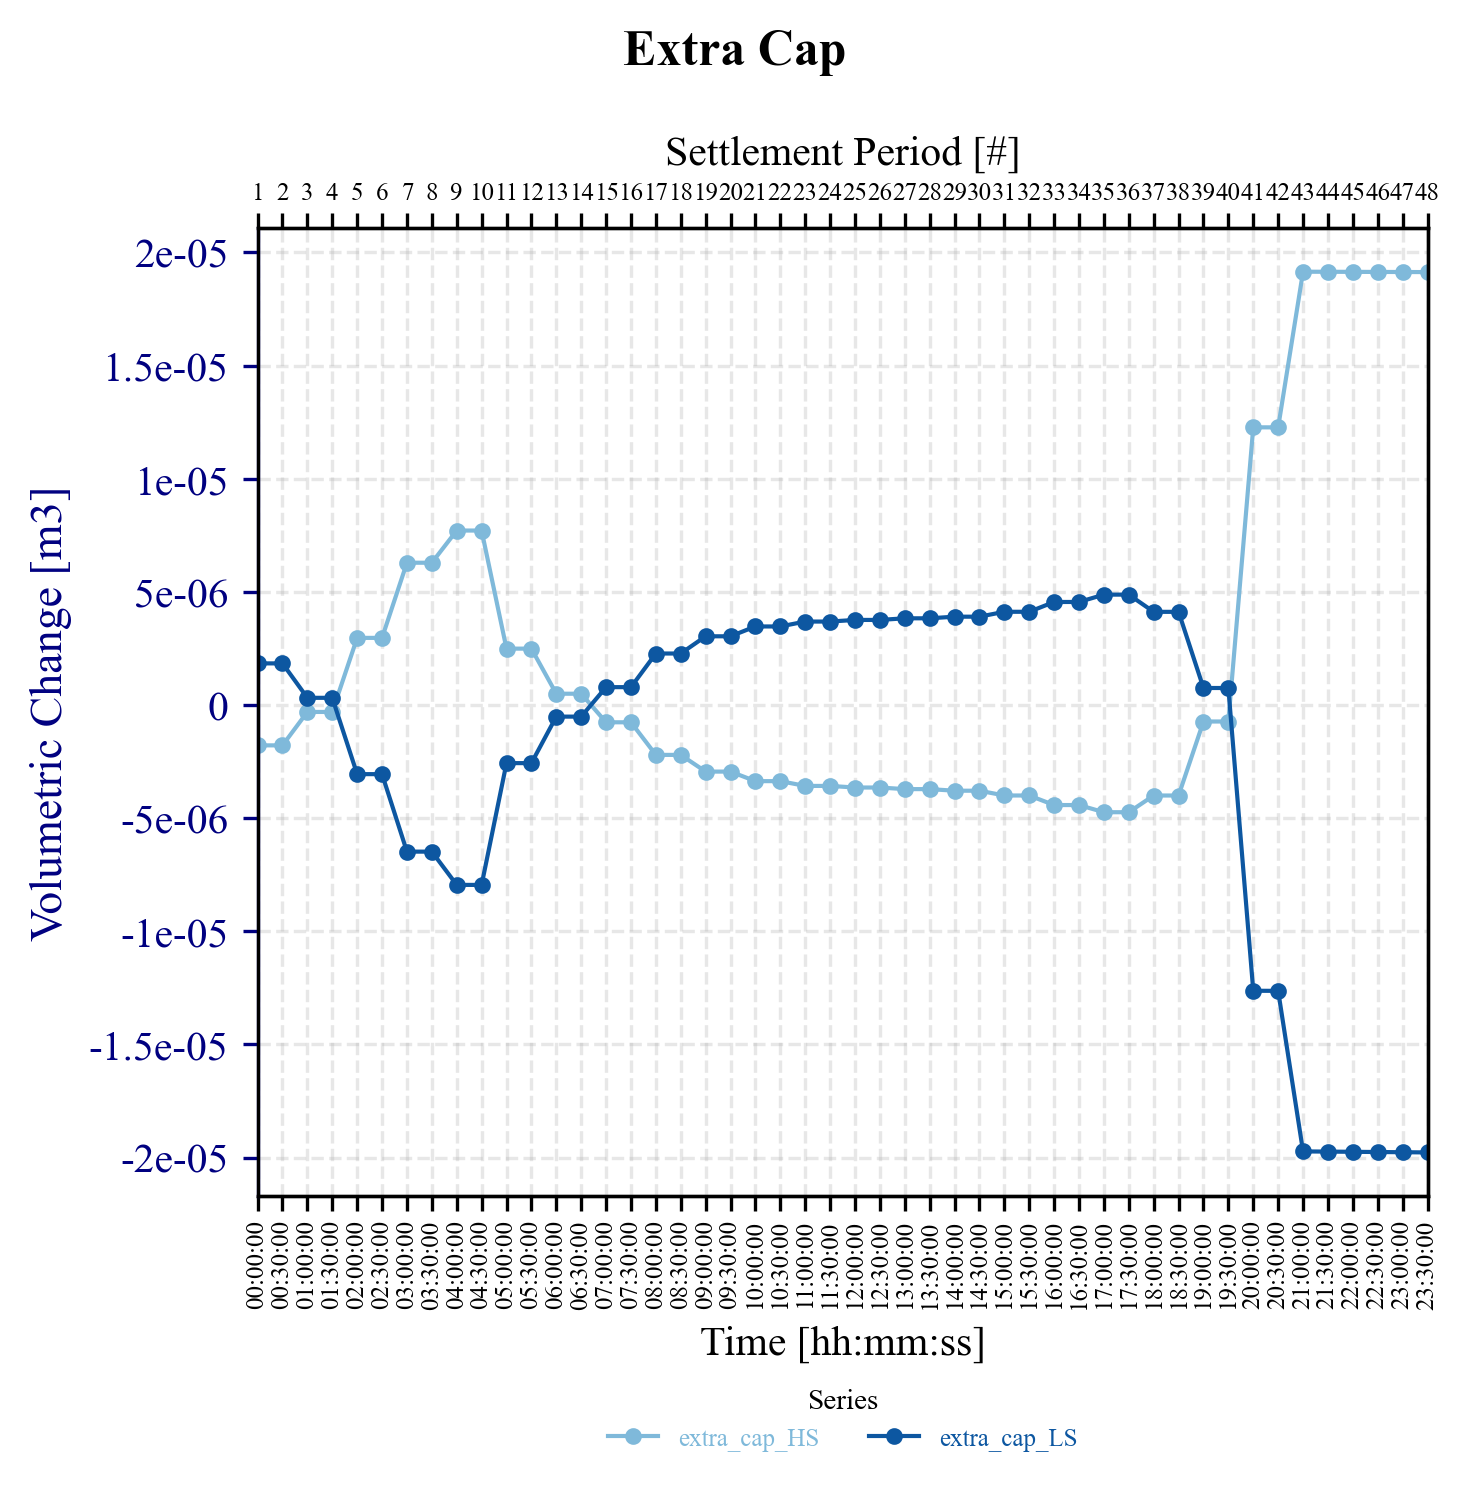

In [128]:
Figure_title = 'Extra Cap'
fig, ax = visualize_QSS(dfQSS,figsize=figsize_std, title=Figure_title,
    series_left=['extra_cap_HS','extra_cap_LS'],
    left_label= 'Volumetric Change',
    left_units='[m3]')
                         

fig.tight_layout(); out_path = fig_dir / f"{Figure_title}.png"; fig.savefig(out_path, dpi=300, bbox_inches='tight')

In [129]:
import time; from openpyxl import load_workbook
total_runtime = time.time() - _start_time; total_runtime_mins = total_runtime/60; print(f"Simulation total runtime: {total_runtime_mins:.2f} minutes")
KPI_file_path = data_dir / f"{simulation_name}_dfKPI.xlsx"; wb = load_workbook(KPI_file_path); ws = wb.active; ws.append(["Simulation_runtime_mins", total_runtime_mins]); wb.save(KPI_file_path)

Simulation total runtime: 2.87 minutes
